In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import LightSource
from matplotlib.patches import Polygon as mplpoly

mpl.rcParams['figure.dpi']= 300
fs = 7
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : fs}
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

import numpy as np
import pandas as pd
import pickle
from shapely.geometry import Polygon, Point, LineString
import xarray as xr
from sklearn.neighbors import KernelDensity
from pyproj import Proj, transform
import utm
import gzip
from scipy.signal import convolve
from scipy.optimize import curve_fit
from datetime import datetime
from skimage.morphology import disk
from skimage.feature import peak_local_max
from scipy.ndimage.filters import minimum_filter, maximum_filter
from scipy.stats import pearsonr

<ipython-input-1-3a058bf6e424>:11: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)


In [2]:
###############
## FUNCTION DEFS TO FIND SAND FLUX AND DUNE ORIENTATION ##
###############

# representative constants
rhos = 2650 # quartz
rhof = 1.225 # air
grav = 9.81 # gravity
gdia = 300e-6 # aeolian grain diameter
kapp = 0.41 # von karman
z0rf = 1e-3 # roughness length
zU   = 10 # height of ERA5 wind vectors
gamm = 1 # fitting parameter from narteau papers
T = np.linspace(0,np.pi,360) # theta direction options

def flux(U,gdia): # gives you the volume flux scalar given wind speeds and grain diameter (not summed over time)
    uscr = (rhos*grav*gdia/rhof)**0.5/10 # iverson et al 1987   
    usabs = U*kapp/np.log(zU/z0rf) # neutral law of the wall
    usabs[usabs<uscr] = uscr # get rid of negative unreal data
    return 25*rhof/rhos*(gdia/grav)**0.5*(usabs**2-uscr**2) # duran et al 2011


# Figure 1

In [228]:
# load a specific aster results for an era5 tile to display the figure in the cell below, or for something else
with open('era-5/dune_tiles1/tile_%d.pkl'%35607, 'rb') as f:
    gridcells_era,LON_tile,LAT_tile,z_tile,LON_rft_s,LAT_rft_s,z_rft_s,Polygons,RI,AI,RJ,AJ,DR,I_lon,I_lat,J_lon,J_lat,I_meter,J_meter,Z_meter,Z_hist,Z_bin_edges,u,v,U,A,ha1,ha2 = pickle.load(f)

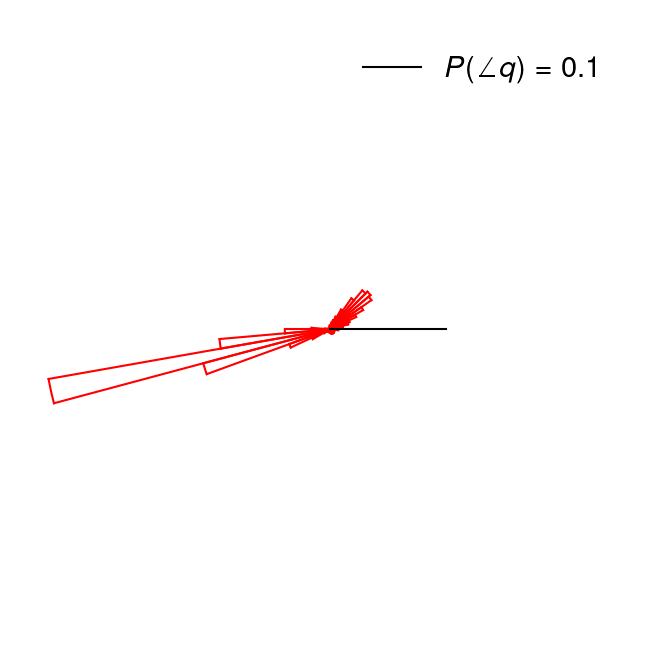

In [229]:
q = flux(U,gdia)
aa = A*180/np.pi
af0 = 0
da = 5
mAf = np.arange(-180,180+da,da)
mAmidf = mAf[1:]-da/2
pq2aa = np.empty(len(mAmidf))
for i in range(len(mAmidf)):
    pq2aa[i] = np.sum(q[(aa>=mAf[i])&(aa<mAf[i+1])])
pq2aa = pq2aa/np.sum(q)

lw = 0.5

fig = plt.gcf()

ax0 = plt.subplot2grid((2, 7), (0, 0), colspan=3, rowspan=3,projection='polar')

for i in range(len(mAmidf)):
    sc = ax0.plot([(mAf[i]+af0)/180*np.pi,(mAf[i]+af0)/180*np.pi],[0,pq2aa[i]],color='r',lw=lw)
    sc = ax0.plot([(mAf[i+1]+af0)/180*np.pi,(mAf[i+1]+af0)/180*np.pi],[0,pq2aa[i]],color='r',lw=lw)
    
    tempt = (np.linspace(mAf[i],mAf[i+1],10)+af0)/180*np.pi
    tempr = np.ones_like(tempt)*pq2aa[i]
    sc = ax0.plot(tempt,tempr,color='r',lw=lw)
    
ax0.plot([0,0],[0,0.1],color='k',label='$P(\\angle q) = 0.1$',lw=lw)

plt.legend(frameon=False,fontsize=fs)
plt.axis('off')

fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.15)
fig.subplots_adjust(bottom=0.05)
fig.subplots_adjust(top=0.96)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(left=0.01)

fig.set_size_inches(142.5/25.4, 142.5/25.4/2.4, forward=True)
plt.savefig('figures/35607-fluxrose.pdf',dpi=300)

In [230]:
factor = 60*60*24*365
duration = len(q)

qx = q*factor/duration*np.cos(A)
qy = q*factor/duration*np.sin(A)
rdpx = np.sum(qx)
rdpy = np.sum(qy)
dpx = np.hstack([0,np.cumsum(qx)])
dpy = np.hstack([0,np.cumsum(qy)])

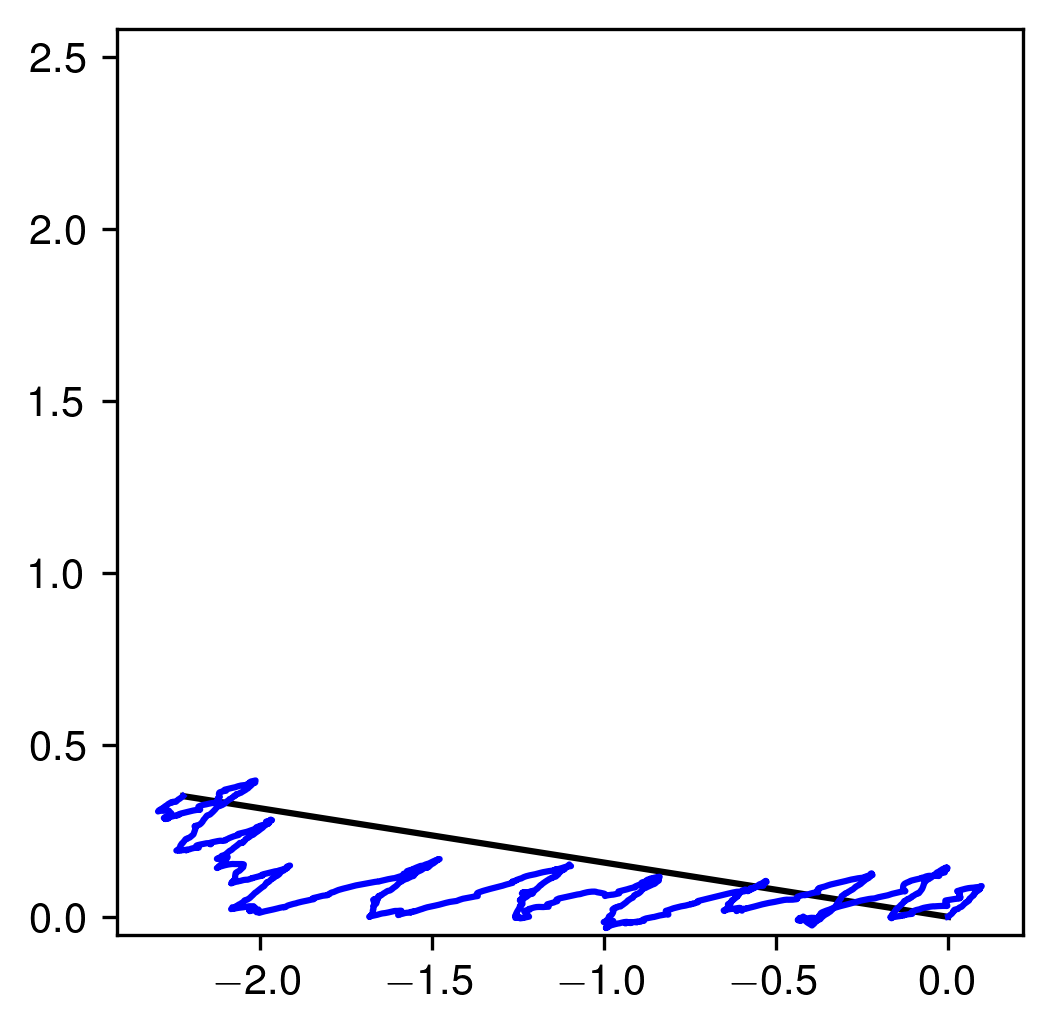

In [231]:
plt.plot([0,rdpx],[0,rdpy],'k')
plt.plot(dpx,dpy,'b')
plt.axis('square')
plt.savefig('figures/35607-vector.pdf',dpi=300)

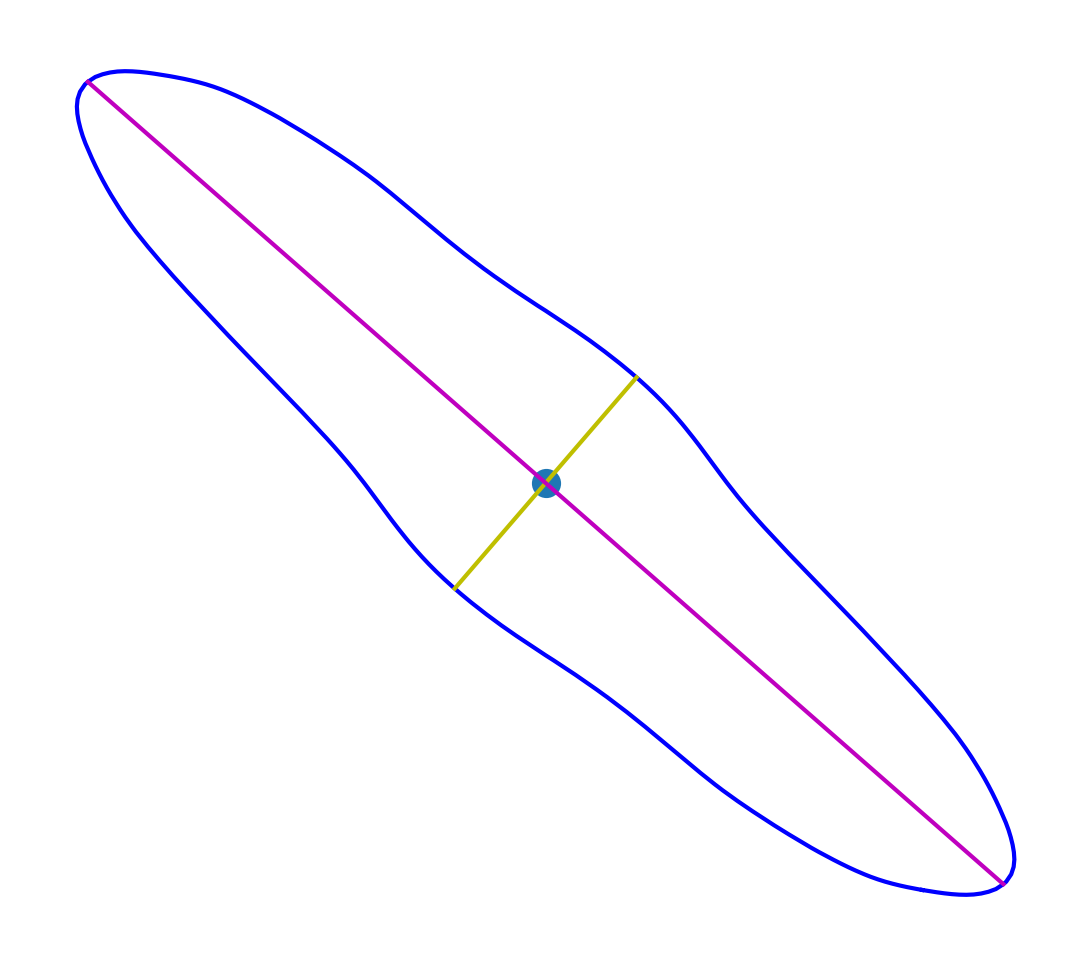

In [232]:
LW = 1
ax2 = plt.subplot(111)
for i in np.arange(0,np.shape(Polygons)[0]):
    x,y = Polygons[i].exterior.xy
    ax2.scatter(0,0)
    sc1 = ax2.plot(x,y, color='b', lw=LW)
sc2 = ax2.plot([-I_lon/2,I_lon/2],[-I_lat/2,I_lat/2],lw=LW,c='y')
sc2 = ax2.plot([-J_lon/2,J_lon/2],[-J_lat/2,J_lat/2],lw=LW,c='m')
# make sure the shapes aren't squeezed in lon or lat
ax2.set_aspect('equal', 'box')

plt.axis('off')
plt.savefig('figures/35607-planform.pdf',dpi=300)

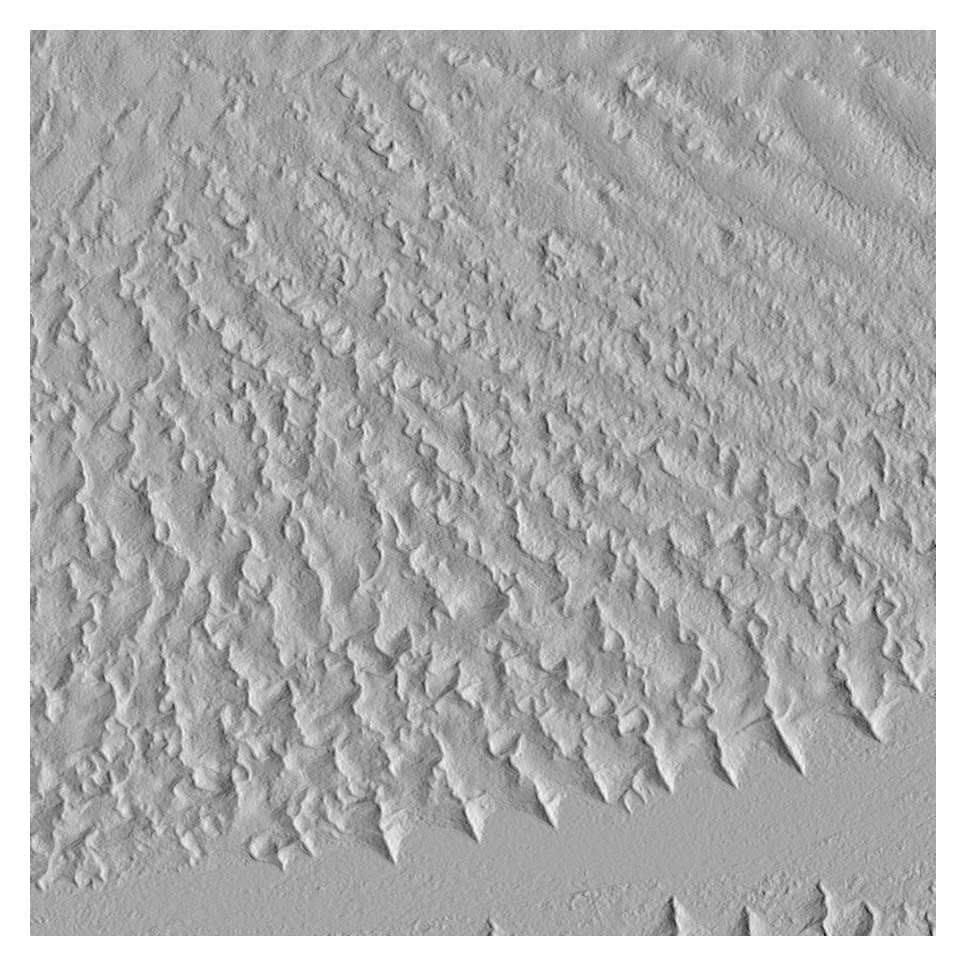

In [233]:
temp = (z_tile-np.min(z_tile))/(np.max(z_tile)-np.min(z_tile))
ve = 10
ls = LightSource(90, 45)
plt.imshow(ls.hillshade(np.flipud(temp), vert_exag=ve), cmap='gray')
plt.axis('off')
plt.savefig('figures/35607-hillshade.png', dpi=300,bbox_inches='tight')

<ipython-input-235-359906e6cfed>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(LON_rft_s,LAT_rft_s,z_rft_s, cmap='seismic',vmin=v1,vmax=-v1,rasterized=True)


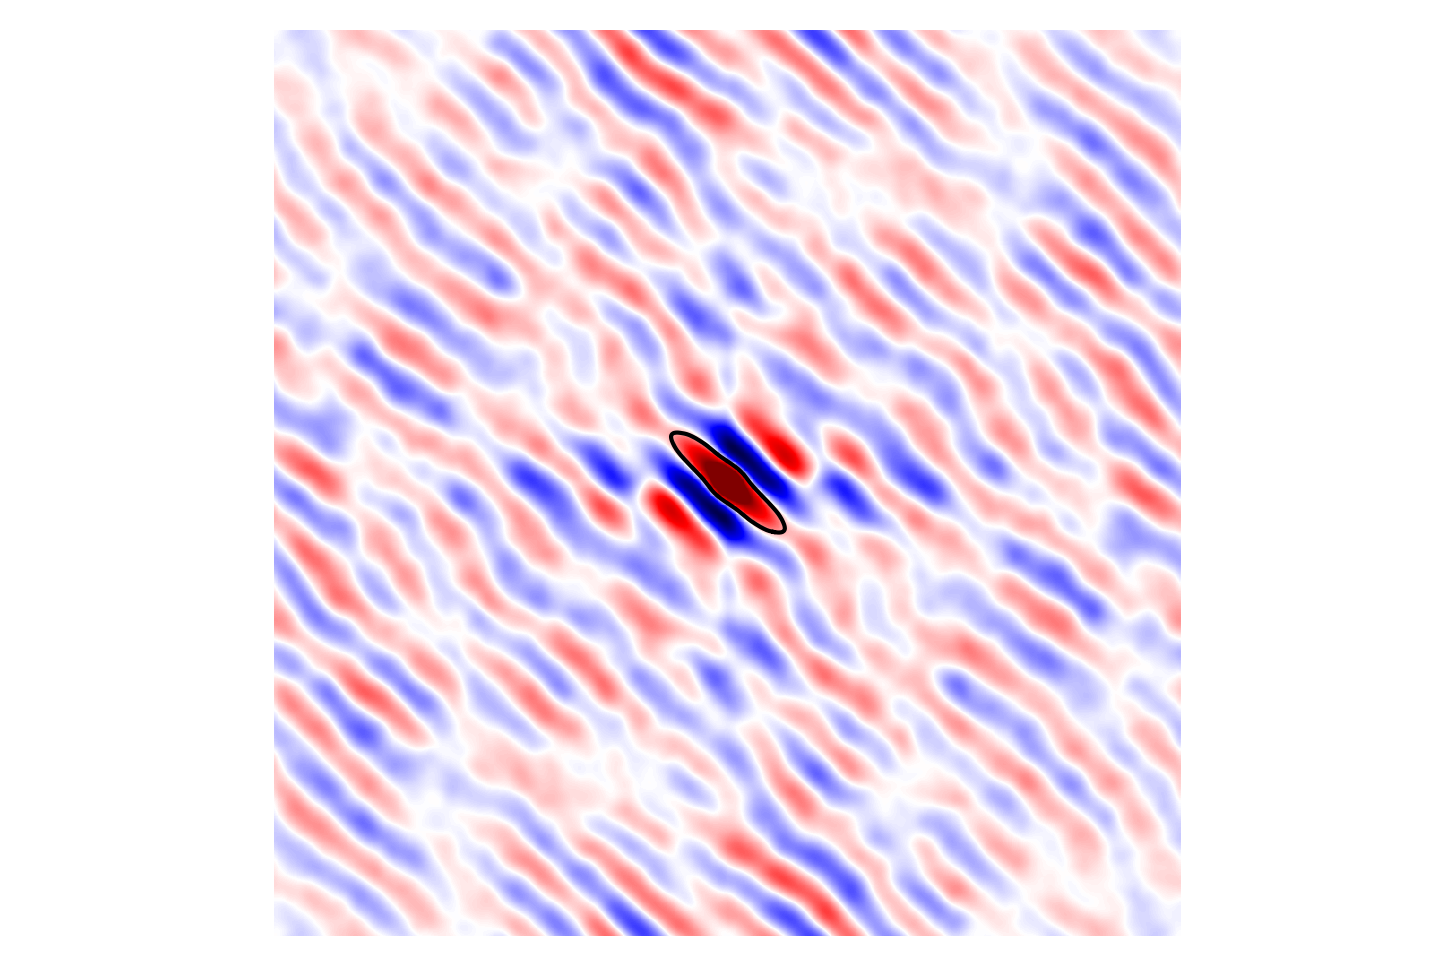

In [235]:
v1 = np.min(z_rft_s)
plt.pcolormesh(LON_rft_s,LAT_rft_s,z_rft_s, cmap='seismic',vmin=v1,vmax=-v1,rasterized=True)
for i in np.arange(0,np.shape(Polygons)[0]):
    x,y = Polygons[i].exterior.xy
    sc1 = plt.plot(x,y, color='k', lw=LW)
plt.axis('equal')
plt.axis('off')
plt.savefig('figures/35607-decorr.png', dpi=300,bbox_inches='tight')

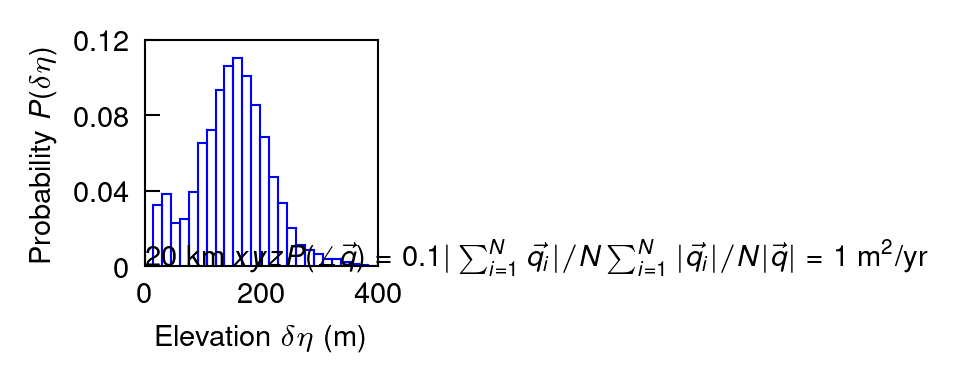

In [379]:
fig = plt.gcf()

ax = plt.subplot(111)

LW = 0.5
lw = 0.5
for i in range(len(Z_hist[0])):
    plt.plot([Z_bin_edges[0][i],Z_bin_edges[0][i]],[0,Z_hist[0][i]/np.sum(Z_hist[0])],c='b',zorder=0,lw=LW)
    plt.plot([Z_bin_edges[0][i+1],Z_bin_edges[0][i+1]],[0,Z_hist[0][i]/np.sum(Z_hist[0])],c='b',zorder=0,lw=LW)
    plt.plot([Z_bin_edges[0][i],Z_bin_edges[0][i+1]],[Z_hist[0][i]/np.sum(Z_hist[0]),Z_hist[0][i]/np.sum(Z_hist[0])],c='b',zorder=0,lw=LW)
plt.text(0,0,'20 km $ x y z P(\\angle \\vec{q}) = 0.1 |\\sum^N_{i=1}\\vec{q_i}|/N \\sum^N_{i=1}|\\vec{q_i}|/N |\\vec{q}|=1$ m$^2$/yr',fontsize=fs)
plt.xlim(0,400)
plt.ylim(0,0.12)
plt.xlabel('Elevation $\delta\eta$ (m)',fontsize=fs)
plt.ylabel('Probability $P(\delta\eta)$',fontsize=fs)
ax.set_xticks([0,200,400])
ax.set_xticklabels(['$0$','$200$','$400$'],fontsize=fs)
ax.set_yticks([0,0.04,0.08,0.12])
ax.set_yticklabels(['$0$','$0.04$','$0.08$','$0.12$'],fontsize=fs)

ax.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)
    
fig.set_size_inches(89/25.4/3.5, 89/25.4/3.5, forward=True)
plt.savefig('figures/35607-zhist.pdf',dpi=300,bbox_inches='tight')

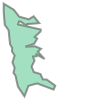

In [8]:
i = 0
with open('era-5/dunefields/df%d_verts.pkl'%i, 'rb') as f:
    df_verts = pickle.load(f)
dunepolys_latlon = Polygon(df_verts)
dunepolys_latlon

In [11]:
timestep = 5
ds = xr.open_dataset('/home/andle/Documents/Python/circadian/DUNEPOLY_EXHAUSTIVE/200801_sea_surface_temperature.nc')
SST = np.asarray(ds.sea_surface_temperature[timestep,:,:])

lon_era = np.asarray(ds.lon)
lat_era = np.asarray(ds.lat)

difflon_era = np.append(np.diff(lon_era)[0],np.diff(lon_era))
difflat_era = np.append(np.diff(lat_era)[0],np.diff(lat_era))

lonBL_era = lon_era-difflon_era/2
latBL_era = lat_era-difflat_era/2

lonBR_era = lon_era+difflon_era/2
latBR_era = lat_era-difflat_era/2

lonTL_era = lon_era-difflon_era/2
latTL_era = lat_era+difflat_era/2

lonTR_era = lon_era+difflon_era/2
latTR_era = lat_era+difflat_era/2

LAT_era,LON_era = np.meshgrid(lat_era,lon_era)

LATBL_era,LONBL_era = np.meshgrid(latBL_era,lonBL_era)
LATBR_era,LONBR_era = np.meshgrid(latBR_era,lonBR_era)
LATTL_era,LONTL_era = np.meshgrid(latTL_era,lonTL_era)
LATTR_era,LONTR_era = np.meshgrid(latTR_era,lonTR_era)

Lon_era = np.ndarray.flatten(LON_era)
Lat_era = np.ndarray.flatten(LAT_era)

LonBL_era = np.ndarray.flatten(LONBL_era)
LatBL_era = np.ndarray.flatten(LATBL_era)
LonBR_era = np.ndarray.flatten(LONBR_era)
LatBR_era = np.ndarray.flatten(LATBR_era)
LonTL_era = np.ndarray.flatten(LONTL_era)
LatTL_era = np.ndarray.flatten(LATTL_era)
LonTR_era = np.ndarray.flatten(LONTR_era)
LatTR_era = np.ndarray.flatten(LATTR_era)

sst   = np.ndarray.flatten(SST.T)
offland = np.argwhere(sst!=273.1604)
onland  = np.argwhere(sst==273.1604)

gridcells_era = []

for i in np.arange(0,np.shape(Lon_era)[0]):
    gridcell = Polygon([(LonBL_era[i],LatBL_era[i]),
                        (LonTL_era[i],LatTL_era[i]),
                        (LonTR_era[i],LatTR_era[i]),
                        (LonBR_era[i],LatBR_era[i])])
    gridcells_era.append(gridcell)

In [12]:
touchinginds = []

for i in np.arange(0,np.shape(Lon_era)[0]):
    if gridcells_era[i].overlaps(dunepolys_latlon):
        touchinginds.append(i)
    elif gridcells_era[i].within(dunepolys_latlon):
        touchinginds.append(i)

In [384]:
qmap = np.empty(len(touchinginds))

for i in range(len(touchinginds)):
    try:
        with open('era-5/dune_tiles1/tile_%d.pkl'%touchinginds[i], 'rb') as f:
            _,LON_tile,LAT_tile,z_tile,LON_rft_s,LAT_rft_s,z_rft_s,Polygons,RI,AI,RJ,AJ,DR,I_lon,I_lat,J_lon,J_lat,I_meter,J_meter,Z_meter,Z_hist,Z_bin_edges,u,v,U,A,ha1,ha2 = pickle.load(f)
        qmap[i] = np.mean(flux(U,gdia))
    except:
        qmap[i] = np.nan

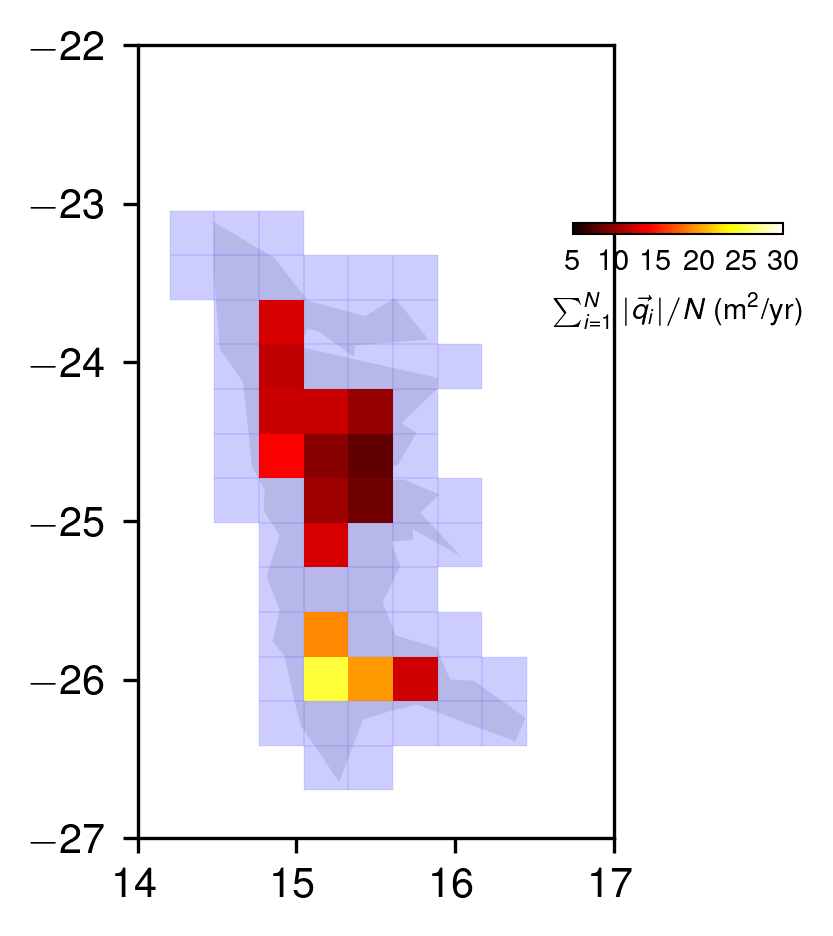

In [390]:
fig = plt.gcf()

ax = plt.subplot(111)

vmin = 5 
vmax = 30
factor = 60*60*24*365

colors = [cm.hot(x) for x in (qmap-vmin/factor)/(vmax/factor-vmin/factor)]

p = mplpoly(np.vstack(dunepolys_latlon.exterior.xy).T, color='grey',alpha=0.2,lw=0)
ax.add_patch(p)

for i in range(len(touchinginds)):
    if np.isnan(qmap[i]):
        p = mplpoly(np.vstack(gridcells_era[touchinginds[i]].exterior.xy).T, color='blue',alpha=0.2,lw=0.1)
    else:
        p = mplpoly(np.vstack(gridcells_era[touchinginds[i]].exterior.xy).T, color=colors[i],lw=0)
    ax.add_patch(p)

s1 = plt.scatter(0,0,c=0,cmap='hot',vmin=vmin,vmax=vmax)
plt.ylim(-27,-22)
plt.xlim(14,17)
ax.set_aspect('equal', 'box')

cbar1_ax = fig.add_axes([0.7,0.7,0.2,0.01])
c1 = fig.colorbar(s1, orientation='horizontal',cax=cbar1_ax, ticks=[5,10,15,20,25,30])
cbar1_ax.xaxis.set_label_position('bottom')
cbar1_ax.xaxis.set_ticks_position('bottom')
c1.set_label('$\\sum^N_{i=1}|\\vec{q_i}|/N$ (m$^2$/yr)',fontsize=fs)
c1.ax.set_xticklabels(['$5$','$10$','$15$','$20$','$25$','$30$'],fontsize=fs)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)

fig.set_size_inches(89/25.4, 89/25.4, forward=True)
plt.savefig('figures/namib-era5.pdf',dpi=300,bbox_inches='tight')

# Figure 2

In [6]:
##
##
# load the variable arrays in the cell above
with open('era-5/combined.pkl', 'rb') as f:
    I_M,J_M,Z_M,Is_M,Js_M,Zs_M,Il_M,Jl_M,Zl_M,AIa,AJa,AIs,AJs,AIl,AJl,DRa,DRas,DRal,tileno,Q,RDP,DP,BEDA,FINA,Qvar = pickle.load(f)
##
##
    
##
##
# load dune type list
# this was done manually looking at the aster DEMs & occasionally google earth 
# and information stored in a text file
# first row in the text file is a key
# this list is in sequential order of ERA5 tile numbers

text_file = open('era-5/dunetypeids.txt', 'r')
lines = text_file.readlines()
text_file.close()

DTs = []
DTl = []
DT  = []

for i in lines:
    temp = [c for c in i[:-1]]
    if len(temp)==1:
        DT.append(temp)
        DTs.append(temp[0])
        DTl.append(temp[0])
    elif len(temp)==2:
        DT.append(temp)
        DTs.append(temp[1])
        DTl.append(temp[0])
    else:
        print(i)
##
##

##
##      
# unit conversion and means for fluxes
factor = 60*60*24*365
duration = len(q)
##
##

##
##
# calibrate spatial from algorithm 
spot_check_master = [113531,114803,119928,192819,194099,194736,203696,246575,57178,59102,
                     61668,795769,798321,808577,811135,814305,814310,814945,90457,
                     233137,15585,135891,231218,17494,18773]

Imanual = []
Imanual_mean = np.empty(len(spot_check_master))
Zmanual = []
Zmanual_mean = np.empty(len(spot_check_master))

Ilauto_mean = np.empty(len(spot_check_master))
Zlauto_mean = np.empty(len(spot_check_master))
Isauto_mean = np.empty(len(spot_check_master))
Zsauto_mean = np.empty(len(spot_check_master))

for j in range(len(spot_check_master)):
    Imanual.append(np.asarray(pd.read_csv('figures/spot-check/%d-x.csv'%spot_check_master[j],header=0).iloc[:,-1]))
    Imanual_mean[j] = np.mean(Imanual[j])
    Zmanual.append(np.asarray(pd.read_csv('figures/spot-check/%d-z.csv'%spot_check_master[j],header=0).iloc[:,-1]))
    Zmanual_mean[j] = np.mean(Zmanual[j])

    with open('era-5/dune_tiles1/tile_%d.pkl'%spot_check_master[j], 'rb') as f:
        gridcells_era,LON_tile,LAT_tile,z_tile,LON_rft_s,LAT_rft_s,z_rft_s,Polygons,RI,AI,RJ,AJ,DR,I_lon,I_lat,J_lon,J_lat,I_meter,J_meter,Z_meter,Z_hist,Z_bin_edges,u,v,U,A,ha1,ha2 = pickle.load(f)
    Ilauto_mean[j] = np.max(I_meter)
    Zlauto_mean[j] = np.max(Z_meter)
    Isauto_mean[j] = np.min(I_meter)
    Zsauto_mean[j] = np.min(Z_meter)
    
Icalibrate, _, _, _ = np.linalg.lstsq(Ilauto_mean[:,np.newaxis], Imanual_mean)
Zcalibrate, _, _, _ = np.linalg.lstsq(Zlauto_mean[:,np.newaxis], Zmanual_mean)
Icalibrate = Icalibrate[0]
Zcalibrate = Zcalibrate[0]
##
##

##
##
# put all the data in dune type arrays
Zlb = Zl_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='b')]*Zcalibrate
Zll = Zl_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='l')]*Zcalibrate
Zls = Zl_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='s')]*Zcalibrate
Zlt = Zl_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='t')]*Zcalibrate
Ilb = Il_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='b')]*Icalibrate
Ill = Il_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='l')]*Icalibrate
Ils = Il_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='s')]*Icalibrate
Ilt = Il_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='t')]*Icalibrate
Jlb = Jl_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='b')]*Icalibrate
Jll = Jl_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='l')]*Icalibrate
Jls = Jl_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='s')]*Icalibrate
Jlt = Jl_M[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='t')]*Icalibrate

RDPlb = RDP[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='b')]*factor/duration
RDPll = RDP[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='l')]*factor/duration
RDPls = RDP[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='s')]*factor/duration
RDPlt = RDP[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='t')]*factor/duration
DPlb = DP[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='b')]*factor/duration
DPll = DP[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='l')]*factor/duration
DPls = DP[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='s')]*factor/duration
DPlt = DP[np.argsort(tileno)][np.argwhere(np.asarray(DTl)=='t')]*factor/duration

Zsb = Zs_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='b')]*Zcalibrate
Zsl = Zs_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='l')]*Zcalibrate
Zss = Zs_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='s')]*Zcalibrate
Zst = Zs_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='t')]*Zcalibrate
Isb = Is_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='b')]*Icalibrate
Isl = Is_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='l')]*Icalibrate
Iss = Is_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='s')]*Icalibrate
Ist = Is_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='t')]*Icalibrate
Jsb = Js_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='b')]*Icalibrate
Jsl = Js_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='l')]*Icalibrate
Jss = Js_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='s')]*Icalibrate
Jst = Js_M[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='t')]*Icalibrate

RDPsb = RDP[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='b')]*factor/duration
RDPsl = RDP[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='l')]*factor/duration
RDPss = RDP[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='s')]*factor/duration
RDPst = RDP[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='t')]*factor/duration
DPsb = DP[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='b')]*factor/duration
DPsl = DP[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='l')]*factor/duration
DPss = DP[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='s')]*factor/duration
DPst = DP[np.argsort(tileno)][np.argwhere(np.asarray(DTs)=='t')]*factor/duration
##
##

HEADER KEY: b, barchan, l, linear, s, star, t, transverse, n, not a dune, first large, second small



<ipython-input-6-eae3ea5e9596>:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Icalibrate, _, _, _ = np.linalg.lstsq(Ilauto_mean[:,np.newaxis], Imanual_mean)
<ipython-input-6-eae3ea5e9596>:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Zcalibrate, _, _, _ = np.linalg.lstsq(Zlauto_mean[:,np.newaxis], Zmanual_mean)


In [9]:
##################
# TURNS VERTEX TUPLES INTO FIELD AREA
##################
    
Ndunefields = 38

duneareas  = np.empty([np.shape(df_verts)[0]])

# here just reload all the dune field boundary coords into a list
df_verts = []
for i in np.arange(0,Ndunefields):
    with open('era-5/dunefields/df%d_verts.pkl'%i, 'rb') as f:
        df_verts.append(pickle.load(f))
        
# loop through dune fields
for i in np.arange(0,np.shape(df_verts)[0]):

    vertups = df_verts[i]

    #find median UTM of the lat-lon coordinates for the vertices
    utmzone = np.empty(np.shape(vertups)[0])
    for k in np.arange(0,np.shape(vertups)[0]):
        utmzone[k] = utm.from_latlon(vertups[k][1],vertups[k][0])[2]

    # transform the latlon to xy using the UTM above
    lonlat2xy = Proj(proj='utm',zone=int(np.median(utmzone)),ellps='WGS84')
    x, y = lonlat2xy(vertups[:,0], vertups[:,1])
    XY = np.asarray([x,y])

    # use shoelace formula to get the polygon area in km^2
    duneareas[i] = Polygon(XY.T).area

# find all the ERA5 tiles on the dune fields
# this was done manually in google earth and information stored in a text file
# empty rows in the text file delineate seperate dune fields

text_file = open('era-5/era_dune_tiles.txt', 'r')
lines = text_file.readlines()
text_file.close()

ondunes = []
ondune = [0]
for i in lines:
    # some lines of the text file are ranges in tile in N-S columns
    # example 130:135 means tiles 130 through 135 (inclusive)
    if ':' in i:
        start = i.split(':')[0]
        end   = i.split(':')[1]
        end   = end[:-1]
        ondune = np.append(ondune,np.arange(int(start),int(end)+1))
    # empty line implies new dune field below
    elif '\n'==i:
        ondunes.append(ondune[1:])
        ondune = [0]
    else:
        ondune = np.append(ondune,np.asarray(int(i[:-1])))

# long list of all ERA5 dune field tiles, not seperated by field, useful for iteration
Ondunes = np.concatenate(ondunes)

age_df   = np.asarray(pd.read_csv('ages/ages.csv',header=0).iloc[:,0])
age_name = np.asarray(pd.read_csv('ages/ages.csv',header=0).iloc[:,1])
age_area = np.asarray(pd.read_csv('ages/ages.csv',header=0).iloc[:,2])
age_age  = np.asarray(pd.read_csv('ages/ages.csv',header=0).iloc[:,3])
age_ref  = np.asarray(pd.read_csv('ages/ages.csv',header=0).iloc[:,4])

age_mean = np.empty(np.shape(duneareas)[0])
age_mean[:] = np.nan
for i in range(len(age_mean)):
    for j in range(len(age_df)):
        try:
            if int(age_df[j][2:])==i:
                age_mean[i] = age_age[j].astype('float')
        except:
            continue
            
# find average age of each dune type

b_ages = []
l_ages = []
s_ages = []
t_ages = []

for i in range(len(DT)):
    for j in range(len(DT[i])):
        if DT[i][j]=='b':
            for k in range(len(ondunes)):
                if np.sort(tileno)[i] in ondunes[k]:
                    b_ages.append(age_mean[k])
        elif DT[i][j]=='l':
            for k in range(len(ondunes)):
                if np.sort(tileno)[i] in ondunes[k]:
                    l_ages.append(age_mean[k])
        elif DT[i][j]=='s':
            for k in range(len(ondunes)):
                if np.sort(tileno)[i] in ondunes[k]:
                    s_ages.append(age_mean[k])
        elif DT[i][j]=='t':
            for k in range(len(ondunes)):
                if np.sort(tileno)[i] in ondunes[k]:
                    t_ages.append(age_mean[k])
                    
b_ages = np.asarray(b_ages)
l_ages = np.asarray(l_ages)
s_ages = np.asarray(s_ages)
t_ages = np.asarray(t_ages)

print('B total number: ', len(b_ages), ' proportion with ages: ', len(b_ages[~np.isnan(b_ages)])/len(b_ages), ' mean age: ', np.nanmean(b_ages))
print('L total number: ', len(l_ages), ' proportion with ages: ', len(l_ages[~np.isnan(l_ages)])/len(l_ages), ' mean age: ', np.nanmean(l_ages))
print('S total number: ', len(s_ages), ' proportion with ages: ', len(s_ages[~np.isnan(s_ages)])/len(s_ages), ' mean age: ', np.nanmean(s_ages))
print('T total number: ', len(t_ages), ' proportion with ages: ', len(t_ages[~np.isnan(t_ages)])/len(t_ages), ' mean age: ', np.nanmean(t_ages))

/home/andle/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


B total number:  958  proportion with ages:  0.46242171189979125  mean age:  427340.8577878104
L total number:  1262  proportion with ages:  0.436608557844691  mean age:  532225.0453720508
S total number:  428  proportion with ages:  0.24766355140186916  mean age:  378792.4528301887
T total number:  99  proportion with ages:  0.40404040404040403  mean age:  589750.0


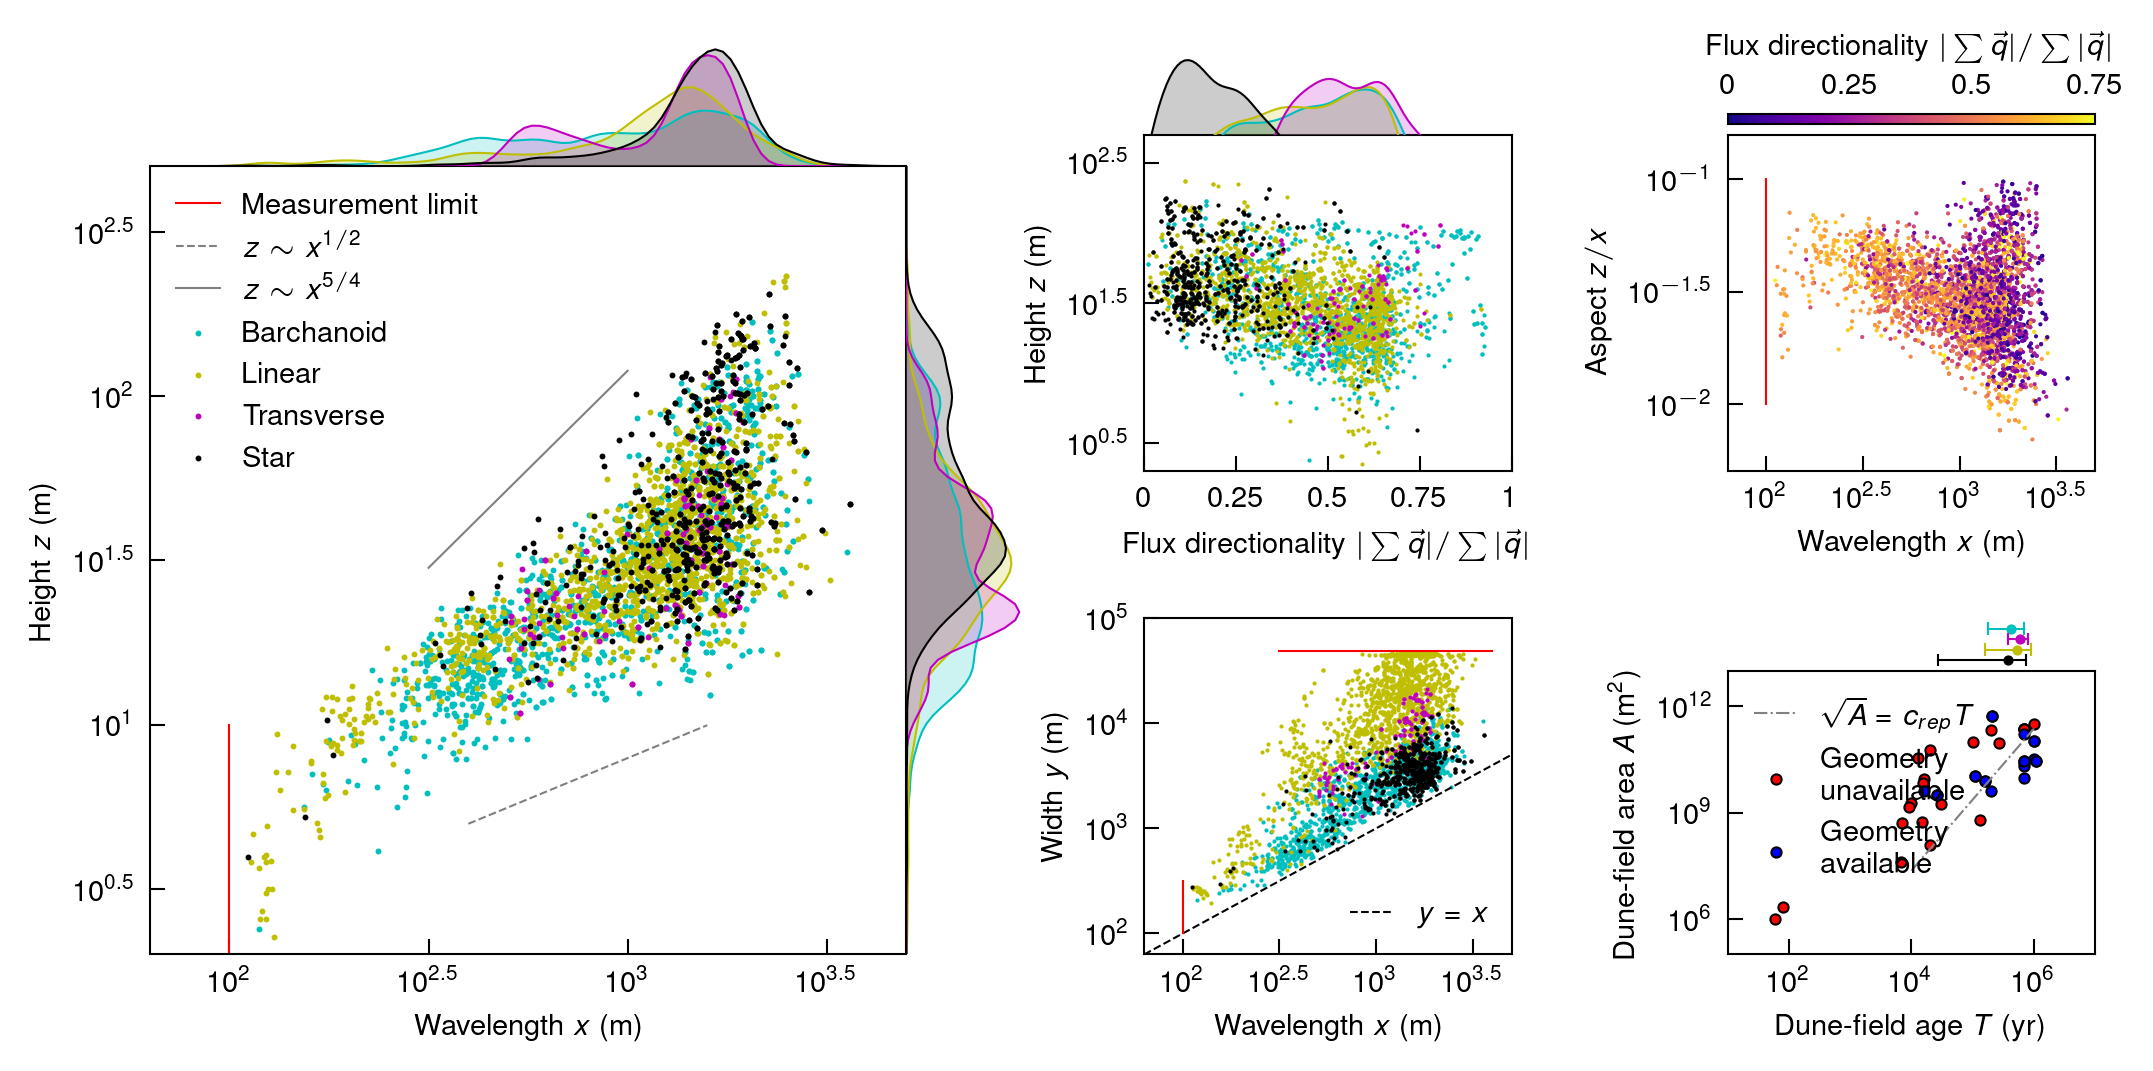

In [797]:
# S = 1
sf = 2
Ilim = 1e+2
rastertf = True

fig = plt.gcf()

ax1 = fig.add_axes([0.07, 0.1, 0.35, 0.75])
plt.scatter(Ilb[Ilb>Ilim],Zlb[Ilb>Ilim],c='c',s=S*sf,lw=0,label='Barchanoid',rasterized=rastertf)
plt.scatter(Isb[Isb>Ilim],Zsb[Isb>Ilim],c='c',s=S*sf,lw=0,rasterized=rastertf)
plt.scatter(Ill[Ill>Ilim],Zll[Ill>Ilim],c='y',s=S*sf,lw=0,label='Linear',rasterized=rastertf)
plt.scatter(Isl[Isl>Ilim],Zsl[Isl>Ilim],c='y',s=S*sf,lw=0,rasterized=rastertf)
plt.scatter(Ilt[Ilt>Ilim],Zlt[Ilt>Ilim],c='m',s=S*sf,lw=0,label='Transverse',rasterized=rastertf)
plt.scatter(Ist[Ist>Ilim],Zst[Ist>Ilim],c='m',s=S*sf,lw=0,rasterized=rastertf)
plt.scatter(Ils[Ils>Ilim],Zls[Ils>Ilim],c='k',s=S*sf,lw=0,label='Star',rasterized=rastertf)
plt.scatter(Iss[Iss>Ilim],Zss[Iss>Ilim],c='k',s=S*sf,lw=0,rasterized=rastertf)
tempx = np.asarray([10**0.3,10**1])
plt.plot(tempx/tempx*Ilim,tempx,'r',lw=lw,label='Measurement limit')
tempx = np.asarray([10**2.6,10**3.2])
plt.plot(tempx,0.25*tempx**0.5,'grey',ls='--',lw=lw,label='$z \\sim x^{1/2}$')
tempx = np.asarray([10**2.5,10**3.0])
plt.plot(tempx,0.03*tempx**1.2,'grey',lw=lw,label='$z \\sim x^{5/4}$')

plt.legend(frameon=False,fontsize=fs,handlelength=lw*3)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**1.8,10**3.7)
plt.ylim(10**0.3,10**2.7)
ax1.set_xlabel('Wavelength $x$ (m)',fontsize=fs)
ax1.set_ylabel('Height $z$ (m)',fontsize=fs)
ax1.set_xticks([10**2,10**2.5,10**3,10**3.5])
ax1.set_xticklabels(['$10^2$','$10^{2.5}$','$10^3$','$10^{3.5}$'],fontsize=fs)
ax1.set_yticks([10**0.5,10**1,10**1.5,10**2,10**2.5])
ax1.set_yticklabels(['$10^{0.5}$','$10^{1}$','$10^{1.5}$','$10^{2}$','$10^{2.5}$'],fontsize=fs)
ax1.tick_params('both', width=lw, which='major')
plt.minorticks_off()

ax11 = fig.add_axes([0.07, 0.85, 0.35, 0.12])

zmin,zmax = 10**1.8,10**3.7
bw = 0.04
Nbins = int(1e+2)

X_plot = np.linspace(np.log10(zmin), np.log10(zmax), Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.log10(np.hstack((Ilb[Ilb>Ilim],Isb[Isb>Ilim])))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(10**X_plot[:, 0], np.exp(log_dens),'c',lw=lw)
plt.fill(10**X_plot[:, 0], np.exp(log_dens), fc='c',alpha=0.2,lw=0)

X_plot = np.linspace(np.log10(zmin), np.log10(zmax), Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.log10(np.hstack((Ill[Ill>Ilim],Isl[Isl>Ilim])))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(10**X_plot[:, 0], np.exp(log_dens),'y',lw=lw)
plt.fill(10**X_plot[:, 0], np.exp(log_dens), fc='y',alpha=0.2,lw=0)

X_plot = np.linspace(np.log10(zmin), np.log10(zmax), Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.log10(np.hstack((Ilt[Ilt>Ilim],Ist[Ist>Ilim])))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(10**X_plot[:, 0], np.exp(log_dens),'m',lw=lw)
plt.fill(10**X_plot[:, 0], np.exp(log_dens), fc='m',alpha=0.2,lw=0)

X_plot = np.linspace(np.log10(zmin), np.log10(zmax), Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.log10(np.hstack((Ils[Ils>Ilim],Iss[Iss>Ilim])))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(10**X_plot[:, 0], np.exp(log_dens),'k',lw=lw)
plt.fill(10**X_plot[:, 0], np.exp(log_dens), fc='k',alpha=0.2,lw=0)

plt.xscale('log')
plt.xlim(zmin,zmax)
plt.ylim(0,4)
plt.axis('off')

ax12 = fig.add_axes([0.07+0.35, 0.1, 0.08, 0.75])

zmin,zmax = 10**0.3,10**2.7
bw = 0.05
Nbins = int(1e+2)

X_plot = np.linspace(np.log10(zmin), np.log10(zmax), Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.log10(np.hstack((Zlb[Ilb>Ilim],Zsb[Isb>Ilim])))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(np.exp(log_dens),10**X_plot[:, 0], 'c',lw=lw)
plt.fill_betweenx(10**X_plot[:, 0], log_dens*0, np.exp(log_dens), fc='c',alpha=0.2,lw=0)

X_plot = np.linspace(np.log10(zmin), np.log10(zmax), Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.log10(np.hstack((Zll[Ill>Ilim],Zsl[Isl>Ilim])))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(np.exp(log_dens),10**X_plot[:, 0], 'y',lw=lw)
plt.fill_betweenx(10**X_plot[:, 0], log_dens*0, np.exp(log_dens), fc='y',alpha=0.2,lw=0)

X_plot = np.linspace(np.log10(zmin), np.log10(zmax), Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.log10(np.hstack((Zlt[Ilt>Ilim],Zst[Ist>Ilim])))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(np.exp(log_dens),10**X_plot[:, 0], 'm',lw=lw)
plt.fill_betweenx(10**X_plot[:, 0], log_dens*0, np.exp(log_dens), fc='m',alpha=0.2,lw=0)

X_plot = np.linspace(np.log10(zmin), np.log10(zmax), Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.log10(np.hstack((Zls[Ils>Ilim],Zss[Iss>Ilim])))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(np.exp(log_dens),10**X_plot[:, 0], 'k',lw=lw)
plt.fill_betweenx(10**X_plot[:, 0], log_dens*0, np.exp(log_dens), fc='k',alpha=0.2,lw=0)

plt.yscale('log')
plt.ylim(zmin,zmax)
plt.xlim(0,3)
plt.axis('off')


ax2 = fig.add_axes([0.53, 0.56, 0.17, 0.32])
plt.scatter(RDPlb[Ilb>Ilim]/DPlb[Ilb>Ilim],Zlb[Ilb>Ilim],c='c',s=S,lw=0,rasterized=rastertf)
plt.scatter(RDPsb[Isb>Ilim]/DPsb[Isb>Ilim],Zsb[Isb>Ilim],c='c',s=S,lw=0,rasterized=rastertf)
plt.scatter(RDPll[Ill>Ilim]/DPll[Ill>Ilim],Zll[Ill>Ilim],c='y',s=S,lw=0,rasterized=rastertf)
plt.scatter(RDPsl[Isl>Ilim]/DPsl[Isl>Ilim],Zsl[Isl>Ilim],c='y',s=S,lw=0,rasterized=rastertf)
plt.scatter(RDPlt[Ilt>Ilim]/DPlt[Ilt>Ilim],Zlt[Ilt>Ilim],c='m',s=S,lw=0,rasterized=rastertf)
plt.scatter(RDPst[Ist>Ilim]/DPst[Ist>Ilim],Zst[Ist>Ilim],c='m',s=S,lw=0,rasterized=rastertf)
plt.scatter(RDPls[Ils>Ilim]/DPls[Ils>Ilim],Zls[Ils>Ilim],c='k',s=S,lw=0,rasterized=rastertf)
plt.scatter(RDPss[Iss>Ilim]/DPss[Iss>Ilim],Zss[Iss>Ilim],c='k',s=S,lw=0,rasterized=rastertf)
plt.yscale('log')
plt.xlim(0,1)
plt.ylim(10**0.3,10**2.7)
ax2.set_xlabel('Flux directionality $|\\sum\\vec{q}|/\\sum|\\vec{q}|$',fontsize=fs)
ax2.set_ylabel('Height $z$ (m)',fontsize=fs)
ax2.set_xticks([0,0.25,0.5,0.75,1])
ax2.set_xticklabels(['$0$','$0.25$','$0.5$','$0.75$','$1$'],fontsize=fs)
ax2.set_yticks([10**0.5,10**1.5,10**2.5])
ax2.set_yticklabels(['$10^{0.5}$','$10^{1.5}$','$10^{2.5}$'],fontsize=fs)
ax2.tick_params('both', width=lw, which='major')
plt.minorticks_off()

ax21 = fig.add_axes([0.53, 0.56+0.32, 0.17, 0.1])

zmin,zmax = 0,1
bw = 0.04
Nbins = int(1e+2)

X_plot = np.linspace(zmin, zmax, Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.hstack((RDPlb[Ilb>Ilim]/DPlb[Ilb>Ilim],RDPsb[Isb>Ilim]/DPsb[Isb>Ilim]))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], log_dens,'c',lw=lw)
plt.fill(X_plot[:, 0], log_dens, fc='c',alpha=0.2,lw=0)

X_plot = np.linspace(zmin, zmax, Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.hstack((RDPll[Ill>Ilim]/DPll[Ill>Ilim],RDPsl[Isl>Ilim]/DPsl[Isl>Ilim]))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], log_dens,'y',lw=lw)
plt.fill(X_plot[:, 0], log_dens, fc='y',alpha=0.2,lw=0)

X_plot = np.linspace(zmin, zmax, Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.hstack((RDPlt[Ilt>Ilim]/DPlt[Ilt>Ilim],RDPst[Ist>Ilim]/DPst[Ist>Ilim]))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], log_dens,'m',lw=lw)
plt.fill(X_plot[:, 0], log_dens, fc='m',alpha=0.2,lw=0)

X_plot = np.linspace(zmin, zmax, Nbins)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.hstack((RDPls[Ils>Ilim]/DPls[Ils>Ilim],RDPss[Iss>Ilim]/DPss[Iss>Ilim]))[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], log_dens,'k',lw=lw)
plt.fill(X_plot[:, 0], log_dens, fc='k',alpha=0.2,lw=0)

plt.xlim(zmin,zmax)
plt.ylim(0,2)
plt.axis('off')

vmin = 0
vmax = 0.75

ax3 = fig.add_axes([0.53+0.18+0.09, 0.56, 0.17, 0.32])
plt.scatter(Ilb[Ilb>Ilim],Zlb[Ilb>Ilim]/Ilb[Ilb>Ilim],c=RDPlb[Ilb>Ilim]/DPlb[Ilb>Ilim],vmin=vmin,vmax=vmax,cmap=cmap,s=S,lw=0,rasterized=rastertf)
plt.scatter(Ill[Ill>Ilim],Zll[Ill>Ilim]/Ill[Ill>Ilim],c=RDPll[Ill>Ilim]/DPll[Ill>Ilim],vmin=vmin,vmax=vmax,cmap=cmap,s=S,lw=0,rasterized=rastertf)
plt.scatter(Ilt[Ilt>Ilim],Zlt[Ilt>Ilim]/Ilt[Ilt>Ilim],c=RDPlt[Ilt>Ilim]/DPlt[Ilt>Ilim],vmin=vmin,vmax=vmax,cmap=cmap,s=S,lw=0,rasterized=rastertf)
plt.scatter(Ils[Ils>Ilim],Zls[Ils>Ilim]/Ils[Ils>Ilim],c=RDPls[Ils>Ilim]/DPls[Ils>Ilim],vmin=vmin,vmax=vmax,cmap=cmap,s=S,lw=0,rasterized=rastertf)    
plt.scatter(Isb[Isb>Ilim],Zsb[Isb>Ilim]/Isb[Isb>Ilim],c=RDPsb[Isb>Ilim]/DPsb[Isb>Ilim],vmin=vmin,vmax=vmax,cmap=cmap,s=S,lw=0,rasterized=rastertf)
plt.scatter(Isl[Isl>Ilim],Zsl[Isl>Ilim]/Isl[Isl>Ilim],c=RDPsl[Isl>Ilim]/DPsl[Isl>Ilim],vmin=vmin,vmax=vmax,cmap=cmap,s=S,lw=0,rasterized=rastertf)
plt.scatter(Ist[Ist>Ilim],Zst[Ist>Ilim]/Ist[Ist>Ilim],c=RDPst[Ist>Ilim]/DPst[Ist>Ilim],vmin=vmin,vmax=vmax,cmap=cmap,s=S,lw=0,rasterized=rastertf)
s1 = plt.scatter(Iss[Iss>Ilim],Zss[Iss>Ilim]/Iss[Iss>Ilim],c=RDPss[Iss>Ilim]/DPss[Iss>Ilim],vmin=vmin,vmax=vmax,cmap=cmap,s=S,lw=0,rasterized=rastertf)
tempx = np.asarray([10**-2,10**-1])
plt.plot(tempx/tempx*Ilim,tempx,'r',lw=lw)

plt.xscale('log')
plt.yscale('log')
plt.xlim(10**1.8,10**3.7)
plt.ylim(10**-2.3,10**-0.8)
ax3.set_xlabel('Wavelength $x$ (m)',fontsize=fs)
ax3.set_ylabel('Aspect $z/x$',fontsize=fs)
ax3.set_xticks([10**2,10**2.5,10**3,10**3.5])
ax3.set_xticklabels(['$10^2$','$10^{2.5}$','$10^3$','$10^{3.5}$'],fontsize=fs)
ax3.set_yticks([10**-2,10**-1.5,10**-1])
ax3.set_yticklabels(['$10^{-2}$','$10^{-1.5}$','$10^{-1}$'],fontsize=fs)
ax3.tick_params('both', width=lw, which='major')
plt.minorticks_off()

ax4 = fig.add_axes([0.53, 0.1, 0.17, 0.32])
plt.scatter(Ilb[Ilb>Ilim],Jlb[Ilb>Ilim],c='c',s=S,lw=0,rasterized=rastertf)
plt.scatter(Isb[Isb>Ilim],Jsb[Isb>Ilim],c='c',s=S,lw=0,rasterized=rastertf)
plt.scatter(Ill[Ill>Ilim],Jll[Ill>Ilim],c='y',s=S,lw=0,rasterized=rastertf)
plt.scatter(Isl[Isl>Ilim],Jsl[Isl>Ilim],c='y',s=S,lw=0,rasterized=rastertf)
plt.scatter(Ilt[Ilt>Ilim],Jlt[Ilt>Ilim],c='m',s=S,lw=0,rasterized=rastertf)
plt.scatter(Ist[Ist>Ilim],Jst[Ist>Ilim],c='m',s=S,lw=0,rasterized=rastertf)
plt.scatter(Ils[Ils>Ilim],Jls[Ils>Ilim],c='k',s=S,lw=0,rasterized=rastertf)
plt.scatter(Iss[Iss>Ilim],Jss[Iss>Ilim],c='k',s=S,lw=0,rasterized=rastertf)

tempx = np.asarray([10**1.8,10**5])
plt.plot(tempx,tempx,'--k',lw=lw,label='$y=x$')
tempx = np.asarray([10**2.5,10**3.6])
plt.plot(tempx,tempx/tempx*3.2e+4*Icalibrate,'r',lw=lw)
tempx = np.asarray([Ilim,10**2.5])
plt.plot(tempx/tempx*Ilim,tempx,'r',lw=lw)

plt.legend(frameon=False,fontsize=fs,handlelength=lw*3)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**1.8,10**3.7)
plt.ylim(10**1.8,10**5)
ax4.set_xlabel('Wavelength $x$ (m)',fontsize=fs)
ax4.set_ylabel('Width $y$ (m)',fontsize=fs)
ax4.set_xticks([10**2,10**2.5,10**3,10**3.5])
ax4.set_xticklabels(['$10^2$','$10^{2.5}$','$10^3$','$10^{3.5}$'],fontsize=fs)
ax4.set_yticks([10**2,10**3,10**4,10**5])
ax4.set_yticklabels(['$10^{2}$','$10^{3}$','$10^{4}$','$10^{5}$'],fontsize=fs)
ax4.tick_params('both', width=lw, which='major')
plt.minorticks_off()

ax5 = fig.add_axes([0.53+0.18+0.09,0.1,0.17,0.32-0.05])

plt.scatter(age_age[age_df!='nan'],age_area[age_df!='nan']*1e+6,s=S*6,edgecolor='k',lw=lw,c='r',label='Geometry\n unavailable')
plt.scatter(age_mean,duneareas,s=S*6,edgecolor='k',lw=lw,c='b',label='Geometry\n available')
tempx = np.asarray([1e+4,1e+6])
plt.plot(tempx,(np.mean([np.mean(speed[3080:]) for speed in Speed])*LhattoL/(ThattoT*simtstep)*tempx)**2,'grey',ls='-.',lw=lw,label='$\\sqrt{A} = c_{rep}T$')
plt.legend(frameon=False,loc=2,fontsize=fs,handlelength=lw*3)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e+1,1e+7)
plt.ylim(1e+5,1e+13)
plt.xlabel('Dune-field age $T$ (yr)', fontsize=fs)
plt.ylabel('Dune-field area $A$ (m$^{2}$)', fontsize=fs)
ax5.set_xticks([10**2,10**4,10**6])
ax5.set_xticklabels(['$10^2$','$10^{4}$','$10^6$'],fontsize=fs)
ax5.set_yticks([10**6,10**9,10**12])
ax5.set_yticklabels(['$10^{6}$','$10^{9}$','$10^{12}$'],fontsize=fs)
ax5.tick_params('both', width=lw, which='major')
plt.minorticks_off()

ax51 = fig.add_axes([0.53+0.18+0.09,0.1+0.32-0.05,0.17,0.05])

plt.scatter(np.nanmean(b_ages),3,c='c',s=S*6,lw=0)
plt.plot([np.nanmean(b_ages)-np.nanvar(b_ages)**0.5,np.nanmean(b_ages)+np.nanvar(b_ages)**0.5],[3,3],c='c',lw=lw)
plt.plot([np.nanmean(b_ages)-np.nanvar(b_ages)**0.5,np.nanmean(b_ages)-np.nanvar(b_ages)**0.5],[2.5,3.5],c='c',lw=lw)
plt.plot([np.nanmean(b_ages)+np.nanvar(b_ages)**0.5,np.nanmean(b_ages)+np.nanvar(b_ages)**0.5],[2.5,3.5],c='c',lw=lw)
plt.scatter(np.nanmean(t_ages),2,c='m',s=S*6,lw=0)
plt.plot([np.nanmean(t_ages)-np.nanvar(t_ages)**0.5,np.nanmean(t_ages)+np.nanvar(t_ages)**0.5],[2,2],c='m',lw=lw)
plt.plot([np.nanmean(t_ages)-np.nanvar(t_ages)**0.5,np.nanmean(t_ages)-np.nanvar(t_ages)**0.5],[1.5,2.5],c='m',lw=lw)
plt.plot([np.nanmean(t_ages)+np.nanvar(t_ages)**0.5,np.nanmean(t_ages)+np.nanvar(t_ages)**0.5],[1.5,2.5],c='m',lw=lw)
plt.scatter(np.nanmean(l_ages),1,c='y',s=S*6,lw=0)
plt.plot([np.nanmean(l_ages)-np.nanvar(l_ages)**0.5,np.nanmean(l_ages)+np.nanvar(l_ages)**0.5],[1,1],c='y',lw=lw)
plt.plot([np.nanmean(l_ages)-np.nanvar(l_ages)**0.5,np.nanmean(l_ages)-np.nanvar(l_ages)**0.5],[0.5,1.5],c='y',lw=lw)
plt.plot([np.nanmean(l_ages)+np.nanvar(l_ages)**0.5,np.nanmean(l_ages)+np.nanvar(l_ages)**0.5],[0.5,1.5],c='y',lw=lw)
plt.scatter(np.nanmean(s_ages),0,c='k',s=S*6,lw=0)
plt.plot([np.nanmean(s_ages)-np.nanvar(s_ages)**0.5,np.nanmean(s_ages)+np.nanvar(s_ages)**0.5],[0,0],c='k',lw=lw)
plt.plot([np.nanmean(s_ages)-np.nanvar(s_ages)**0.5,np.nanmean(s_ages)-np.nanvar(s_ages)**0.5],[-0.5,0.5],c='k',lw=lw)
plt.plot([np.nanmean(s_ages)+np.nanvar(s_ages)**0.5,np.nanmean(s_ages)+np.nanvar(s_ages)**0.5],[-0.5,0.5],c='k',lw=lw)

plt.axis('off')
plt.xscale('log')
plt.xlim(1e+1,1e+7)
plt.ylim(-1,4)

fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(bottom=0)
fig.subplots_adjust(top=1)
fig.subplots_adjust(right=1)
fig.subplots_adjust(left=0)

cbar1_ax = fig.add_axes([0.53+0.18+0.09, 0.56+0.32+0.01, 0.17, 0.01])
c1 = fig.colorbar(s1, orientation='horizontal',cax=cbar1_ax, ticks=[0,0.25,0.5,0.75])
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
c1.set_label('Flux directionality $|\\sum\\vec{q}|/\\sum|\\vec{q}|$',fontsize=fs)
c1.ax.set_xticklabels(['$0$','$0.25$','$0.5$','$0.75$'],fontsize=fs)

ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw) 
ax4.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw)
ax5.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax5.spines[axis].set_linewidth(lw)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)

fig.set_size_inches(183/25.4, 89/25.4, forward=True)
plt.savefig('figures/fig2-rough.pdf',dpi=300)

In [301]:
print('representative speed from simulations is %.2f m/yr'%(np.mean([np.mean(speed[3080:]) for speed in Speed])*LhattoL/(ThattoT*simtstep)))

representative speed from simulations is 0.48 m/yr


# Figure 3

In [15]:
mlh_time = []
mlh_vals = []

mlh_mean = np.empty(len(duneareas))
mlh_vari = np.empty(len(duneareas))

for i in range(len(duneareas)):
    try:
        temp = np.asarray(pd.read_csv('calipso/Df%.2d_timeseries.csv'%i,header=0).iloc[:,1])*1e+3
        mlh_time.append(np.asarray(pd.read_csv('calipso/Df%.2d_timeseries.csv'%i,header=0).iloc[:,0])[~np.isnan(temp)])
        mlh_vals.append(temp[~np.isnan(temp)])
    except:
        mlh_time.append(np.asarray([]))
        mlh_vals.append(np.asarray([]))
    
    mlh_mean[i] = np.nanmean(mlh_vals[i])
    mlh_vari[i] = np.nanvar(mlh_vals[i])

<ipython-input-15-e57d083846a4>:16: RuntimeWarning: Mean of empty slice
  mlh_mean[i] = np.nanmean(mlh_vals[i])
<ipython-input-15-e57d083846a4>:17: RuntimeWarning: Degrees of freedom <= 0 for slice.
  mlh_vari[i] = np.nanvar(mlh_vals[i])


In [16]:
j = 11
dt0 = datetime.strptime('2006-1-1 00:00:00','%Y-%m-%d %H:%M:%S')
dt_mlh_time = np.empty(len(mlh_time[j]))
for i in range(len(mlh_time[j])):
    dt_mlh_time[i] = (datetime.strptime(mlh_time[j][i],'%Y-%m-%d %H:%M:%S')-dt0).total_seconds()

temp = (dt_mlh_time%(365*24*60*60))/(365*24*60*60)*12
mlh_month_av = np.empty(12)
mlh_month_sd = np.empty(12)
for i in range(12):
    mlh_month_av[i] = np.mean(mlh_vals[j][np.argwhere((temp>i)&(temp<=i+1))])
    mlh_month_sd[i] = np.std(mlh_vals[j][np.argwhere((temp>i)&(temp<=i+1))])

In [26]:
# to compare dune areas to dune geometries, make these comparison arrays
# this gives an array the same size as the number of tiles
# where each element is the area of the dune field the tile is in
# the tileindices array gives the dune field number the tile is in
# this is because the order tiles is read, and therefore the variable array element order, is a mess
tileindices = np.empty([np.shape(tileno)[0],2])
for i in np.arange(0,np.shape(tileno)[0]):
    for j in np.arange(0,np.shape(ondunes)[0]):
        if np.shape(np.argwhere(ondunes[j]==tileno[i]))[0]!=0:
            tileindices[i,:] = [j,np.argwhere(ondunes[j]==tileno[i])[0][0]]

tileindices = tileindices.astype(int)

il_mean = np.empty(np.shape(duneareas)[0])
il_vari = np.empty(np.shape(duneareas)[0])
for i in np.arange(0,np.shape(duneareas)[0]):
    dunetiles = np.argwhere(tileindices[:,0]==i)
    il_mean[i] = np.mean(Il_M[dunetiles])*Icalibrate
    il_vari[i] = np.var(Il_M[dunetiles])*Icalibrate

/home/andle/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/andle/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andle/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/andle/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/andle/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194

In [112]:
x  = np.asarray(pd.read_csv('calipso/calipso_example_df11.csv',header=0).iloc[:36,1])*5e+3
y0 = np.asarray(pd.read_csv('calipso/calipso_example_df11.csv',header=0).iloc[:36,0])*1e+3
y  = np.asarray(pd.read_csv('calipso/calipso_example_df11.csv',header=0).iloc[:,2])*1e+3
z  = np.asarray(pd.read_csv('calipso/calipso_example_df11.csv',header=0).iloc[:,3:])
z[np.isnan(z)] = 0
z = np.abs(z)
y1 = np.asarray([y[np.min(np.argwhere(z[:,i]>0))] for i in range(np.shape(z)[1])])

<ipython-input-158-497a17a50f45>:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc1 = plt.pcolor(x*1e-3,y*1e-3,z*1e+3,vmin=0,vmax=2,cmap='Blues',rasterized=True)


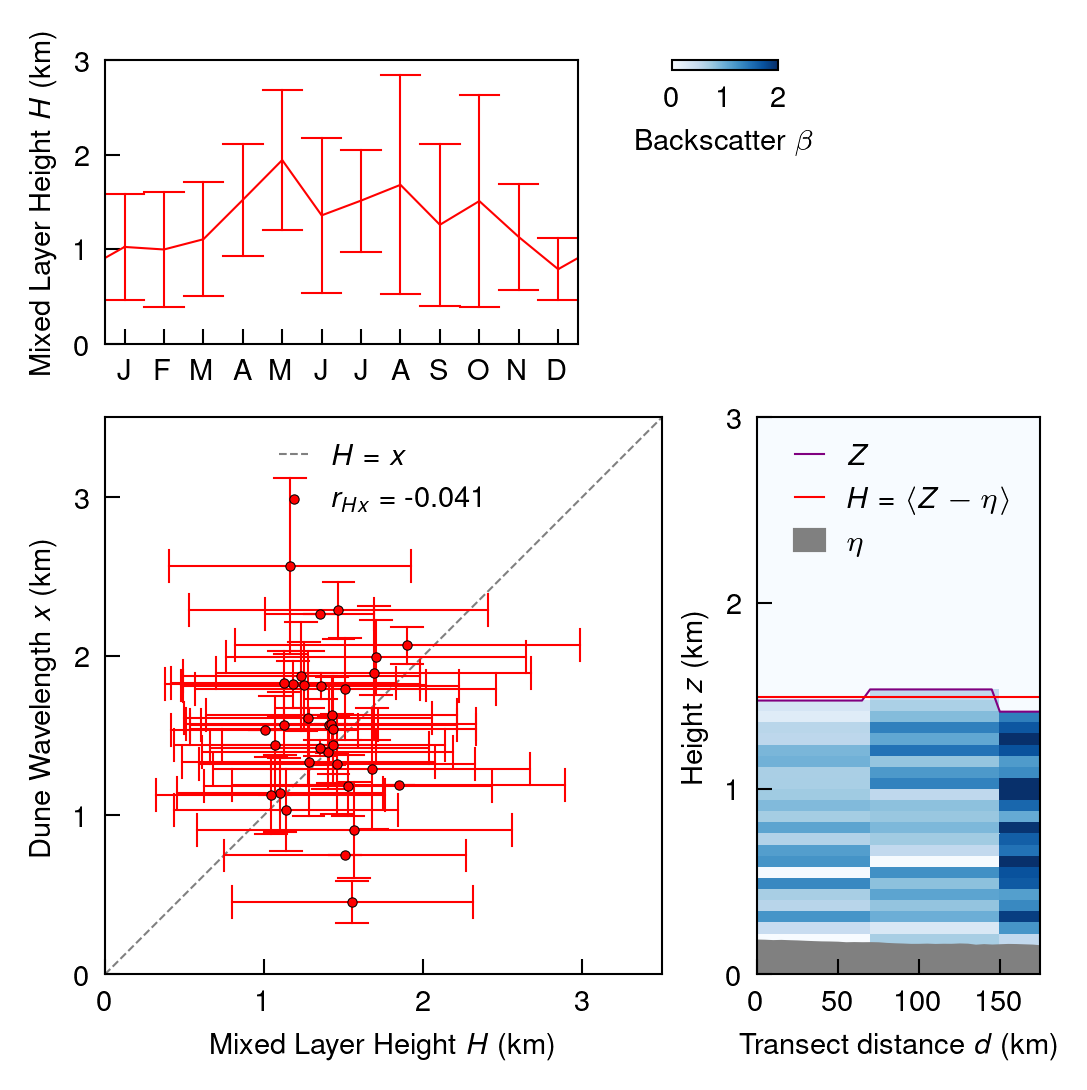

In [158]:
lw = 0.5
LW = 0.5
S = 1

fig = plt.gcf()

ax1 = fig.add_axes([0.09,0.69,0.45,0.27])
plt.plot(np.arange(12)+0.5,mlh_month_av*1e-3,'r',lw=lw)
for i in range(12):
    plt.plot([i+0.5,i+0.5],[mlh_month_av[i]*1e-3-mlh_month_sd[i]*1e-3,mlh_month_av[i]*1e-3+mlh_month_sd[i]*1e-3],c='r',lw=lw)
    plt.plot([i+0.5+0.5,i+0.5-0.5],[mlh_month_av[i]*1e-3-mlh_month_sd[i]*1e-3,mlh_month_av[i]*1e-3-mlh_month_sd[i]*1e-3],c='r',lw=lw)
    plt.plot([i+0.5+0.5,i+0.5-0.5],[mlh_month_av[i]*1e-3+mlh_month_sd[i]*1e-3,mlh_month_av[i]*1e-3+mlh_month_sd[i]*1e-3],c='r',lw=lw)
plt.plot([11.5,12.5],[mlh_month_av[11]*1e-3, mlh_month_av[0]*1e-3],'r',lw=lw)
plt.plot([-0.5,0.5],[mlh_month_av[11]*1e-3, mlh_month_av[0]*1e-3],'r',lw=lw)  
plt.ylim(0,3)
plt.xlim(0,12)
ax1.set_ylabel('Mixed Layer Height $H$ (km)',fontsize=fs)
ax1.set_xticks(np.arange(12)+0.5)
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize=fs)
ax1.set_yticks([0,1,2,3])
ax1.set_yticklabels(['$0$','$1$','$2$','$3$'],fontsize=fs)

ax2 = fig.add_axes([0.09,0.09,0.53,0.53])
ax2.plot([0,4],[0,4],'--',c='grey',lw=lw,label='$H=x$',zorder=-1)
sc2 = ax2.scatter(mlh_mean*1e-3,il_mean*1e-3,facecolor='r',s=S*5,edgecolor='k',lw=lw/2,zorder=1)
sc3 = ax2.plot([mlh_mean*1e-3,mlh_mean*1e-3], 
               [il_mean*1e-3-il_vari**0.5*1e-3,il_mean*1e-3+il_vari**0.5*1e-3],
               'r',lw=LW,zorder=-1)
sc3 = ax2.plot([mlh_mean*1e-3-mlh_vari**0.5*1e-3,mlh_mean*1e-3+mlh_vari**0.5*1e-3],
               [il_mean*1e-3,il_mean*1e-3],
               'r',lw=LW,zorder=-1)
sc3 = ax2.plot([mlh_mean*1e-3-mlh_vari**0.5*1e-3,mlh_mean*1e-3-mlh_vari**0.5*1e-3],
               [il_mean*1e-3-0.1,il_mean*1e-3+0.1],
               'r',lw=LW,zorder=-1)
sc3 = ax2.plot([mlh_mean*1e-3+mlh_vari**0.5*1e-3,mlh_mean*1e-3+mlh_vari**0.5*1e-3],
               [il_mean*1e-3-0.1,il_mean*1e-3+0.1],
               'r',lw=LW,zorder=-1)
sc3 = ax2.plot([mlh_mean*1e-3-0.1,mlh_mean*1e-3+0.1], 
               [il_mean*1e-3-il_vari**0.5*1e-3,il_mean*1e-3-il_vari**0.5*1e-3],
               'r',lw=LW,zorder=-1)
sc3 = ax2.plot([mlh_mean*1e-3-0.1,mlh_mean*1e-3+0.1], 
               [il_mean*1e-3+il_vari**0.5*1e-3,il_mean*1e-3+il_vari**0.5*1e-3],
               'r',lw=LW,zorder=-1)
ax2.scatter(-1,-1,c='r',label="$r_{Hx}$ = %.3f"%pearsonr(mlh_mean[~np.isnan(mlh_mean)],il_mean[~np.isnan(mlh_mean)])[0],
            facecolor='r',s=S*5,edgecolor='k',lw=lw/2,zorder=1)
ax2.set_xlabel('Mixed Layer Height $H$ (km)', fontsize=fs)
ax2.set_ylabel('Dune Wavelength $x$ (km)', fontsize=fs)
plt.legend(frameon=False,fontsize=fs,handlelength=2*lw,loc=9)
plt.ylim(0,3.5)
plt.xlim(0,3.5)
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(['0','1','2','3'],fontsize=fs)
ax2.set_yticks([0,1,2,3])
ax2.set_yticklabels(['0','1','2','3'],fontsize=fs)

ax3 = fig.add_axes([0.09*2+0.53,0.09,0.27,0.53])
pc1 = plt.pcolor(x*1e-3,y*1e-3,z*1e+3,vmin=0,vmax=2,cmap='Blues',rasterized=True)
plt.plot(x*1e-3,y1*1e-3,color='purple',linewidth=lw,label='$Z$')
plt.fill_between(x*1e-3,y0*1e-3,y0*0,color='grey',label='$\\eta$')
plt.plot(x*1e-3,np.mean(y1)*1e-3*np.ones_like(x),color='r',linewidth=lw,label='$H=\\langle Z-\\eta\\rangle$')
plt.legend(frameon=False,fontsize=fs,handlelength=2*lw)
plt.ylim(0,3)
plt.xlim(0,175)
ax3.set_ylabel('Height $z$ (km)',fontsize=fs)
ax3.set_xlabel('Transect distance $d$ (km)',fontsize=fs)
ax3.set_xticks([0,50,100,150])
ax3.set_xticklabels(['0','50','100','150'],fontsize=fs)
ax3.set_yticks([0,1,2,3])
ax3.set_yticklabels(['$0$','$1$','$2$','$3$'],fontsize=fs)

cbar1_ax = fig.add_axes([0.09+0.45+0.09, 0.69+0.27-0.01, 0.1, 0.01])
c1 = fig.colorbar(pc1, orientation='horizontal',cax=cbar1_ax, ticks=[0,1,2])
cbar1_ax.xaxis.set_label_position('bottom')
cbar1_ax.xaxis.set_ticks_position('bottom')
c1.set_label('Backscatter $\\beta$',fontsize=fs)
c1.ax.set_xticklabels(['$0$','$1$','$2$'],fontsize=fs)

ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)

fig.set_size_inches(89/25.4,89/25.4, forward=True)
plt.savefig('figures/fig3.pdf',dpi=600)

# Figure 4

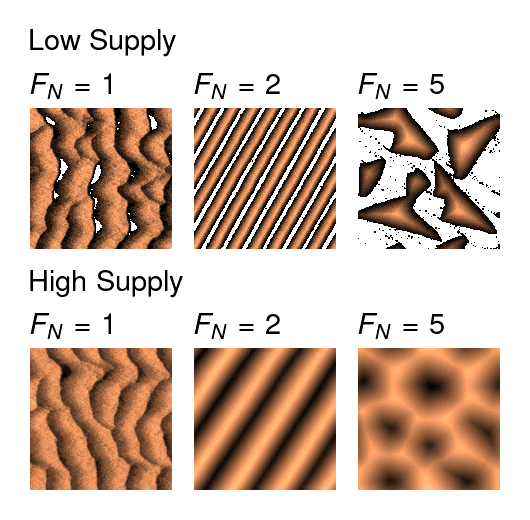

In [770]:
simulations = ["periodic-barchan-dim750-layer5",
               "periodic-barchan-dim750-layer50",
               "periodic-linear-dim750-layer5",
               "periodic-linear-dim750-layer50",
               "periodic-star-dim750-layer5",
               "periodic-star-dim750-layer50"]

j = 10000

snapshots = []
for i in range(len(simulations)):
    demzipped = "/home/andle/Documents/Python/global-dunes/rescal/" + simulations[i] + "/ALTI%.5d_t0.data.gz"%j
    f = gzip.open(demzipped, 'rb')
    file_content = f.read()
    rows = file_content.decode("utf-8").split('\n')[:-1]
    elms = [row.split(' ')[:-1] for row in rows]
    z_tile = np.asarray(elms,dtype='float')
    z_tile[z_tile<3] = np.nan
    snapshots.append(z_tile)
    


fig = plt.gcf()

ax = plt.subplot(2,3,1)
plt.pcolormesh(snapshots[0],cmap='copper')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,750*1.1,'$F_N=1$',fontsize=fs)
plt.text(0,750*1.4,'Low Supply',fontsize=fs)

ax = plt.subplot(2,3,2)
plt.pcolormesh(snapshots[2],cmap='copper')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,530*1.1,'$F_N=2$',fontsize=fs)

ax = plt.subplot(2,3,3)
plt.pcolormesh(snapshots[4],cmap='copper')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,530*1.1,'$F_N=5$',fontsize=fs)

ax = plt.subplot(2,3,4)
plt.pcolormesh(snapshots[1],cmap='copper')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,750*1.1,'$F_N=1$',fontsize=fs)
plt.text(0,750*1.4,'High Supply',fontsize=fs)

ax = plt.subplot(2,3,5)
plt.pcolormesh(snapshots[3],cmap='copper')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,530*1.1,'$F_N=2$',fontsize=fs)

ax = plt.subplot(2,3,6)
plt.pcolormesh(snapshots[5],cmap='copper')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,530*1.1,'$F_N=5$',fontsize=fs)

fig.subplots_adjust(hspace=0.7,wspace=0.1)
fig.subplots_adjust(bottom=0.02)
fig.subplots_adjust(top=0.82)
fig.subplots_adjust(right=1)
fig.subplots_adjust(left=0)

fig.set_size_inches(89/25.4/2.2,89/25.4/2.2, forward=True)
plt.savefig('figures/fig4-simsnaps.png',dpi=600)

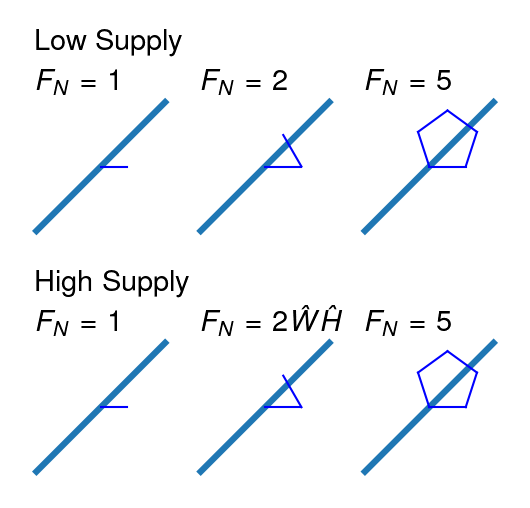

In [771]:
fig = plt.gcf()

arrowlength = 150
lw=0.5

ax = plt.subplot(2,3,1)
plt.plot([0,750],[0,750])
plt.plot([750/2,750/2+arrowlength],[750/2,750/2],lw=lw,c='b')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,750*1.1,'$F_N=1$',fontsize=fs)
plt.text(0,750*1.4,'Low Supply',fontsize=fs)

ax = plt.subplot(2,3,2)
plt.plot([0,530],[0,530])
plt.plot([530/2,530/2+arrowlength],[530/2,530/2],lw=lw,c='b')
plt.plot([530/2+arrowlength,530/2+arrowlength+np.cos(120*np.pi/180)*arrowlength],
         [530/2,530/2+np.sin(120*np.pi/180)*arrowlength],lw=lw,c='b')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,530*1.1,'$F_N=2$',fontsize=fs)

ax = plt.subplot(2,3,3)
plt.plot([0,530],[0,530])
tempx = np.empty(6)
tempy = np.empty(6)
tempx[0] = 0
tempy[0] = 0
for i in range(5):
    tempx[i+1] = np.cos(2*np.pi/5*i)*arrowlength
    tempy[i+1] = np.sin(2*np.pi/5*i)*arrowlength
for i in range(5):    
    plt.plot([530/2+np.cumsum(tempx)[i],530/2+np.cumsum(tempx)[i+1]],
             [530/2+np.cumsum(tempy)[i],530/2+np.cumsum(tempy)[i+1]],lw=lw,c='b')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,530*1.1,'$F_N=5$',fontsize=fs)

ax = plt.subplot(2,3,4)
plt.plot([0,750],[0,750])
plt.plot([750/2,750/2+arrowlength],[750/2,750/2],lw=lw,c='b')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,750*1.1,'$F_N=1$',fontsize=fs)
plt.text(0,750*1.4,'High Supply',fontsize=fs)

ax = plt.subplot(2,3,5)
plt.plot([0,530],[0,530])
plt.plot([530/2,530/2+arrowlength],[530/2,530/2],lw=lw,c='b')
plt.plot([530/2+arrowlength,530/2+arrowlength+np.cos(120*np.pi/180)*arrowlength],
         [530/2,530/2+np.sin(120*np.pi/180)*arrowlength],lw=lw,c='b')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,530*1.1,'$F_N=2 \\hat{W} \\hat{H}$',fontsize=fs)

ax = plt.subplot(2,3,6)
plt.plot([0,530],[0,530])
tempx = np.empty(6)
tempy = np.empty(6)
tempx[0] = 0
tempy[0] = 0
for i in range(5):
    tempx[i+1] = np.cos(2*np.pi/5*i)*arrowlength
    tempy[i+1] = np.sin(2*np.pi/5*i)*arrowlength
for i in range(5):    
    plt.plot([530/2+np.cumsum(tempx)[i],530/2+np.cumsum(tempx)[i+1]],
             [530/2+np.cumsum(tempy)[i],530/2+np.cumsum(tempy)[i+1]],lw=lw,c='b')
plt.axis('off')
ax.set_aspect('equal', 'box')
plt.text(0,530*1.1,'$F_N=5$',fontsize=fs)

fig.subplots_adjust(hspace=0.7,wspace=0.1)
fig.subplots_adjust(bottom=0.02)
fig.subplots_adjust(top=0.82)
fig.subplots_adjust(right=1)
fig.subplots_adjust(left=0)

fig.set_size_inches(89/25.4/2.2,89/25.4/2.2, forward=True)
plt.savefig('figures/fig4-simsnaps.pdf',dpi=300)

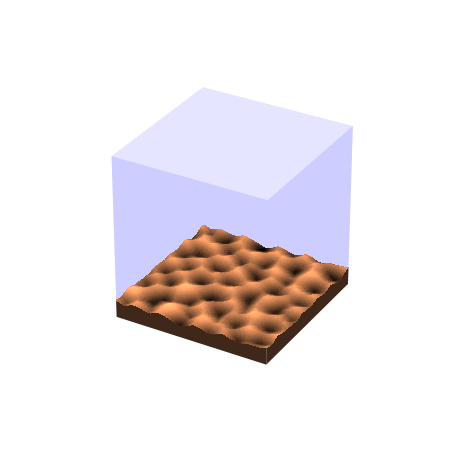

In [775]:
from matplotlib.collections import PolyCollection

def polygon_under_graph(xlist, ylist):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (xlist, ylist) line graph.  Assumes the xs are in ascending order.
    """
    return [(xlist[0], 0.), *zip(xlist, ylist), (xlist[-1], 0.)]

def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])
    
j = 1000

fig = plt.gcf()

i = 5

cval = 0.2
wallcolor = 'b'
stride=3

demzipped = "/home/andle/Documents/Python/global-dunes/rescal/" + simulations[i] + "/ALTI%.5d_t0.data.gz"%j
f = gzip.open(demzipped, 'rb')
file_content = f.read()
rows = file_content.decode("utf-8").split('\n')[:-1]
elms = [row.split(' ')[:-1] for row in rows]
z_tile = np.asarray(elms,dtype='float')
x = np.arange(np.shape(z_tile)[0])
y = np.arange(np.shape(z_tile)[1])
X,Y = np.meshgrid(x,y)

# z_tile[z_tile<3] = np.nan

ax2 = fig.gca(projection='3d')
# ax2.set_aspect('equal')    

verts = []
verts.append(polygon_under_graph(X[0], np.ones_like(X[0])*750))
poly = PolyCollection(verts, facecolors=[wallcolor], alpha=0.1)
ax2.add_collection3d(poly, zs=[np.max(X)], zdir='y')
verts = []
verts.append(polygon_under_graph(X[0], np.ones_like(X[0])*750))
poly = PolyCollection(verts, facecolors=[wallcolor], alpha=0.1)
ax2.add_collection3d(poly, zs=[np.max(Y)], zdir='x')
verts = []
verts.append(polygon_under_graph(X[0], np.ones_like(X[0])*750))
poly = PolyCollection(verts, facecolors=[wallcolor], alpha=0.1)
ax2.add_collection3d(poly, zs=[np.min(X)], zdir='y')
verts = []
verts.append(polygon_under_graph(X[0], np.ones_like(X[0])*750))
poly = PolyCollection(verts, facecolors=[wallcolor], alpha=0.1)
ax2.add_collection3d(poly, zs=[np.min(Y)], zdir='x')
verts = []

# ax2.plot_surface(X,Y,np.ones_like(X)*750, color=wallcolor, alpha=0.1)

verts = []
verts.append(polygon_under_graph(X[-1], z_tile[:,-1]))
poly = PolyCollection(verts, facecolors=[cm.copper(cval)], alpha=1)
ax2.add_collection3d(poly, zs=[np.max(Y)], zdir='x')
verts = []
verts.append(polygon_under_graph(X[0], z_tile[0]))
poly = PolyCollection(verts, facecolors=[cm.copper(cval)], alpha=1)
ax2.add_collection3d(poly, zs=[0], zdir='y')

ax2.plot_surface(X,Y,z_tile, linewidth=2, rstride=stride, cstride=stride, cmap=cm.copper, antialiased=False)

ax2.set_xticks([0,530])
ax2.set_yticks([0,530])
ax2.set_zticks([0,750])

ax2.set_axis_off()

set_axes_equal(ax2) 

fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(89/25.4/2,89/25.4/2, forward=True)
plt.savefig('figures/fig4-dunebox.png',dpi=600, transparent=True)

In [236]:
simulations = ["periodic-barchan-dim750-layer5",
               "periodic-barchan-dim750-layer50",
               "periodic-linear-dim750-layer5",
               "periodic-linear-dim750-layer50",
               "periodic-star-dim750-layer5",
               "periodic-star-dim750-layer50"]

color = ['b','c','r','m','g','y']

wavelengths = []
heights = []

for simulation in simulations:
    with open('./rescal/rescal-analysis/' + simulation + "-analysed1.pkl", 'rb') as tempfile:
        wavelength,_,_,_,height = pickle.load(tempfile)

    wavelengths.append(wavelength)
    heights.append(height)

with open("./rescal/rescal-analysis/Speed.pkl", 'rb') as tempfile:
    Speed,taulag = pickle.load(tempfile)
    
smoothx = []
smoothz = []
smoothc = []

Nsmooth = 20
twindow = np.ones(Nsmooth)/Nsmooth

for i in range(len(simulations)):
    smoothx.append(convolve(wavelengths[i],twindow,mode='same'))
    smoothz.append(convolve(heights[i],twindow,mode='same'))
    smoothc.append(convolve(Speed[i],twindow,mode='same'))
    
##
A = 3.6
B = 1.9
mu = np.tan(34*np.pi/180)
uth_on_us = 1/1.236534
global_constant = 2*np.pi*2.2*A/(B-uth_on_us**2/mu)
rho_s = 2650
rho_f = 1.225
d = 300e-6
wanum_max = 0.126

Qsat0 = 0.25032163
Qav = 12.780368 #m^2/year from ERA5
Qsat_on_Q0sat_rescal = 0.171096345514996 #for tau_1=200 read off of figure 7 narteau et al 2007

LhattoL = global_constant/(2*np.pi)*wanum_max*rho_s/rho_f*d
ThattoT = Qsat_on_Q0sat_rescal*Qsat0/Qav*LhattoL**2

Icalibraterescal = np.asarray([(750/4)/wavelengths[0][-1],
 (750/5)/wavelengths[1][-1],
 (530/7)/wavelengths[2][-1],
 (530/3)/wavelengths[3][-1],
 (530/2)/wavelengths[4][-1],
 (530/2)/wavelengths[5][-1]]).mean()

tsimx = []
tsimc = []
simtstep = 1e+2

for i in range(len(simulations)):
    smoothx[i] = smoothx[i]*LhattoL*Icalibraterescal
    smoothz[i] = smoothz[i]*LhattoL
    smoothc[i] = smoothc[i]*LhattoL/(ThattoT*simtstep)
    
    tsimx.append(np.arange(len(smoothx[i]))*simtstep*ThattoT)
    tsimc.append(np.arange(1,len(smoothc[i])+1)*simtstep*ThattoT)

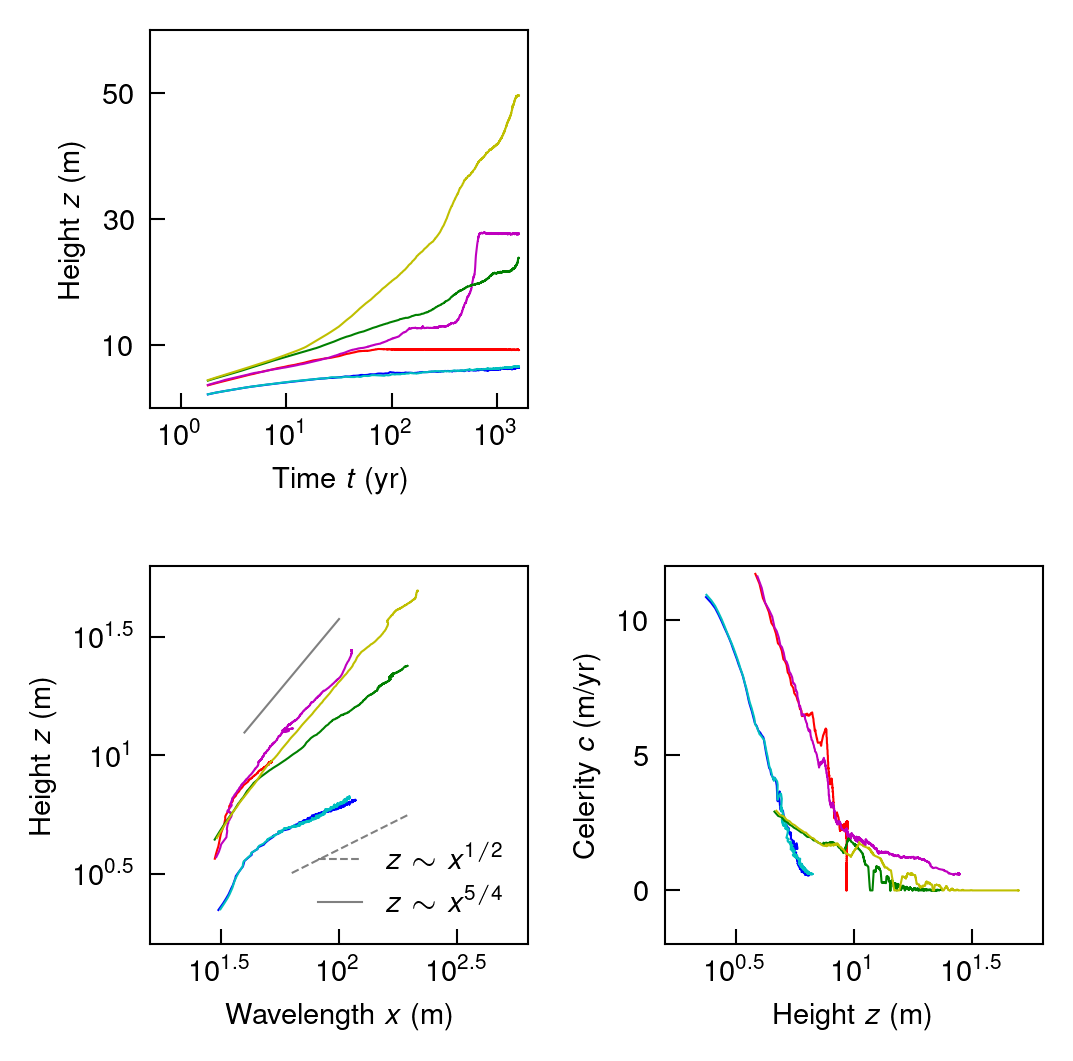

In [237]:
lw = 0.5
pwidth = 0.36

fig = plt.gcf()

ax1 = fig.add_axes([0.12,0.6,pwidth,pwidth])
for i in range(len(simulations)):
    plt.plot(tsimx[i][int(Nsmooth/2+1):-int(Nsmooth/2)],smoothz[i][int(Nsmooth/2+1):-int(Nsmooth/2)],color=color[i],lw=lw)
plt.xscale('log')
plt.xlim(10**-0.3,10**3.3)
plt.ylim(0,60)
ax1.set_xlabel('Time $t$ (yr)',fontsize=fs)
ax1.set_ylabel('Height $z$ (m)',fontsize=fs)
ax1.set_xticks([10**0,10**1,10**2,10**3])
ax1.set_xticklabels(['$10^{0}$','$10^1$','$10^{2}$','$10^3$'],fontsize=fs)
ax1.set_yticks([10,30,50])
ax1.set_yticklabels(['$10$','$30$','$50$'],fontsize=fs)
ax1.tick_params('both', width=lw, which='major')
plt.minorticks_off()

ax2 = fig.add_axes([0.12,0.09,pwidth,pwidth])
for i in range(len(simulations)):
    plt.plot(smoothx[i][int(Nsmooth/2+1):-int(Nsmooth/2)],smoothz[i][int(Nsmooth/2+1):-int(Nsmooth/2)],color=color[i],lw=lw)
tempx = np.asarray([10**1.8,10**2.3])
plt.plot(tempx,0.4*tempx**0.5,'grey',ls='--',lw=lw,label='$z \\sim x^{1/2}$')
tempx = np.asarray([10**1.6,10**2.0])
plt.plot(tempx,0.15*tempx**1.2,'grey',lw=lw,label='$z \\sim x^{5/4}$')
plt.legend(frameon=False,fontsize=fs,handlelength=lw*3)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**1.2,10**2.8)
plt.ylim(10**0.2,10**1.8)
ax2.set_xlabel('Wavelength $x$ (m)',fontsize=fs)
ax2.set_ylabel('Height $z$ (m)',fontsize=fs)
ax2.set_xticks([10**1.5,10**2,10**2.5])
ax2.set_xticklabels(['$10^{1.5}$','$10^2$','$10^{2.5}$'],fontsize=fs)
ax2.set_yticks([10**0.5,10**1,10**1.5])
ax2.set_yticklabels(['$10^{0.5}$','$10^{1}$','$10^{1.5}$'],fontsize=fs)
ax2.tick_params('both', width=lw, which='major')
plt.minorticks_off()

ax3 = fig.add_axes([0.61,0.09,pwidth,pwidth])
for i in range(len(simulations)):
    plt.plot(smoothz[i][int(Nsmooth/2+2):-int(taulag[-1]+Nsmooth/2)],smoothc[i][int(Nsmooth/2+1):-int(Nsmooth/2)],color=color[i],lw=lw)
plt.xscale('log')
plt.xlim(10**0.2,10**1.8)
plt.ylim(-2,12)
ax3.set_xlabel('Height $z$ (m)',fontsize=fs)
ax3.set_ylabel('Celerity $c$ (m/yr)',fontsize=fs)
ax3.set_xticks([10**0.5,10**1,10**1.5])
ax3.set_xticklabels(['$10^{0.5}$','$10^1$','$10^{1.5}$'],fontsize=fs)
ax3.set_yticks([0,5,10])
ax3.set_yticklabels(['$0$','$5$','$10$'],fontsize=fs)
ax3.tick_params('both', width=lw, which='major')
plt.minorticks_off()

fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(bottom=0)
fig.subplots_adjust(top=1)
fig.subplots_adjust(right=1)
fig.subplots_adjust(left=0)

ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw) 

fig.set_size_inches(89/25.4, 89/25.4, forward=True)
plt.savefig('figures/fig4-rough.pdf',dpi=300)

# Extended Data Table 1

In [1051]:
Ndunefields = 38

dfnames = ['Namib Sand Sea',
          'Grand Erg Occidental',
          'Grand Erg Oriental',
          'West Erg Issaouane',
          'East Erg Issaouane',
          'Idehan Ubari',
          'Idehan Murzuk',
          'Central Grand Sand Sea',
          'Dakhla Farafra',
          'Sinai Negev Erg',
          'An Nafud \& Ad Dahna',
          'Rub Al Khali',
          'Ramlat Al Sabatayn',
          'Wahiba Sands',
          'West Registan Desert',
          'Kharan Desert',
          'Karakum Desert',
          'Thar Desert',
          'Rig-e Jenn',
          'Rig-e Yalan',
          'East Registan Desert',
          'Southwest Takla Makan',
          'Northwest Takla Makan',
          'Central Takla Makan',
          'East Takla Makan',
          'Kumtag Desert',
          'Badain Jaran Desert',
          'Tengger Desert',
          'Ulan Buh Desert',
          'Hobp Desert',
          'Munga-Thirri',
          'Yamma Yamma',
          'Gran Desierto',
          'Ergs Iguidi \& Chech',
          'Aoukar',
          'El Djouf',
          'Azefal, Akchar \& Agneitir Sand Seas',
          'Trarza Reion Desert']

dfareas  = np.empty([np.shape(df_verts)[0]])
dflat = np.empty([np.shape(df_verts)[0]])
dflon = np.empty([np.shape(df_verts)[0]])

# here just reload all the dune field boundary coords into a list
df_verts = []
for i in np.arange(0,Ndunefields):
    with open('era-5/dunefields/df%d_verts.pkl'%i, 'rb') as f:
        df_verts.append(pickle.load(f))
        
    dflat[i] = Polygon(df_verts[i]).centroid.coords.xy[0][0]
    dflon[i] = Polygon(df_verts[i]).centroid.coords.xy[1][0]
    
# loop through dune fields
for i in np.arange(0,np.shape(df_verts)[0]):

    vertups = df_verts[i]

    #find median UTM of the lat-lon coordinates for the vertices
    utmzone = np.empty(np.shape(vertups)[0])
    for k in np.arange(0,np.shape(vertups)[0]):
        utmzone[k] = utm.from_latlon(vertups[k][1],vertups[k][0])[2]

    # transform the latlon to xy using the UTM above
    lonlat2xy = Proj(proj='utm',zone=int(np.median(utmzone)),ellps='WGS84')
    x, y = lonlat2xy(vertups[:,0], vertups[:,1])
    XY = np.asarray([x,y])

    # use shoelace formula to get the polygon area in km^2
    dfareas[i] = Polygon(XY.T).area
    
text_file = open('era-5/dunetypeids.txt', 'r')
lines = text_file.readlines()
text_file.close()

DTs = []
DTl = []
DT  = []

for i in lines:
    temp = [c for c in i[:-1]]
    if len(temp)==1:
        DT.append(temp)
        DTs.append(temp[0])
        DTl.append(temp[0])
    elif len(temp)==2:
        DT.append(temp)
        DTs.append(temp[1])
        DTl.append(temp[0])
##
##

text_file = open('era-5/era_dune_tiles.txt', 'r')
lines = text_file.readlines()
text_file.close()

ondunes = []
ondune = [0]
for i in lines:
    # some lines of the text file are ranges in tile in N-S columns
    # example 130:135 means tiles 130 through 135 (inclusive)
    if ':' in i:
        start = i.split(':')[0]
        end   = i.split(':')[1]
        end   = end[:-1]
        ondune = np.append(ondune,np.arange(int(start),int(end)+1))
    # empty line implies new dune field below
    elif '\n'==i:
        ondunes.append(ondune[1:])
        ondune = [0]
    else:
        ondune = np.append(ondune,np.asarray(int(i[:-1])))
        
##
##
# load the variable arrays in the cell above
with open('era-5/combined.pkl', 'rb') as f:
    _,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,tileno,_,_,_,_,_,_ = pickle.load(f)
##
##
    
dftype = np.zeros((Ndunefields,4))

for i in range(len(DT)):
    for j in range(len(DT[i])):
        if DT[i][j]=='b':
            for k in range(len(ondunes)):
                if np.sort(tileno)[i] in ondunes[k]:
                    dftype[k,0] += 1
        elif DT[i][j]=='t':
            for k in range(len(ondunes)):
                if np.sort(tileno)[i] in ondunes[k]:
                    dftype[k,1] += 1
        elif DT[i][j]=='l':
            for k in range(len(ondunes)):
                if np.sort(tileno)[i] in ondunes[k]:
                    dftype[k,2] += 1
        elif DT[i][j]=='s':
            for k in range(len(ondunes)):
                if np.sort(tileno)[i] in ondunes[k]:
                    dftype[k,3] += 1
                    
dfntiles = np.zeros(Ndunefields)
for k in range(len(ondunes)):
    for l in range(len(ondunes[k])):
        if len(np.where(ondunes[k][l]==tileno)[0])!=0:
            dfntiles[k] += 1

/home/andle/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [987]:
columns = ['Name','Midpoint Latitude','Midpoint Longitude','Area (km^2)','Age (Kyrs)','Number of tiles','\% Barchanoid','\% Transverse','\% Linear','\% Star']
dflat_str = ['%.1f'%i for i in dflat]
dflon_str = ['%.1f'%i for i in dflon]
dfareas_str = ['%d'%(i/1e+6) for i in dfareas]
dfages_str = ['-' for i in range(Ndunefields)]
dfntiles_str = ['%d'%i for i in dfntiles]
dfb_str = ['%d'%(i*100) for i in dftype[:,0]/np.sum(dftype,axis=1)[:,np.newaxis]]
dft_str = ['%d'%(i*100) for i in dftype[:,1]/np.sum(dftype,axis=1)[:,np.newaxis]]
dfl_str = ['%d'%(i*100) for i in dftype[:,2]/np.sum(dftype,axis=1)[:,np.newaxis]]
dfs_str = ['%d'%(i*100) for i in dftype[:,3]/np.sum(dftype,axis=1)[:,np.newaxis]]

data = np.vstack((dfnames,dflat_str,dflon_str,dfareas_str,dfages_str,dfntiles_str,dfb_str,dft_str,dfl_str,dfs_str)).T
dataframe = pd.DataFrame(data=data,columns=columns)
dataframe.to_csv('TableED1.csv',index=False)

In [1060]:
agedinds = [0,9,11,13,17,21,22,23,24,26,27,29,30,32]
'%d'%(100*np.sum(dftype[agedinds],axis=0)[3]/np.sum(dftype[agedinds]))
# np.sum(dfntiles[agedinds])

'9'

# Supplementary Table 2

In [1130]:
with open('era-5/combined.pkl', 'rb') as f:
    _,_,_,Is_M,Js_M,Zs_M,Il_M,Jl_M,Zl_M,_,_,_,_,_,_,_,_,_,tileno,_,RDP,DP,_,_,_ = pickle.load(f)

Is_M = Is_M*Icalibrate
Js_M = Js_M*Icalibrate
Zs_M = Zs_M*Zcalibrate
Il_M = Il_M*Icalibrate
Jl_M = Jl_M*Icalibrate
Zl_M = Zl_M*Zcalibrate
RDP = RDP*factor/duration
DP = DP*factor/duration

text_file = open('era-5/dunetypeids.txt', 'r')
lines = text_file.readlines()
text_file.close()

DTs = []
DTl = []
DT  = []

for i in lines:
    temp = [c for c in i[:-1]]
    if len(temp)==1:
        DT.append(temp)
        DTs.append(temp[0])
        DTl.append(temp[0])
    elif len(temp)==2:
        DT.append(temp)
        DTs.append(temp[1])
        DTl.append(temp[0])

DTlordered = []
DTsordered = []
tiledfname = []
for i in range(len(tileno)):
    DTlordered.append(DTl[np.argwhere(np.sort(tileno)==tileno[i])[0][0]])
    DTsordered.append(DTs[np.argwhere(np.sort(tileno)==tileno[i])[0][0]])
    
    for j in range(len(ondunes)):
        if tileno[i] in ondunes[j]:
            tiledfname.append(dfnames[j])
            
ds = xr.open_dataset('/home/andle/Documents/Python/circadian/DUNEPOLY_EXHAUSTIVE/200801_sea_surface_temperature.nc')
lon_era = np.asarray(ds.lon)
lat_era = np.asarray(ds.lat)
LAT_era,LON_era = np.meshgrid(lat_era,lon_era)
LON_era = np.ndarray.flatten(LON_era)
LAT_era = np.ndarray.flatten(LAT_era)
tilelat = np.empty(len(tileno))
tilelon = np.empty(len(tileno))
for i in range(len(tileno)):
    tilelat[i] = LAT_era[tileno[i]]
    tilelon[i] = LON_era[tileno[i]]

columns = ['Dune Field','Latitude','Longitude',
           'Large Type','Large Wavelength (m)','Large Width (m)','Large Height (m)',
           'Small Type','Small Wavelength (m)','Small Width (m)','Small Height (m)',
           'Mean Resultant Flux Magnitude (m^2/yr)',
           'Mean of Flux Magnitudes (m^2/yr)']

data = np.vstack((tiledfname,tilelat,tilelon,
                  DTlordered,Il_M,Jl_M,Zl_M,
                  DTsordered,Is_M,Js_M,Zs_M,
                  RDP,DP)).T
dataframe = pd.DataFrame(data=data,columns=columns)
dataframe.to_csv('TableS2.csv',index=False)

# Extended Data Figure 1

In [1453]:
# load a specific aster results for an era5 tile to display the figure in the cell below, or for something else
with open('era-5/dune_tiles1/tile_%d.pkl'%35607, 'rb') as f:
    _,LON_tile,LAT_tile,z_tile,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_ = pickle.load(f)
    
#################
#################
#################

#number of low frequency modes that are removed from the image
#this gets rid of large scale trends in the topography that definitely don't come from dunes
edgewidth = 2

#number of bins the dune height calculation is split into
zhistbins = 25

#vectors to find the long and short axis of dunes
angles = np.linspace(0,np.pi,180)
lonbase = np.cos(angles)
latbase = np.sin(angles)

#global projection, needed to find lengths in meters
p1 = Proj(init='epsg:4326', preserve_units=False)

#################
#################
#################

#make a mask to take out edgewidth-many low frequency modes
pad = np.pad(np.ones((np.shape(z_tile)[0]-2*edgewidth,np.shape(z_tile)[0]-2*edgewidth)),(edgewidth,edgewidth),mode='constant',constant_values=0)

#take the fft
z_fft   = 1/np.shape(z_tile)[1]/np.shape(z_tile)[0]*np.fft.fft2(z_tile)
z_fft_r = (z_fft.real**2+z_fft.imag**2)**0.5

#shift high modes to the middle, erase the lowest modes
z_fft_s = np.fft.fftshift(z_fft_r*pad)

#get autocorrelation of the topo data via the inverse of the fft
z_rft_s = np.fft.fftshift(np.fft.ifft2((z_fft*pad)*np.conj((z_fft*pad)))).real*np.shape(z_tile)[1]*np.shape(z_tile)[0]

#put the origin in the middle of the autcorrelation
mid_tile = int(np.shape(LON_tile)[0]/2)
LON_rft_s = LON_tile-LON_tile[mid_tile,mid_tile]
LAT_rft_s = LAT_tile-LAT_tile[mid_tile,mid_tile]

#################

#get 100 levelsets between 0 correlation and the 2nd largest autocorrelation
#use the 2nd largest, not largest, to ensure the smallest levelset is 2D
levelsets = np.linspace(0,np.sort(np.ndarray.flatten(z_rft_s))[-2],100)

#initialize diagnostics
arearatio = np.empty(100)
area = np.empty(100)
polygons = []

#use a circle mask on the autocorrelation to ensure no bias toward cardinal directions
#the mask has a diameter 2 pixels less than the image, this ensures levelsets don't have open boundaries
nicedisk = np.pad(disk((np.shape(z_rft_s)[0]-3)/2),1,mode='constant',constant_values=0)

#loop through the 100 levelset values
for j in np.arange(0,np.shape(levelsets)[0]):

    #get all the levelsets of the autocorrelation masked by a circle to ensure no bias toward cardinal directions
    cs = plt.contour(LON_rft_s,LAT_rft_s,z_rft_s*nicedisk,[levelsets[j]],colors='k')

    #find the levelset that contains the origin, i.e. the most correlated shape
    for k in range(len(cs.collections[0].get_paths())):
        if Polygon(cs.collections[0].get_paths()[k].vertices).contains(Point(0,0)):
            break

    #define it as a shape
    polygon = Polygon(cs.collections[0].get_paths()[k].vertices)

    #find the 0 correlation shape to later see how disordered or defected the dune morphology is
    if j == 0:
        zerotharea = polygon.area

    #find the ratio of the shape's convex hull area to its actual area
    arearatio[j] = polygon.convex_hull.area/polygon.area
    #store the shape area
    area[j] = polygon.area

    #store the current shape
    polygons.append(polygon)

    #clear the contour plot out of memory, important
    plt.clf()

#find the local minima of the hull to real area ratio, this shows where shapes are most convex
#these tentatively represent real dune morphologies that may be superimposed on each other
#use a local minima that has a comparison window of 2 levelsets on either side, not 1 because of noise
pks = peak_local_max(np.max(arearatio)-arearatio,min_distance=2,indices=True)
#now ensure we ignore spurious morphologies with the following conditions:
#ignore all shapes where the ratio is 1 apart from the largest area, this avoid spurious tiny morphologies
pks = np.delete(pks,np.argwhere(arearatio[pks]<1.01)[:,0][:-1])
#ignore all shapes that are not very convex, arbitrarily defined as a hull area over 10% of real 
pks = np.delete(pks,np.argwhere(arearatio[pks]>1.1))

#there may be no local minima that fit this condition because the area is decaying with larger level sets monotonically, in that case:
if (np.shape(pks)[0]==0) or (np.all(arearatio[pks]<1.01)):
    #take the largest morphology where the hull area is less than 10% of real
    pks = [np.min(np.argwhere(arearatio<1.1))]

#there are only 1 or 2 aster-observable morphologies in a tile, here ensure we have the largest and smallest ones
if np.shape(pks)[0]>2:
    pks = np.array([pks[0],pks[-1]])

#initialize the morphology info storing arrays
RI = np.empty(np.shape(pks)[0])
AI = np.empty(np.shape(pks)[0])
RJ = np.empty(np.shape(pks)[0])
AJ = np.empty(np.shape(pks)[0])
DR = np.empty(np.shape(pks)[0])
Polygons = []

#loop through the morpologies
for j in np.arange(0,np.shape(pks)[0]):    
    intx = []
    inty = []

    # loop through directions from 0 to pi
    for k in np.arange(0,np.shape(angles)[0]):
        # creat a line through the origin in the current direction
        line = LineString([(0,0),(lonbase[k],latbase[k])])

        #if there's only one intersection between the line and shape
        try:
            #store coordinates where the current line and shape intersects
            intx.append(line.intersection(polygons[pks[j]].boundary).coords.xy[0][0])
            inty.append(line.intersection(polygons[pks[j]].boundary).coords.xy[1][0])
        except:
            #if there's more than one intersection loop through them
            for l in np.arange(0,np.shape(line.intersection(polygons[pks[j]].boundary))[0]):
                intx.append(line.intersection(polygons[pks[j]].boundary)[l].coords.xy[0][0])
                inty.append(line.intersection(polygons[pks[j]].boundary)[l].coords.xy[1][0])

    #store the dune morphology
    Polygons.append(polygons[pks[j]])

    intx  = np.asarray(intx)
    inty  = np.asarray(inty)

    #find where the morphology boundary is closest to the origin
    indi  = np.argmin((intx**2+inty**2)**0.5)
    #store that 'minimal axis', the width - it's times 2 since the distance is from the origin and the shape is symmetric
    RI[j] = 2*(intx[indi]**2+inty[indi]**2)**0.5
    #store the direction of the width
    AI[j] = np.arctan2(inty[indi],intx[indi])

    #do same as above for the 'maximal axis', the length
    indj  = np.argmax((intx**2+inty**2)**0.5)
    RJ[j] = 2*(intx[indj]**2+inty[indj]**2)**0.5
    AJ[j] = np.arctan2(inty[indj],intx[indj])

    #for the current morphology find out how small it is relative to the correlated area, to see how expansive the defected area is
    DR[j] = polygons[pks[j]].area/zerotharea

#store the coordinates of the morpology lengthscales to convert to meters
I_lon = np.cos(AI)*RI
I_lat = np.sin(AI)*RI
J_lon = np.cos(AJ)*RJ
J_lat = np.sin(AJ)*RJ

#################

#initialize the meter unit lengthscales
I_meter = []
J_meter = []
Z_meter = []

#initialize the height histogram arrays
Z_hist = []
Z_bin_edges = []

#find the local UTM projection for the era5 tile, to properly convert to meters
localutm = utm.from_latlon(LAT_tile[mid_tile,mid_tile], LON_tile[mid_tile,mid_tile])[2]
#create a projection mapping
p2 = Proj(proj="utm",zone=localutm,datum='WGS84', ellps='WGS84', preserve_units=False)
#loop through the minimal lengthscales
for j in np.arange(0,np.shape(I_lon)[0]):
    #convert the lengthscale to meters from lon/lat
    X,Y = np.asarray(transform(p1,p2,LON_tile[mid_tile,mid_tile]+[0,I_lon[j]],LAT_tile[mid_tile,mid_tile]+[0,I_lat[j]]))
    I_meter.append(((X[0]-X[1])**2+(Y[0]-Y[1])**2)**0.5)

    #find the range in the real aster topography convolved by a window the size of the current minimum axis
    ztile_min    = minimum_filter(z_tile,size=(int(RI[j]/np.diff(LON_tile[0])[0]),int(RI[j]/np.diff(LON_tile[0])[0])))
    ztile_max    = maximum_filter(z_tile,size=(int(RI[j]/np.diff(LON_tile[0])[0]),int(RI[j]/np.diff(LON_tile[0])[0])))
    #if we find the most common range, it will be the best approximation of the height of that morphology, find the distribution,
    hist,bin_edges = np.histogram(ztile_max-ztile_min,bins=zhistbins)
    Z_hist.append(hist)
    Z_bin_edges.append(bin_edges)
    #store the most common height as the morphology height
    Z_meter.append(bin_edges[np.argmax(hist)]+np.diff(bin_edges)[np.argmax(hist)]/2)

#loop through the maximal lengthscales
for j in np.arange(0,np.shape(J_lon)[0]):
    X,Y = np.asarray(transform(p1,p2,LON_tile[mid_tile,mid_tile]+[0,J_lon[j]],LAT_tile[mid_tile,mid_tile]+[0,J_lat[j]]))
    J_meter.append(((X[0]-X[1])**2+(Y[0]-Y[1])**2)**0.5)

#################

/home/andle/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/andle/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-1453-5f57e5ad1016>:183: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  X,Y = np.asarray(transform(

<Figure size 1800x1200 with 0 Axes>

<ipython-input-1454-2a5c40ca5f6c>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolorm = plt.pcolormesh(LON_rft_s,LAT_rft_s,z_tile,cmap='plasma',vmin=np.min(z_tile),vmax=np.max(z_tile),rasterized=True)
<ipython-input-1454-2a5c40ca5f6c>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolorm = plt.pcolormesh(LON_rft_s,LAT_rft_s,z_rft_s, cmap='seismic',vmin=v1,vmax=-v1,rasterized=True)
<ipython-input-1454-2a5c40ca5f6c>:101: MatplotlibDeprecationWarning:

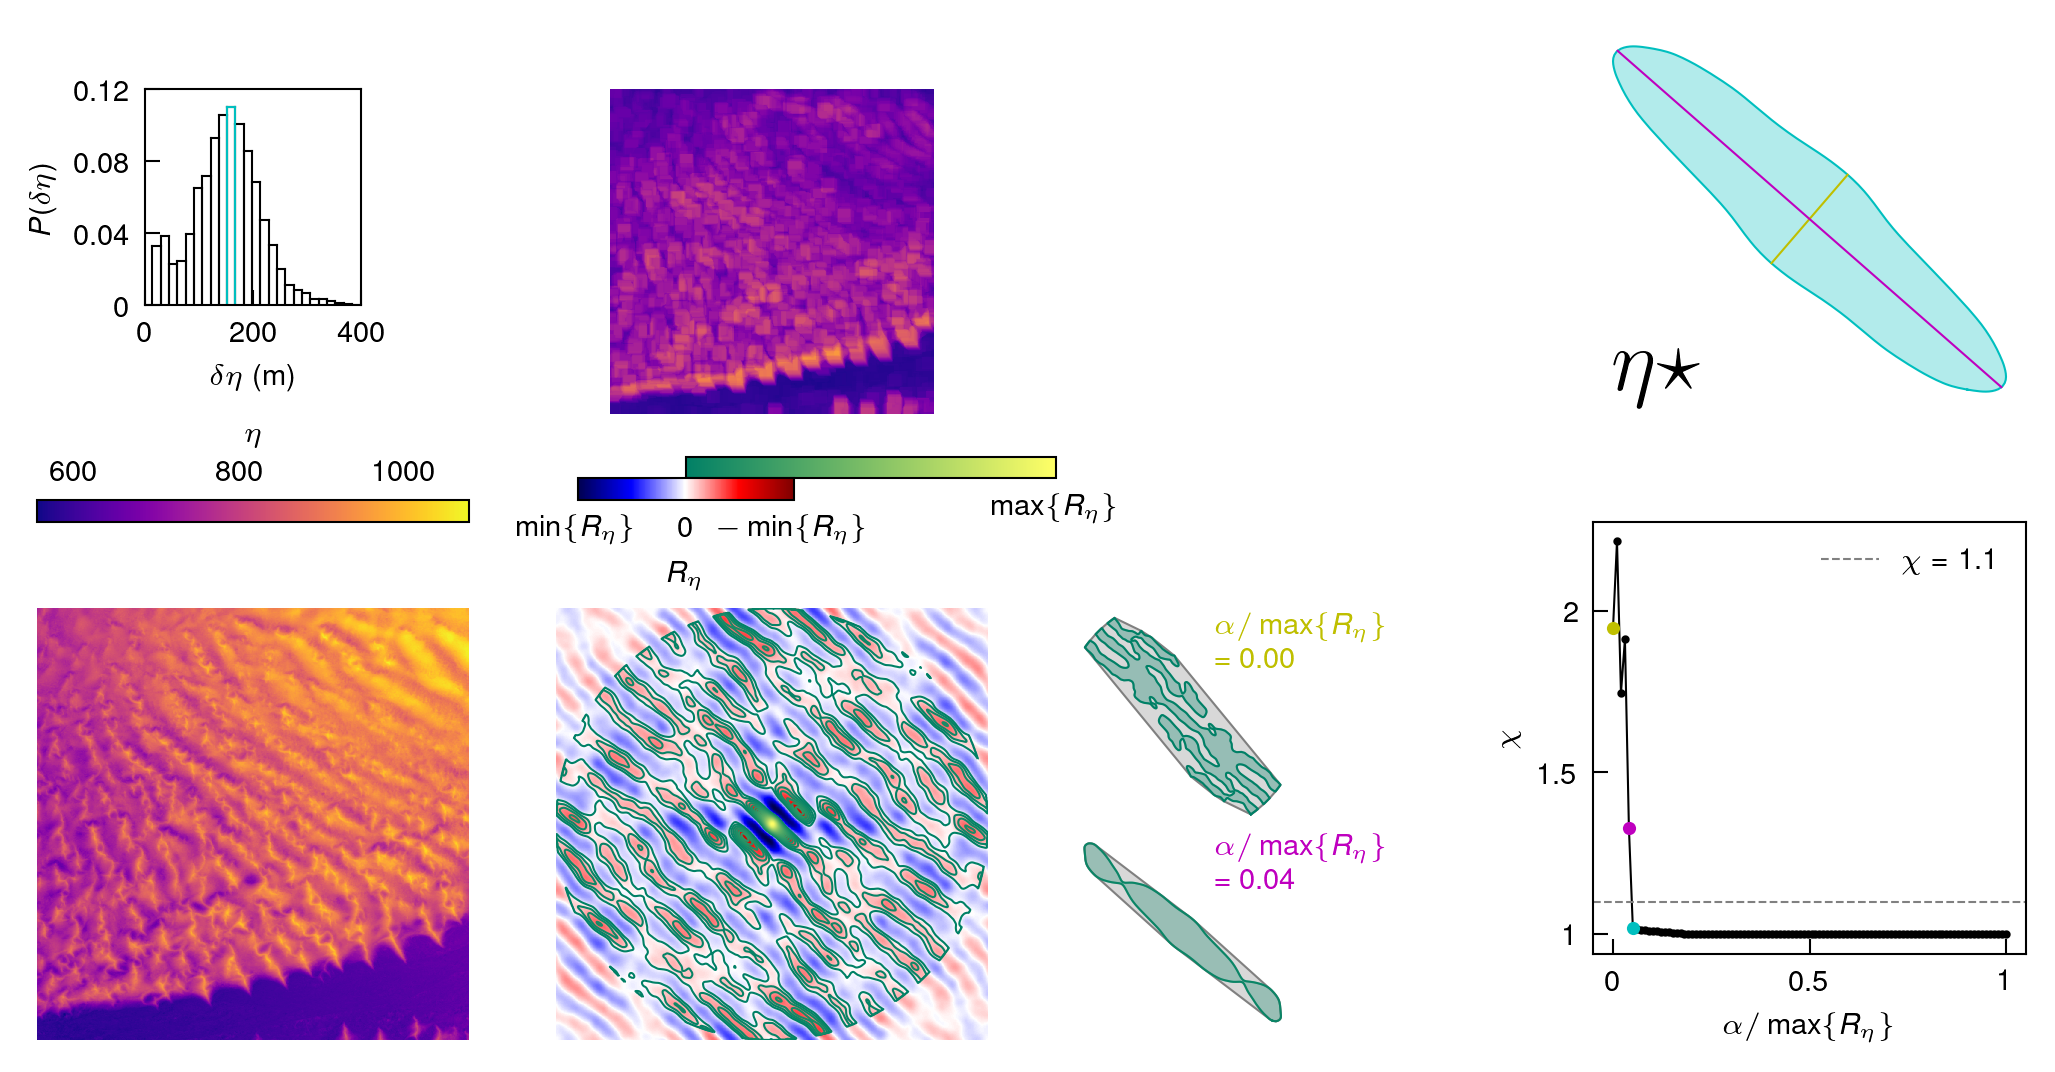

In [1454]:
fig = plt.gcf()
linecm = 'summer'
cbarwidth = 0.1
cbarx0 = 0.24
cbary0 = 0.27
tilewidth = 0.2
figspacing = 0.04


v1 = np.min(z_rft_s)

ax00 = fig.add_axes([cbarx0-tilewidth,figspacing/2,tilewidth,tilewidth])
pcolorm = plt.pcolormesh(LON_rft_s,LAT_rft_s,z_tile,cmap='plasma',vmin=np.min(z_tile),vmax=np.max(z_tile),rasterized=True)
plt.axis('equal')
plt.axis('off')
cbar0_ax = fig.add_axes([cbarx0-tilewidth,figspacing*1.5+tilewidth,tilewidth,0.01])
c0 = fig.colorbar(pcolorm, orientation='horizontal',cax=cbar0_ax, ticks=[600,800,1000])
cbar0_ax.xaxis.set_label_position('top')
cbar0_ax.xaxis.set_ticks_position('top')
c0.set_label('$\\eta$',fontsize=fs)
c0.ax.set_xticklabels(['$600$','$800$','$1000$'],fontsize=fs)
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)

ax0 = fig.add_axes([cbarx0+figspacing,figspacing/2,tilewidth,tilewidth])
contour = plt.contour(LON_rft_s,LAT_rft_s,z_rft_s/np.max(z_rft_s)*nicedisk,levelsets[::3]/np.max(z_rft_s),linewidths=lw,colors=cm.get_cmap(linecm)(levelsets[::3]/np.max(z_rft_s)))
pcolorm = plt.pcolormesh(LON_rft_s,LAT_rft_s,z_rft_s, cmap='seismic',vmin=v1,vmax=-v1,rasterized=True)
scatter = plt.scatter(0,0,s=0,c=0,vmin=0,vmax=np.max(z_rft_s),cmap=linecm)

plt.axis('equal')
plt.axis('off')

cbar2_ax = fig.add_axes([cbarx0+cbarwidth/2+0.05,cbary0+0.01,cbarwidth/2*-np.max(z_rft_s)/v1,0.01])
c2 = fig.colorbar(scatter, orientation='horizontal',cax=cbar2_ax, ticks=[np.max(z_rft_s)])
cbar2_ax.xaxis.set_label_position('bottom')
cbar2_ax.xaxis.set_ticks_position('bottom')
c2.set_label('',fontsize=fs)
c2.ax.set_xticklabels(['$\\max\{R_\\eta\}$'],fontsize=fs)
c2.ax.tick_params(width=0,which='both',direction='in')
c2.outline.set_linewidth(lw)
cbar1_ax = fig.add_axes([cbarx0+0.05,cbary0,cbarwidth,0.01])
c1 = fig.colorbar(pcolorm, orientation='horizontal',cax=cbar1_ax, ticks=[v1,0,-v1])
cbar1_ax.xaxis.set_label_position('bottom')
cbar1_ax.xaxis.set_ticks_position('bottom')
c1.set_label('$R_\\eta$',fontsize=fs)
c1.ax.set_xticklabels(['$\\min\{R_\\eta\}$','$0$','$-\\min\{R_\\eta\}$'],fontsize=fs)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)

LW = 0.5
ax1 = fig.add_axes([cbarx0+tilewidth+figspacing*2,figspacing/2,tilewidth/2,tilewidth/2])
x,y = polygons[4].convex_hull.exterior.xy
sc1 = ax1.plot(x,y, color='grey', lw=LW)
sc1 = ax1.fill(x,y, color='grey', alpha=0.3,lw=0)
x,y = polygons[4].exterior.xy
sc1 = ax1.plot(x,y, color=cm.get_cmap(linecm)(levelsets[4]/np.max(z_rft_s)), lw=LW)
sc1 = ax1.fill(x,y, color=cm.get_cmap(linecm)(levelsets[4]/np.max(z_rft_s)), alpha=0.3,lw=LW)
ax1.text(np.max(x)/3,np.max(y)/2,'$\\alpha/\\max\{R_\\eta\}$\n = %.2f'%(levelsets[4]/np.max(z_rft_s)),fontsize=fs,color='m')
ax1.set_aspect('equal', 'box')
plt.axis('off')

ax2 = fig.add_axes([cbarx0+tilewidth+figspacing*2,figspacing/2+tilewidth/2,tilewidth/2,tilewidth/2])
x,y = polygons[0].convex_hull.exterior.xy
sc1 = ax2.plot(x,y, color='grey', lw=LW)
sc1 = ax2.fill(x,y, color='grey', alpha=0.3,lw=0)
x,y = polygons[0].exterior.xy
sc1 = ax2.plot(x,y, color=cm.get_cmap(linecm)(levelsets[0]/np.max(z_rft_s)), lw=LW)
sc1 = ax2.fill(x,y, color=cm.get_cmap(linecm)(levelsets[0]/np.max(z_rft_s)), alpha=0.3,lw=LW)
ax2.text(np.max(x)/3,np.max(y)/2,'$\\alpha/\\max\{R_\\eta\}$\n = %.2f'%(levelsets[0]/np.max(z_rft_s)),fontsize=fs,color='y')
ax2.set_aspect('equal', 'box')
plt.axis('off')

ax3 = fig.add_axes([cbarx0+tilewidth*2+figspacing*3,figspacing*1.5,tilewidth,tilewidth])
ax3.scatter(levelsets[0]/levelsets[-1],arearatio[0],s=lw*20,lw=0,c='y')
ax3.scatter(levelsets[4]/levelsets[-1],arearatio[4],s=lw*20,lw=0,c='m')
ax3.scatter(levelsets[pks]/levelsets[-1],arearatio[pks],s=lw*20,lw=0,c='c')
ax3.plot(levelsets/levelsets[-1],arearatio,'-o',lw=LW,c='k',ms=lw*2,zorder=-1)
ax3.plot([-0.05,1.05],[1.1,1.1],c='grey',lw=lw,ls='--',label='$\\chi=1.1$')
plt.xlim(-0.05,1.05)
plt.legend(frameon=False,fontsize=fs)
plt.xlabel('$\\alpha/\\max\{R_\\eta\}$',fontsize=fs)
plt.ylabel('$\\chi$',fontsize=fs)
ax3.set_xticks([0,0.5,1])
ax3.set_xticklabels(['$0$','$0.5$','$1$'],fontsize=fs)
ax3.set_yticks([1,1.5,2])
ax3.set_yticklabels(['$1$','$1.5$','$2$'],fontsize=fs)

ax4 = fig.add_axes([cbarx0+tilewidth*2+figspacing*3,figspacing*2.5+tilewidth,tilewidth,tilewidth])
for i in np.arange(0,np.shape(Polygons)[0]):
    x,y = Polygons[i].exterior.xy
    sc1 = ax4.plot(x,y, color='c', lw=LW)
    sc1 = ax4.fill(x,y, color='c', alpha=0.3,lw=0)
sc2 = ax4.plot([-I_lon/2,I_lon/2],[-I_lat/2,I_lat/2],lw=LW,c='y')
sc2 = ax4.plot([-J_lon/2,J_lon/2],[-J_lat/2,J_lat/2],lw=LW,c='m')
ax4.text(np.min(x),np.min(y),'$\\eta\\star$',fontsize=fs*3)
# make sure the shapes aren't squeezed in lon or lat
ax4.set_aspect('equal', 'box')
plt.axis('off')

ax5 = fig.add_axes([cbarx0+figspacing+tilewidth*0.125,figspacing*1.5+tilewidth*1.25,tilewidth*0.75,tilewidth*0.75])
pcolorm = plt.pcolormesh(LON_rft_s,LAT_rft_s,ztile_max-ztile_min+np.min(z_tile),cmap='plasma',vmin=np.min(z_tile),vmax=np.max(z_tile),rasterized=True)
plt.axis('equal')
plt.axis('off')

ax6 = fig.add_axes([cbarx0-tilewidth+tilewidth*0.25,figspacing*1.5+tilewidth*1.5,tilewidth*0.5,tilewidth*0.5])
for i in range(len(Z_hist[0])):
    plt.plot([Z_bin_edges[0][i],Z_bin_edges[0][i]],[0,Z_hist[0][i]/np.sum(Z_hist[0])],c='k',zorder=0,lw=LW)
    plt.plot([Z_bin_edges[0][i+1],Z_bin_edges[0][i+1]],[0,Z_hist[0][i]/np.sum(Z_hist[0])],c='k',zorder=0,lw=LW)
    plt.plot([Z_bin_edges[0][i],Z_bin_edges[0][i+1]],[Z_hist[0][i]/np.sum(Z_hist[0]),Z_hist[0][i]/np.sum(Z_hist[0])],c='k',zorder=0,lw=LW)
im = np.argmax(Z_hist[0])
plt.plot([Z_bin_edges[0][im],Z_bin_edges[0][im]],[0,Z_hist[0][im]/np.sum(Z_hist[0])],c='c',zorder=1,lw=LW)
plt.plot([Z_bin_edges[0][im+1],Z_bin_edges[0][im+1]],[0,Z_hist[0][im]/np.sum(Z_hist[0])],c='c',zorder=1,lw=LW)
plt.plot([Z_bin_edges[0][im],Z_bin_edges[0][im+1]],[Z_hist[0][im]/np.sum(Z_hist[0]),Z_hist[0][im]/np.sum(Z_hist[0])],c='c',zorder=1,lw=LW)
plt.xlim(0,400)
plt.ylim(0,0.12)
plt.xlabel('$\delta\eta$ (m)',fontsize=fs)
plt.ylabel('$P(\delta\eta)$',fontsize=fs)
ax6.set_xticks([0,200,400])
ax6.set_xticklabels(['$0$','$200$','$400$'],fontsize=fs)
ax6.set_yticks([0,0.04,0.08,0.12])
ax6.set_yticklabels(['$0$','$0.04$','$0.08$','$0.12$'],fontsize=fs)

ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
ax6.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax6.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)
c2.ax.tick_params(width=0,which='both',direction='in')
c2.outline.set_linewidth(lw)

fig.set_size_inches(183/25.4, 183/25.4, forward=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('figures/rmap-ed1.pdf',dpi=600, facecolor=fig.get_facecolor(), transparent=True)

In [1455]:
# load a specific aster results for an era5 tile to display the figure in the cell below, or for something else
with open('era-5/dune_tiles1/tile_%d.pkl'%126965, 'rb') as f:
    _,LON_tile,LAT_tile,z_tile,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_ = pickle.load(f)
    
#################
#################
#################

#number of low frequency modes that are removed from the image
#this gets rid of large scale trends in the topography that definitely don't come from dunes
edgewidth = 2

#number of bins the dune height calculation is split into
zhistbins = 25

#vectors to find the long and short axis of dunes
angles = np.linspace(0,np.pi,180)
lonbase = np.cos(angles)
latbase = np.sin(angles)

#global projection, needed to find lengths in meters
p1 = Proj(init='epsg:4326', preserve_units=False)

#################
#################
#################

#make a mask to take out edgewidth-many low frequency modes
pad = np.pad(np.ones((np.shape(z_tile)[0]-2*edgewidth,np.shape(z_tile)[0]-2*edgewidth)),(edgewidth,edgewidth),mode='constant',constant_values=0)

#take the fft
z_fft   = 1/np.shape(z_tile)[1]/np.shape(z_tile)[0]*np.fft.fft2(z_tile)
z_fft_r = (z_fft.real**2+z_fft.imag**2)**0.5

#shift high modes to the middle, erase the lowest modes
z_fft_s = np.fft.fftshift(z_fft_r*pad)

#get autocorrelation of the topo data via the inverse of the fft
z_rft_s = np.fft.fftshift(np.fft.ifft2((z_fft*pad)*np.conj((z_fft*pad)))).real*np.shape(z_tile)[1]*np.shape(z_tile)[0]

#put the origin in the middle of the autcorrelation
mid_tile = int(np.shape(LON_tile)[0]/2)
LON_rft_s = LON_tile-LON_tile[mid_tile,mid_tile]
LAT_rft_s = LAT_tile-LAT_tile[mid_tile,mid_tile]

#################

#get 100 levelsets between 0 correlation and the 2nd largest autocorrelation
#use the 2nd largest, not largest, to ensure the smallest levelset is 2D
levelsets = np.linspace(0,np.sort(np.ndarray.flatten(z_rft_s))[-2],100)

#initialize diagnostics
arearatio = np.empty(100)
area = np.empty(100)
polygons = []

#use a circle mask on the autocorrelation to ensure no bias toward cardinal directions
#the mask has a diameter 2 pixels less than the image, this ensures levelsets don't have open boundaries
nicedisk = np.pad(disk((np.shape(z_rft_s)[0]-3)/2),1,mode='constant',constant_values=0)

#loop through the 100 levelset values
for j in np.arange(0,np.shape(levelsets)[0]):

    #get all the levelsets of the autocorrelation masked by a circle to ensure no bias toward cardinal directions
    cs = plt.contour(LON_rft_s,LAT_rft_s,z_rft_s*nicedisk,[levelsets[j]],colors='k')

    #find the levelset that contains the origin, i.e. the most correlated shape
    for k in range(len(cs.collections[0].get_paths())):
        if Polygon(cs.collections[0].get_paths()[k].vertices).contains(Point(0,0)):
            break

    #define it as a shape
    polygon = Polygon(cs.collections[0].get_paths()[k].vertices)

    #find the 0 correlation shape to later see how disordered or defected the dune morphology is
    if j == 0:
        zerotharea = polygon.area

    #find the ratio of the shape's convex hull area to its actual area
    arearatio[j] = polygon.convex_hull.area/polygon.area
    #store the shape area
    area[j] = polygon.area

    #store the current shape
    polygons.append(polygon)

    #clear the contour plot out of memory, important
    plt.clf()

#find the local minima of the hull to real area ratio, this shows where shapes are most convex
#these tentatively represent real dune morphologies that may be superimposed on each other
#use a local minima that has a comparison window of 2 levelsets on either side, not 1 because of noise
pks = peak_local_max(np.max(arearatio)-arearatio,min_distance=2,indices=True)
#now ensure we ignore spurious morphologies with the following conditions:
#ignore all shapes where the ratio is 1 apart from the largest area, this avoid spurious tiny morphologies
pks = np.delete(pks,np.argwhere(arearatio[pks]<1.01)[:,0][:-1])
#ignore all shapes that are not very convex, arbitrarily defined as a hull area over 10% of real 
pks = np.delete(pks,np.argwhere(arearatio[pks]>1.1))

#there may be no local minima that fit this condition because the area is decaying with larger level sets monotonically, in that case:
if (np.shape(pks)[0]==0) or (np.all(arearatio[pks]<1.01)):
    #take the largest morphology where the hull area is less than 10% of real
    pks = [np.min(np.argwhere(arearatio<1.1))]

#there are only 1 or 2 aster-observable morphologies in a tile, here ensure we have the largest and smallest ones
if np.shape(pks)[0]>2:
    pks = np.array([pks[0],pks[-1]])

#initialize the morphology info storing arrays
RI = np.empty(np.shape(pks)[0])
AI = np.empty(np.shape(pks)[0])
RJ = np.empty(np.shape(pks)[0])
AJ = np.empty(np.shape(pks)[0])
DR = np.empty(np.shape(pks)[0])
Polygons = []

#loop through the morpologies
for j in np.arange(0,np.shape(pks)[0]):    
    intx = []
    inty = []

    # loop through directions from 0 to pi
    for k in np.arange(0,np.shape(angles)[0]):
        # creat a line through the origin in the current direction
        line = LineString([(0,0),(lonbase[k],latbase[k])])

        #if there's only one intersection between the line and shape
        try:
            #store coordinates where the current line and shape intersects
            intx.append(line.intersection(polygons[pks[j]].boundary).coords.xy[0][0])
            inty.append(line.intersection(polygons[pks[j]].boundary).coords.xy[1][0])
        except:
            #if there's more than one intersection loop through them
            for l in np.arange(0,np.shape(line.intersection(polygons[pks[j]].boundary))[0]):
                intx.append(line.intersection(polygons[pks[j]].boundary)[l].coords.xy[0][0])
                inty.append(line.intersection(polygons[pks[j]].boundary)[l].coords.xy[1][0])

    #store the dune morphology
    Polygons.append(polygons[pks[j]])

    intx  = np.asarray(intx)
    inty  = np.asarray(inty)

    #find where the morphology boundary is closest to the origin
    indi  = np.argmin((intx**2+inty**2)**0.5)
    #store that 'minimal axis', the width - it's times 2 since the distance is from the origin and the shape is symmetric
    RI[j] = 2*(intx[indi]**2+inty[indi]**2)**0.5
    #store the direction of the width
    AI[j] = np.arctan2(inty[indi],intx[indi])

    #do same as above for the 'maximal axis', the length
    indj  = np.argmax((intx**2+inty**2)**0.5)
    RJ[j] = 2*(intx[indj]**2+inty[indj]**2)**0.5
    AJ[j] = np.arctan2(inty[indj],intx[indj])

    #for the current morphology find out how small it is relative to the correlated area, to see how expansive the defected area is
    DR[j] = polygons[pks[j]].area/zerotharea

#store the coordinates of the morpology lengthscales to convert to meters
I_lon = np.cos(AI)*RI
I_lat = np.sin(AI)*RI
J_lon = np.cos(AJ)*RJ
J_lat = np.sin(AJ)*RJ

#################

#initialize the meter unit lengthscales
I_meter = []
J_meter = []
Z_meter = []

#initialize the height histogram arrays
Z_hist = []
Z_bin_edges = []

#find the local UTM projection for the era5 tile, to properly convert to meters
localutm = utm.from_latlon(LAT_tile[mid_tile,mid_tile], LON_tile[mid_tile,mid_tile])[2]
#create a projection mapping
p2 = Proj(proj="utm",zone=localutm,datum='WGS84', ellps='WGS84', preserve_units=False)
#loop through the minimal lengthscales
for j in np.arange(0,np.shape(I_lon)[0]):
    #convert the lengthscale to meters from lon/lat
    X,Y = np.asarray(transform(p1,p2,LON_tile[mid_tile,mid_tile]+[0,I_lon[j]],LAT_tile[mid_tile,mid_tile]+[0,I_lat[j]]))
    I_meter.append(((X[0]-X[1])**2+(Y[0]-Y[1])**2)**0.5)

    #find the range in the real aster topography convolved by a window the size of the current minimum axis
    ztile_min    = minimum_filter(z_tile,size=(int(RI[j]/np.diff(LON_tile[0])[0]),int(RI[j]/np.diff(LON_tile[0])[0])))
    ztile_max    = maximum_filter(z_tile,size=(int(RI[j]/np.diff(LON_tile[0])[0]),int(RI[j]/np.diff(LON_tile[0])[0])))
    #if we find the most common range, it will be the best approximation of the height of that morphology, find the distribution,
    hist,bin_edges = np.histogram(ztile_max-ztile_min,bins=zhistbins)
    Z_hist.append(hist)
    Z_bin_edges.append(bin_edges)
    #store the most common height as the morphology height
    Z_meter.append(bin_edges[np.argmax(hist)]+np.diff(bin_edges)[np.argmax(hist)]/2)

#loop through the maximal lengthscales
for j in np.arange(0,np.shape(J_lon)[0]):
    X,Y = np.asarray(transform(p1,p2,LON_tile[mid_tile,mid_tile]+[0,J_lon[j]],LAT_tile[mid_tile,mid_tile]+[0,J_lat[j]]))
    J_meter.append(((X[0]-X[1])**2+(Y[0]-Y[1])**2)**0.5)

#################

/home/andle/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/andle/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-1455-5fdbfadb75e6>:183: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  X,Y = np.asarray(transform(

<Figure size 1800x1200 with 0 Axes>

<ipython-input-1463-3be68e8c8411>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolorm = plt.pcolormesh(LON_rft_s,LAT_rft_s,z_tile,cmap='plasma',vmin=np.min(z_tile),vmax=np.max(z_tile),rasterized=True)
<ipython-input-1463-3be68e8c8411>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolorm = plt.pcolormesh(LON_rft_s,LAT_rft_s,z_rft_s, cmap='seismic',vmin=v1,vmax=-v1,rasterized=True)
<ipython-input-1463-3be68e8c8411>:115: MatplotlibDeprecationWarning:

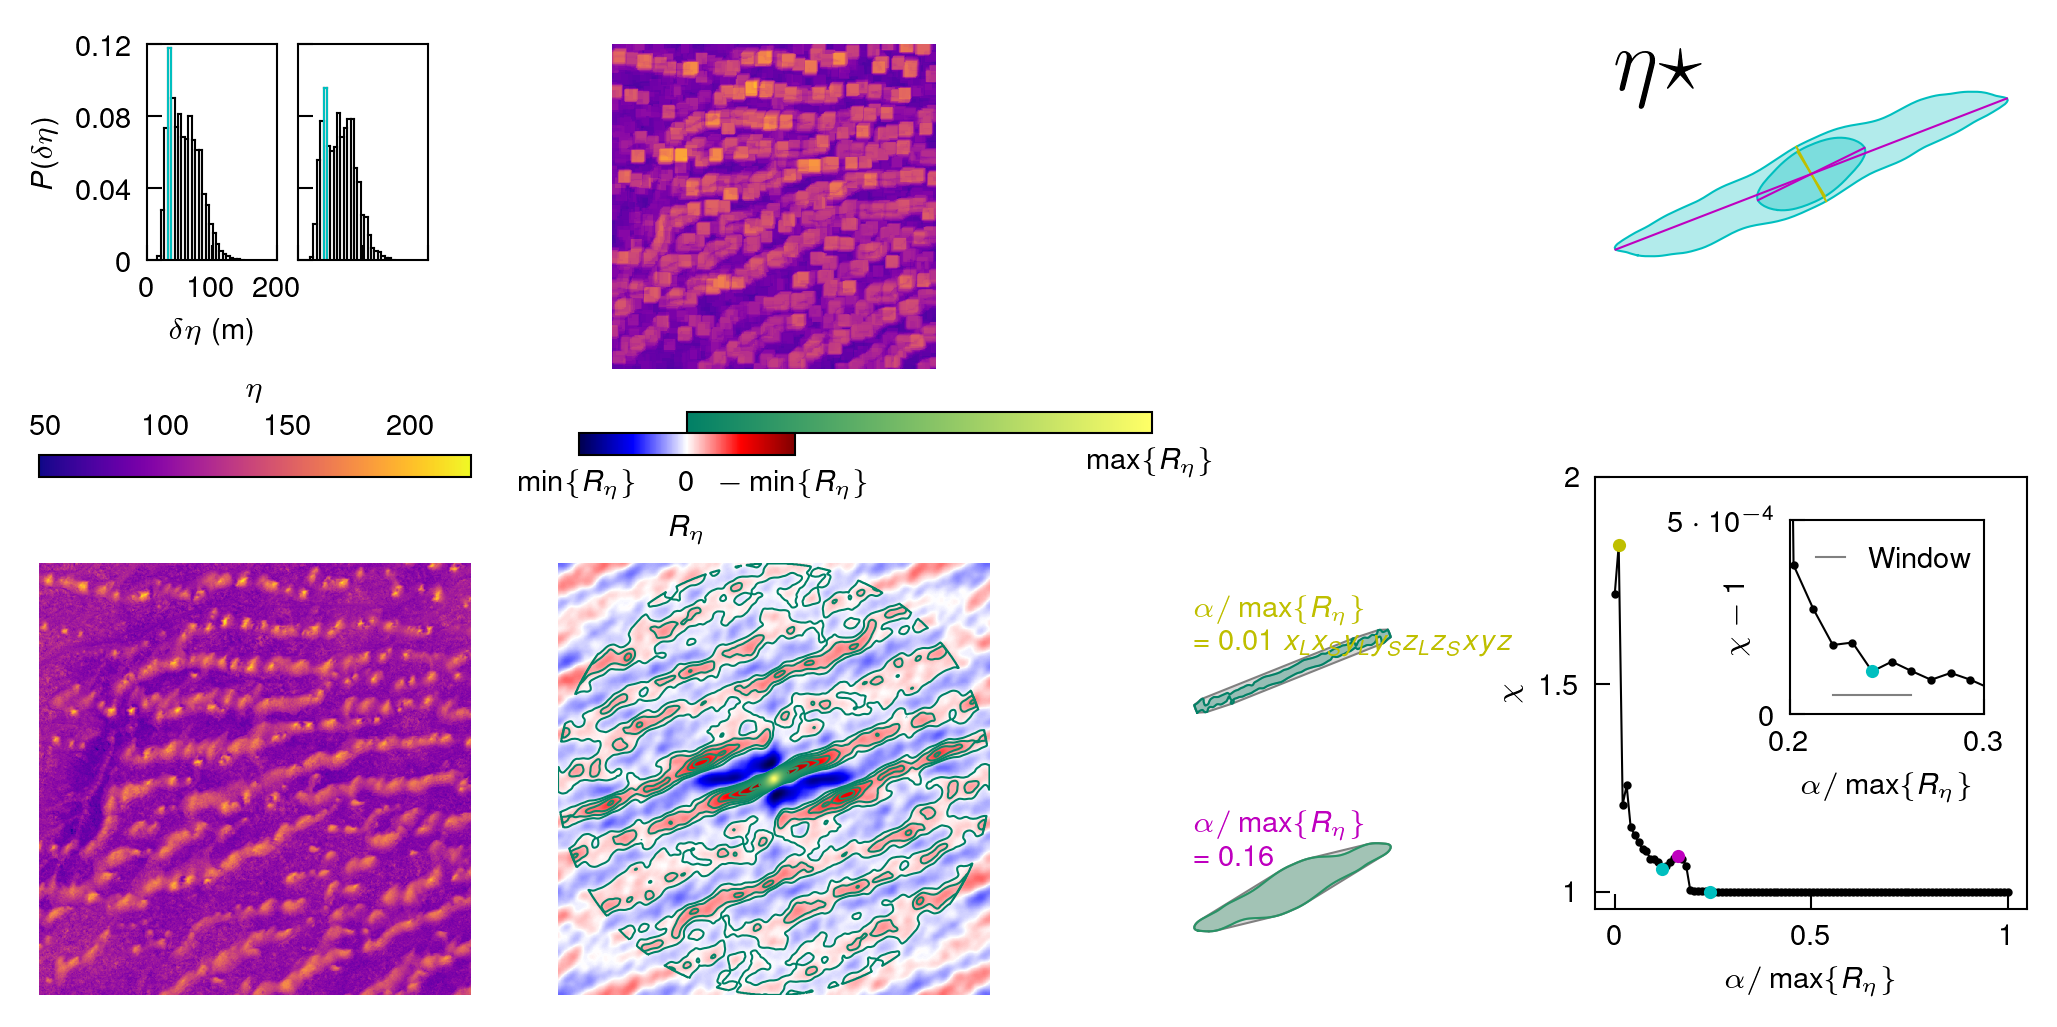

In [1463]:
fig = plt.gcf()
linecm = 'summer'
cbarwidth = 0.1
cbarx0 = 0.24
cbary0 = 0.27
tilewidth = 0.2
figspacing = 0.04

lsind0 = 1
lsind1 = 16

v1 = np.min(z_rft_s)

ax00 = fig.add_axes([cbarx0-tilewidth,figspacing/2,tilewidth,tilewidth])
pcolorm = plt.pcolormesh(LON_rft_s,LAT_rft_s,z_tile,cmap='plasma',vmin=np.min(z_tile),vmax=np.max(z_tile),rasterized=True)
plt.axis('equal')
plt.axis('off')
cbar0_ax = fig.add_axes([cbarx0-tilewidth,figspacing*1.5+tilewidth,tilewidth,0.01])
c0 = fig.colorbar(pcolorm, orientation='horizontal',cax=cbar0_ax, ticks=[50,100,150,200])
cbar0_ax.xaxis.set_label_position('top')
cbar0_ax.xaxis.set_ticks_position('top')
c0.set_label('$\\eta$',fontsize=fs)
c0.ax.set_xticklabels(['$50$','$100$','$150$','$200$'],fontsize=fs)
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)

ax0 = fig.add_axes([cbarx0+figspacing,figspacing/2,tilewidth,tilewidth])
contour = plt.contour(LON_rft_s,LAT_rft_s,z_rft_s/np.max(z_rft_s)*nicedisk,levelsets[::3]/np.max(z_rft_s),linewidths=lw,colors=cm.get_cmap(linecm)(levelsets[::3]/np.max(z_rft_s)))
pcolorm = plt.pcolormesh(LON_rft_s,LAT_rft_s,z_rft_s, cmap='seismic',vmin=v1,vmax=-v1,rasterized=True)
scatter = plt.scatter(0,0,s=0,c=0,vmin=0,vmax=np.max(z_rft_s),cmap=linecm)

plt.axis('equal')
plt.axis('off')

cbar2_ax = fig.add_axes([cbarx0+cbarwidth/2+0.05,cbary0+0.01,cbarwidth/2*-np.max(z_rft_s)/v1,0.01])
c2 = fig.colorbar(scatter, orientation='horizontal',cax=cbar2_ax, ticks=[np.max(z_rft_s)])
cbar2_ax.xaxis.set_label_position('bottom')
cbar2_ax.xaxis.set_ticks_position('bottom')
c2.set_label('',fontsize=fs)
c2.ax.set_xticklabels(['$\\max\{R_\\eta\}$'],fontsize=fs)
c2.ax.tick_params(width=0,which='both',direction='in')
c2.outline.set_linewidth(lw)
cbar1_ax = fig.add_axes([cbarx0+0.05,cbary0,cbarwidth,0.01])
c1 = fig.colorbar(pcolorm, orientation='horizontal',cax=cbar1_ax, ticks=[v1,0,-v1])
cbar1_ax.xaxis.set_label_position('bottom')
cbar1_ax.xaxis.set_ticks_position('bottom')
c1.set_label('$R_\\eta$',fontsize=fs)
c1.ax.set_xticklabels(['$\\min\{R_\\eta\}$','$0$','$-\\min\{R_\\eta\}$'],fontsize=fs)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)

LW = 0.5
ax1 = fig.add_axes([cbarx0+tilewidth*1.25+figspacing*2,figspacing/2,tilewidth/2,tilewidth/2])
x,y = polygons[lsind1].convex_hull.exterior.xy
sc1 = ax1.plot(x,y, color='grey', lw=LW)
sc1 = ax1.fill(x,y, color='grey', alpha=0.3,lw=0)
x,y = polygons[lsind1].exterior.xy
sc1 = ax1.plot(x,y, color=cm.get_cmap(linecm)(levelsets[lsind1]/np.max(z_rft_s)), lw=LW)
sc1 = ax1.fill(x,y, color=cm.get_cmap(linecm)(levelsets[lsind1]/np.max(z_rft_s)), alpha=0.3,lw=LW)
ax1.text(np.min(x),np.max(y)/2,'$\\alpha/\\max\{R_\\eta\}$\n = %.2f'%(levelsets[lsind1]/np.max(z_rft_s)),fontsize=fs,color='m')
ax1.set_aspect('equal', 'box')
plt.axis('off')

ax2 = fig.add_axes([cbarx0+tilewidth*1.25+figspacing*2,figspacing/2+tilewidth/2,tilewidth/2,tilewidth/2])
x,y = polygons[lsind0].convex_hull.exterior.xy
sc1 = ax2.plot(x,y, color='grey', lw=LW)
sc1 = ax2.fill(x,y, color='grey', alpha=0.3,lw=0)
x,y = polygons[lsind0].exterior.xy
sc1 = ax2.plot(x,y, color=cm.get_cmap(linecm)(levelsets[lsind0]/np.max(z_rft_s)), lw=LW)
sc1 = ax2.fill(x,y, color=cm.get_cmap(linecm)(levelsets[lsind0]/np.max(z_rft_s)), alpha=0.3,lw=LW)
ax2.text(np.min(x),np.max(y)/2,'$\\alpha/\\max\{R_\\eta\}$\n = %.2f $x_L x_S y_L y_S z_L z_S x y z$'%(levelsets[lsind0]/np.max(z_rft_s)),fontsize=fs,color='y')
ax2.set_aspect('equal', 'box')
plt.axis('off')

ax3 = fig.add_axes([cbarx0+tilewidth*2+figspacing*3,figspacing*1.5,tilewidth,tilewidth])
ax3.scatter(levelsets[lsind0]/levelsets[-1],arearatio[lsind0],s=lw*20,lw=0,c='y')
ax3.scatter(levelsets[lsind1]/levelsets[-1],arearatio[lsind1],s=lw*20,lw=0,c='m')
ax3.scatter(levelsets[pks]/levelsets[-1],arearatio[pks],s=lw*20,lw=0,c='c')
ax3.plot(levelsets/levelsets[-1],arearatio,'-o',lw=LW,c='k',ms=lw*2,zorder=-1)
plt.xlim(-0.05,1.05)
plt.xlabel('$\\alpha/\\max\{R_\\eta\}$',fontsize=fs)
plt.ylabel('$\\chi$',fontsize=fs)
ax3.set_xticks([0,0.5,1])
ax3.set_xticklabels(['$0$','$0.5$','$1$'],fontsize=fs)
ax3.set_yticks([1,1.5,2])
ax3.set_yticklabels(['$1$','$1.5$','$2$'],fontsize=fs)

ax31 = fig.add_axes([cbarx0+tilewidth*2+figspacing*3+tilewidth*0.45,figspacing*1.5+tilewidth*0.45,tilewidth*0.45,tilewidth*0.45])
ax31.scatter(levelsets[pks]/levelsets[-1],arearatio[pks],s=lw*20,lw=0,c='c')
ax31.plot(levelsets/levelsets[-1],arearatio,'-o',lw=LW,c='k',ms=lw*2,zorder=-1)
ax31.plot([levelsets[pks[0]-2]/levelsets[-1],levelsets[pks[0]+2]/levelsets[-1]],[1.00005,1.00005],lw=LW,c='grey',label='Window')
plt.xlim(0.2,0.3)
plt.ylim(1,1.0005)
plt.legend(frameon=False,handlelength=2*lw,fontsize=fs)
plt.xlabel('$\\alpha/\\max\{R_\\eta\}$',fontsize=fs)
plt.ylabel('$\\chi-1$',labelpad=-20,fontsize=fs)
ax31.set_xticks([0.2,0.3])
ax31.set_xticklabels(['$0.2$','$0.3$'],fontsize=fs)
ax31.set_yticks([1,1.0005])
ax31.set_yticklabels(['$0$','$5\\cdot10^{-4}$'],fontsize=fs)

ax4 = fig.add_axes([cbarx0+tilewidth*2+figspacing*3,figspacing*2.5+tilewidth,tilewidth,tilewidth])
for i in np.arange(0,np.shape(Polygons)[0]):
    x,y = Polygons[i].exterior.xy
    sc1 = ax4.plot(x,y, color='c', lw=LW)
    sc1 = ax4.fill(x,y, color='c', alpha=0.3,lw=0)
sc2 = ax4.plot([-I_lon/2,I_lon/2],[-I_lat/2,I_lat/2],lw=LW,c='y')
sc2 = ax4.plot([-J_lon/2,J_lon/2],[-J_lat/2,J_lat/2],lw=LW,c='m')
ax4.text(np.min(x),np.max(y),'$\\eta\\star$',fontsize=fs*3)
# make sure the shapes aren't squeezed in lon or lat
ax4.set_aspect('equal', 'box')
plt.axis('off')

ax5 = fig.add_axes([cbarx0+figspacing+tilewidth*0.125,figspacing*1.5+tilewidth*1.25,tilewidth*0.75,tilewidth*0.75])
pcolorm = plt.pcolormesh(LON_rft_s,LAT_rft_s,ztile_max-ztile_min+np.min(z_tile),cmap='plasma',vmin=np.min(z_tile),vmax=np.max(z_tile),rasterized=True)
plt.axis('equal')
plt.axis('off')

ax6 = fig.add_axes([cbarx0-tilewidth+tilewidth*0.25,figspacing*1.5+tilewidth*1.5,tilewidth*0.3,tilewidth*0.5])
for i in range(len(Z_hist[0])):
    plt.plot([Z_bin_edges[0][i],Z_bin_edges[0][i]],[0,Z_hist[0][i]/np.sum(Z_hist[0])],c='k',zorder=0,lw=LW)
    plt.plot([Z_bin_edges[0][i+1],Z_bin_edges[0][i+1]],[0,Z_hist[0][i]/np.sum(Z_hist[0])],c='k',zorder=0,lw=LW)
    plt.plot([Z_bin_edges[0][i],Z_bin_edges[0][i+1]],[Z_hist[0][i]/np.sum(Z_hist[0]),Z_hist[0][i]/np.sum(Z_hist[0])],c='k',zorder=0,lw=LW)
im = np.argmax(Z_hist[0])
plt.plot([Z_bin_edges[0][im],Z_bin_edges[0][im]],[0,Z_hist[0][im]/np.sum(Z_hist[0])],c='c',zorder=1,lw=LW)
plt.plot([Z_bin_edges[0][im+1],Z_bin_edges[0][im+1]],[0,Z_hist[0][im]/np.sum(Z_hist[0])],c='c',zorder=1,lw=LW)
plt.plot([Z_bin_edges[0][im],Z_bin_edges[0][im+1]],[Z_hist[0][im]/np.sum(Z_hist[0]),Z_hist[0][im]/np.sum(Z_hist[0])],c='c',zorder=1,lw=LW)
plt.xlim(0,200)
plt.ylim(0,0.12)
plt.xlabel('$\delta\eta$ (m)',fontsize=fs)
plt.ylabel('$P(\delta\eta)$',fontsize=fs)
ax6.set_xticks([0,100,200])
ax6.set_xticklabels(['$0$','$100$','$200$'],fontsize=fs)
ax6.set_yticks([0,0.04,0.08,0.12])
ax6.set_yticklabels(['$0$','$0.04$','$0.08$','$0.12$'],fontsize=fs)

ax7 = fig.add_axes([cbarx0-tilewidth+tilewidth*0.55+0.01,figspacing*1.5+tilewidth*1.5,tilewidth*0.3,tilewidth*0.5])
for i in range(len(Z_hist[1])):
    plt.plot([Z_bin_edges[1][i],Z_bin_edges[1][i]],[0,Z_hist[1][i]/np.sum(Z_hist[1])],c='k',zorder=0,lw=LW)
    plt.plot([Z_bin_edges[1][i+1],Z_bin_edges[1][i+1]],[0,Z_hist[1][i]/np.sum(Z_hist[1])],c='k',zorder=0,lw=LW)
    plt.plot([Z_bin_edges[1][i],Z_bin_edges[1][i+1]],[Z_hist[1][i]/np.sum(Z_hist[1]),Z_hist[1][i]/np.sum(Z_hist[1])],c='k',zorder=0,lw=LW)
im = np.argmax(Z_hist[1])
plt.plot([Z_bin_edges[1][im],Z_bin_edges[1][im]],[0,Z_hist[1][im]/np.sum(Z_hist[1])],c='c',zorder=1,lw=LW)
plt.plot([Z_bin_edges[1][im+1],Z_bin_edges[1][im+1]],[0,Z_hist[1][im]/np.sum(Z_hist[1])],c='c',zorder=1,lw=LW)
plt.plot([Z_bin_edges[1][im],Z_bin_edges[1][im+1]],[Z_hist[1][im]/np.sum(Z_hist[1]),Z_hist[1][im]/np.sum(Z_hist[1])],c='c',zorder=1,lw=LW)
plt.xlim(0,200)
plt.ylim(0,0.12)
plt.xlabel('',fontsize=fs)
plt.ylabel('',fontsize=fs)
ax7.set_xticks([0,100,200])
ax7.set_xticklabels(['','',''],fontsize=fs)
ax7.set_yticks([0,0.04,0.08,0.12])
ax7.set_yticklabels(['','','',''],fontsize=fs)

ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
ax31.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax31.spines[axis].set_linewidth(lw)
ax6.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax6.spines[axis].set_linewidth(lw)
ax7.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax7.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)
c2.ax.tick_params(width=0,which='both',direction='in')
c2.outline.set_linewidth(lw)

fig.set_size_inches(183/25.4, 183/25.4, forward=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('figures/rmap-ed2.pdf',dpi=600, facecolor=fig.get_facecolor(), transparent=True)

# Movie S1

In [1536]:
simulations = ["periodic-barchan-dim750-layer5",
               "periodic-barchan-dim750-layer50",
               "periodic-linear-dim750-layer5",
               "periodic-linear-dim750-layer50",
               "periodic-star-dim750-layer5",
               "periodic-star-dim750-layer50"]

fspacing = 0.02
fwidth = 0.3

for j in range(10000+1):

    snapshots = []
    for i in range(len(simulations)):
        demzipped = "/home/andle/Documents/Python/global-dunes/rescal/" + simulations[i] + "/ALTI%.5d_t0.data.gz"%j
        f = gzip.open(demzipped, 'rb')
        file_content = f.read()
        rows = file_content.decode("utf-8").split('\n')[:-1]
        elms = [row.split(' ')[:-1] for row in rows]
        z_tile = np.asarray(elms,dtype='float')
        z_tile[z_tile<3] = np.nan
        snapshots.append(z_tile)



    fig = plt.gcf()

    ax = fig.add_axes((fspacing,0.5+fspacing*3,fwidth,fwidth))
    plt.pcolormesh(snapshots[0]*LhattoL,cmap='copper')
    plt.axis('off')
    ax.set_aspect('equal', 'box')
    plt.text(0,-750*0.1,'%d'%(np.nanmin(snapshots[0])*LhattoL),fontsize=fs,color='b')
    plt.text(750,-750*0.1,'%d'%(np.nanmax(snapshots[0])*LhattoL),ha='right',fontsize=fs,color='b')
    plt.text(0,750*1.1,'$F_N=1$',fontsize=fs,color='b')
    plt.text(0,750*1.3,'Low Supply',fontsize=fs)
    plt.text(750*2.3,750*1.3,'$t = %.1f$ yrs'%(j*simtstep*ThattoT),fontsize=fs)

    ax = fig.add_axes((fspacing*2+fwidth*(1+(750-530)/750/2),0.5+fspacing*3+fwidth*((750-530)/750/2),fwidth*(530/750),fwidth*(530/750)))
    plt.pcolormesh(snapshots[2]*LhattoL,cmap='copper')
    plt.axis('off')
    ax.set_aspect('equal', 'box')
    plt.text(0,-530*0.15,'%d'%(np.nanmin(snapshots[2])*LhattoL),fontsize=fs,color='r')
    plt.text(530,-530*0.15,'%d'%(np.nanmax(snapshots[2])*LhattoL),ha='right',fontsize=fs,color='r')
    plt.text(0,530*1.1,'$F_N=2$',fontsize=fs,color='r')

    ax = fig.add_axes((fspacing*3+fwidth*(2+(750-530)/750/2),0.5+fspacing*3+fwidth*((750-530)/750/2),fwidth*(530/750),fwidth*(530/750)))
    plt.pcolormesh(snapshots[4]*LhattoL,cmap='copper')
    plt.axis('off')
    ax.set_aspect('equal', 'box')
    plt.text(0,-530*0.15,'%d'%(np.nanmin(snapshots[4])*LhattoL),fontsize=fs,color='g')
    plt.text(530,-530*0.15,'%d'%(np.nanmax(snapshots[4])*LhattoL),ha='right',fontsize=fs,color='g')
    plt.text(0,530*1.1,'$F_N=5$',fontsize=fs,color='g')

    ax = fig.add_axes((fspacing,fspacing*3,fwidth,fwidth))
    plt.pcolormesh(snapshots[1]*LhattoL,cmap='copper')
    plt.axis('off')
    ax.set_aspect('equal', 'box')
    plt.text(0,-750*0.1,'%d'%(np.nanmin(snapshots[1])*LhattoL),fontsize=fs,color='c')
    plt.text(750,-750*0.1,'%d'%(np.nanmax(snapshots[1])*LhattoL),ha='right',fontsize=fs,color='c')
    plt.text(0,750*1.1,'$F_N=1$',fontsize=fs,color='c')
    plt.text(0,750*1.3,'High Supply',fontsize=fs)

    ax = fig.add_axes((fspacing*2+fwidth*(1+(750-530)/750/2),fspacing*3+fwidth*((750-530)/750/2),fwidth*(530/750),fwidth*(530/750)))
    plt.pcolormesh(snapshots[3]*LhattoL,cmap='copper')
    plt.axis('off')
    ax.set_aspect('equal', 'box')
    plt.text(0,-530*0.15,'%d'%(np.nanmin(snapshots[3])*LhattoL),fontsize=fs,color='m')
    plt.text(530,-530*0.15,'%d'%(np.nanmax(snapshots[3])*LhattoL),ha='right',fontsize=fs,color='m')
    plt.text(0,530*1.1,'$F_N=2$',fontsize=fs,color='m')

    ax = fig.add_axes((fspacing*3+fwidth*(2+(750-530)/750/2),fspacing*3+fwidth*((750-530)/750/2),fwidth*(530/750),fwidth*(530/750)))
    pcm = plt.pcolormesh(snapshots[5]*LhattoL,cmap='copper')
    plt.axis('off')
    ax.set_aspect('equal', 'box')
    plt.text(0,-530*0.15,'%d'%(np.nanmin(snapshots[5])*LhattoL),fontsize=fs,color='y')
    plt.text(530,-530*0.15,'%d'%(np.nanmax(snapshots[5])*LhattoL),ha='right',fontsize=fs,color='y')
    plt.text(0,530*1.1,'$F_N=5$',fontsize=fs,color='y')

    cbar2_ax = fig.add_axes((fspacing*3+fwidth*(2+(750-530)/750/2),0.39+fspacing*3+fwidth*((750-530)/750/2),fwidth*(530/750),0.02))
    c2 = fig.colorbar(pcm, orientation='horizontal',cax=cbar2_ax, ticks=[np.nanmin(snapshots[5])*LhattoL,np.nanmax(snapshots[5])*LhattoL])
    cbar2_ax.xaxis.set_label_position('bottom')
    cbar2_ax.xaxis.set_ticks_position('bottom')
    c2.set_label('Elevation $\\eta$ (m)',fontsize=fs)
    c2.ax.set_xticklabels(['$\\min\{\\eta\}$','$\\max\{\\eta\}$'],fontsize=fs)
    c2.ax.tick_params(width=0,which='both',direction='in')
    c2.outline.set_linewidth(lw)

    fig.subplots_adjust(bottom=0)
    fig.subplots_adjust(top=1)
    fig.subplots_adjust(right=1)
    fig.subplots_adjust(left=0)

    fig.set_size_inches(89/25.4,89/25.4, forward=True)
    plt.savefig('figures/movie-frames/movie_%05d.png'%j,dpi=300)

    #clear the contour plot out of memory, important
    plt.clf()
    
    print(j,end='\r')

<Figure size 1051.18x1051.18 with 0 Axes>

## First crop the outputted frames so the codec will work like so:

    ffmpeg -i movie_%05d.png -vf "crop=1050:1050:0:0" cmovie_%05d.png
    

## Then run this command to turn the cropped images into a movie:

    ffmpeg -r 60 -f image2 -s 1050x1050 -i cmovie_%05d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p test.mp4
    
    

# Extended Data Figure 2

In [4]:
ca_av = np.asarray(pd.read_csv('calipso/mlh_compare.csv',header=0).iloc[:,1])
ca_st = np.asarray(pd.read_csv('calipso/mlh_compare.csv',header=0).iloc[:,2])
st_av = np.asarray(pd.read_csv('calipso/mlh_compare.csv',header=0).iloc[:,3])

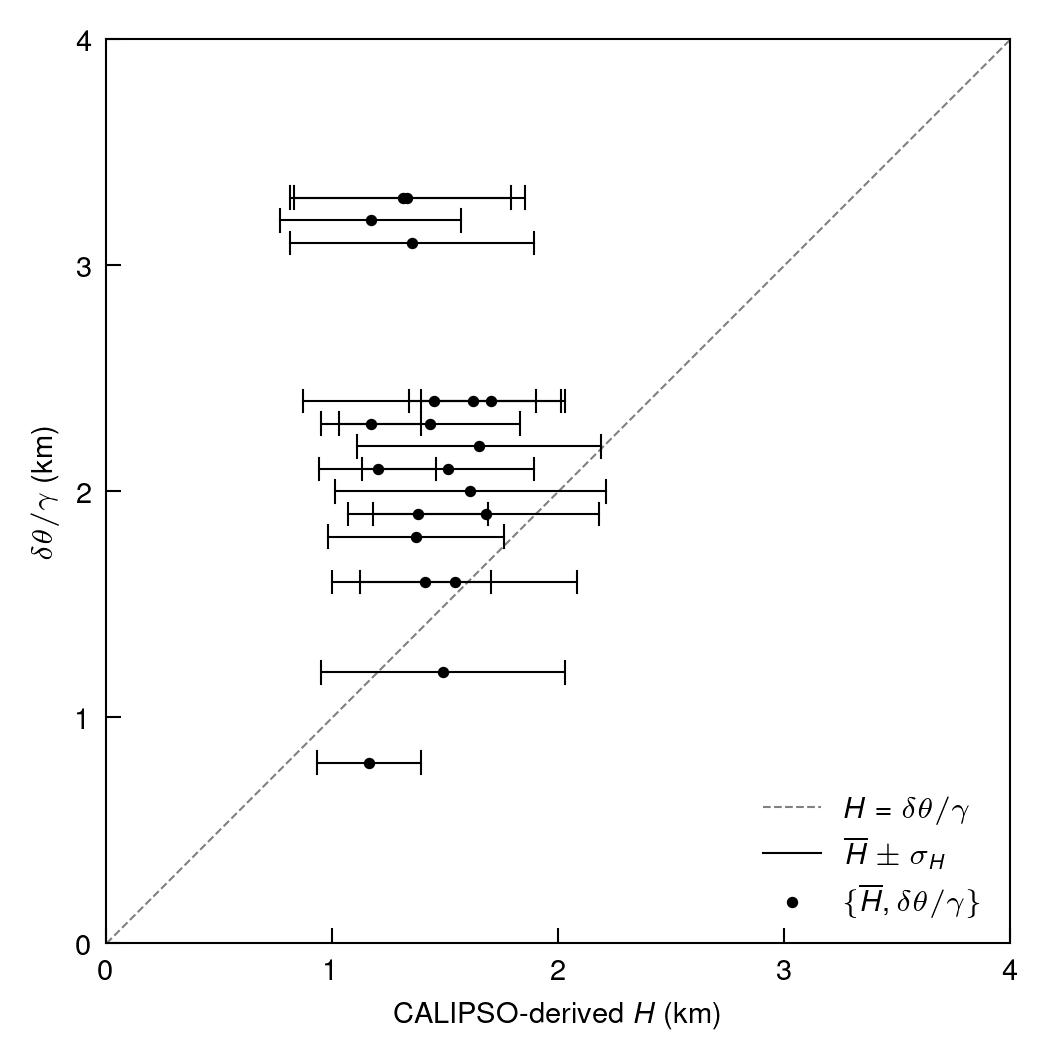

In [33]:
lw = 0.5
S = 3
endlength = 0.1

fig = plt.gcf()

ax1 = plt.subplot(111)
plt.plot([0,4],[0,4],c='grey',ls='--',lw=lw,label='$H=\\delta\\theta/\\gamma$')
plt.scatter(ca_av,st_av,s=S,c='k',label='$\{\\overline{H},\\delta\\theta/\\gamma\}$')
for i in range(len(ca_av)):
    plt.plot([ca_av[i]-ca_st[i],ca_av[i]+ca_st[i]],[st_av[i],st_av[i]],lw=lw,c='k')
    plt.plot([ca_av[i]-ca_st[i],ca_av[i]-ca_st[i]],[st_av[i]-endlength/2,st_av[i]+endlength/2],lw=lw,c='k')
    plt.plot([ca_av[i]+ca_st[i],ca_av[i]+ca_st[i]],[st_av[i]-endlength/2,st_av[i]+endlength/2],lw=lw,c='k')
plt.plot(-1,1,c='k',lw=lw,label='$\\overline{H}\pm\\sigma_H$')
plt.xlim(0,4)
plt.ylim(0,4)
plt.legend(frameon=False,fontsize=fs)
ax1.set_xlabel('CALIPSO-derived $H$ (km)',fontsize=fs)
ax1.set_ylabel('$\delta\\theta/\gamma$ (km)',fontsize=fs)
ax1.set_xticks([0,1,2,3,4])
ax1.set_xticklabels(['$0$','$1$','$2$','$3$','$4$'],fontsize=fs)
ax1.set_yticks([0,1,2,3,4])
ax1.set_yticklabels(['$0$','$1$','$2$','$3$','$4$'],fontsize=fs)
ax1.tick_params('both', width=lw, which='major')
plt.minorticks_off()
ax1.set_aspect('equal', 'box')

ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 

fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(top=0.96)
fig.subplots_adjust(right=1)
fig.subplots_adjust(left=0.05)

fig.set_size_inches(89/25.4, 89/25.4, forward=True)
plt.savefig('figures/edfig2.png',dpi=300)

# Extended Data Figure 3

In [40]:
rho_s = 2650
rho_f = 1.225
d = 300e-6
A = 3.6
B = 1.9
mu = np.tan(34*np.pi/180)
uth_on_us = 1/1.236534
global_constant = 2*np.pi*A/(B-uth_on_us**2/mu)
lambdar = global_constant*2.2*rho_s/rho_f*d
print(lambdar)

34.711593326197786


In [49]:
LhattoL = lambdar/(2*np.pi/0.126)
Qsat0 = 0.25032163
Qav = 12.780368 #m^2/year from ERA5
Qsat_on_Q0sat_rescal = 0.171096345514996 #for tau_1=200 read off of figure 7 narteau et al 2007
ThattoT = Qsat_on_Q0sat_rescal*Qsat0/Qav*LhattoL**2
print((ThattoT*365))

0.592678357274787


In [2]:
def eqn3(k,o0,a,b):
    return o0*(a*k)**2*(1-b*(a*k))/(1+(a*k)**2)

def flux(U,gdia): # gives you the volume flux scalar given wind speeds and grain diameter (not summed over time)
    kapp = 0.41 # von karman
    z0rf = 1e-3 # roughness length
    zU   = 10 # height of ERA5 wind vectors
    uscr = (rhos*grav*gdia/rhof)**0.5/10 # iverson et al 1987   
    usabs = U*kapp/np.log(zU/z0rf) # neutral law of the wall
    usabs[usabs<uscr] = uscr # get rid of negative unreal data
    return 25*rhof/rhos*(gdia/grav)**0.5*(usabs**2-uscr**2) # duran et al 2011

def saturation(x,lsat,qsat):
    return qsat*(1-np.exp(-x/lsat))

In [3]:
directory = "rescal/lsa/"

## parse the .data file
demzipped = directory + "ALTI00000_t0.data.gz"
f = gzip.open(demzipped, 'rb')
file_content = f.read()
rows = file_content.decode("utf-8").split('\n')[:-1]
elms = [row.split(' ')[:-1] for row in rows]
dem = np.asarray(elms,dtype='int')

x = np.arange(np.shape(dem)[0])
y = np.arange(np.shape(dem)[1])
X,Y = np.meshgrid(x,y)
Z = dem.astype('float')

# grab all topography through first 100 timesteps

T = 100
t = range(T)
A = np.empty([len(t),int(len(x)/2)+1,len(y)])

for i in range(len(t)):
    demzipped = directory + "ALTI%05d_t0.data.gz"%t[i]
    f = gzip.open(demzipped, 'rb')
    file_content = f.read()
    rows = file_content.decode("utf-8").split('\n')[:-1]
    elms = [row.split(' ')[:-1] for row in rows]
    dem = np.asarray(elms,dtype='int')
    A[i] = dem.astype('float')[::2]

Ainstability = A[-1]-30.5

# find wavelengths and amplitudes over time

z_fft_k = np.empty([np.shape(A)[0],np.shape(A)[1]]) # where wavenumbers will go
z_fft_a = np.empty([np.shape(A)[0],np.shape(A)[1]]) # where amplitudes  will go

ks = np.fft.rfftfreq(np.shape(A)[2])*2*np.pi # wavenumbers

for i in range(np.shape(A)[0]): # loop through time
    for j in range(np.shape(A)[1]): # loop through strips
        temp = A[i,j,:]
        z_fft = np.fft.rfft(temp)
        z_fft_r = np.abs(z_fft) # get amplitudes
        z_fft_r[0] = 0 # set 0th mode to zero which is high
        z_fft_k[i,j] = ks[np.argmax(z_fft_r)] # get wavenumber of biggest mode
        z_fft_a[i,j] = np.max(z_fft_r) # get amplitude of biggest mode

z_fft_w = 2*np.pi/z_fft_k # wavelengths

sigma = np.empty(np.shape(A)[1]) # growth rate
wanum = np.empty(np.shape(A)[1]) # related wavenumber

for i in range(np.shape(A)[1]):
    sigma[i] = np.polyfit(t,np.log(z_fft_a[:,i]),1)[0] # find decay/growth rate of wave
    wanum[i] = np.median(z_fft_k[:,i]) # find wavenumber of wave
    
wanumunique = np.unique(wanum[1:])
sigmaav = np.empty(len(wanumunique))
sigmastd = np.empty(len(wanumunique))

for i in range(len(wanumunique)):
    sigmaav[i]  = np.mean(sigma[wanum==wanumunique[i]])
    sigmastd[i] = np.std(sigma[wanum==wanumunique[i]])

arbitrary = 1e+2
popt, pcov = curve_fit(eqn3,wanum[1:],sigma[1:],sigma=np.exp(-np.arange(len(sigma[1:]))/arbitrary),absolute_sigma=False,maxfev=int(1e+5))
wanum_fit = np.linspace(0,2*np.pi/10,200)
sigma_fit = eqn3(wanum_fit, *popt)
wanum_max = wanum_fit[np.argmax(sigma_fit)]

In [18]:
path_data = 'rescal/To_Andrew/Saturation_flux_myparams/Test6/'
Topo = np.load(path_data + 'Topo.npy', allow_pickle = True,mmap_mode='r')[0,:300]
Flux = np.load(path_data + 'Flux.npy', allow_pickle = True,mmap_mode='r').mean(axis = 1)


def Exp_relax(x, a, b, c):
    return a*(1 - np.exp(-(x - b)/c))
def X_vec(y):
    return np.array([i for i in range(y.size)])

xstart = 180
xend = xstart + 150
indexes = [1, 50, -1]
dat = Flux[:5, xstart:xend].mean(axis = 0)
x = X_vec(dat) - 20
xdata = x[dat.argmax() - 5: dat.argmax() + 80]
ydata = dat[dat.argmax() - 5: dat.argmax() + 80]
p, pcov = curve_fit(Exp_relax, xdata, ydata, p0 = [0.2, 60 ,6])
print(p)

[0.25032163 0.7131038  1.48788035]


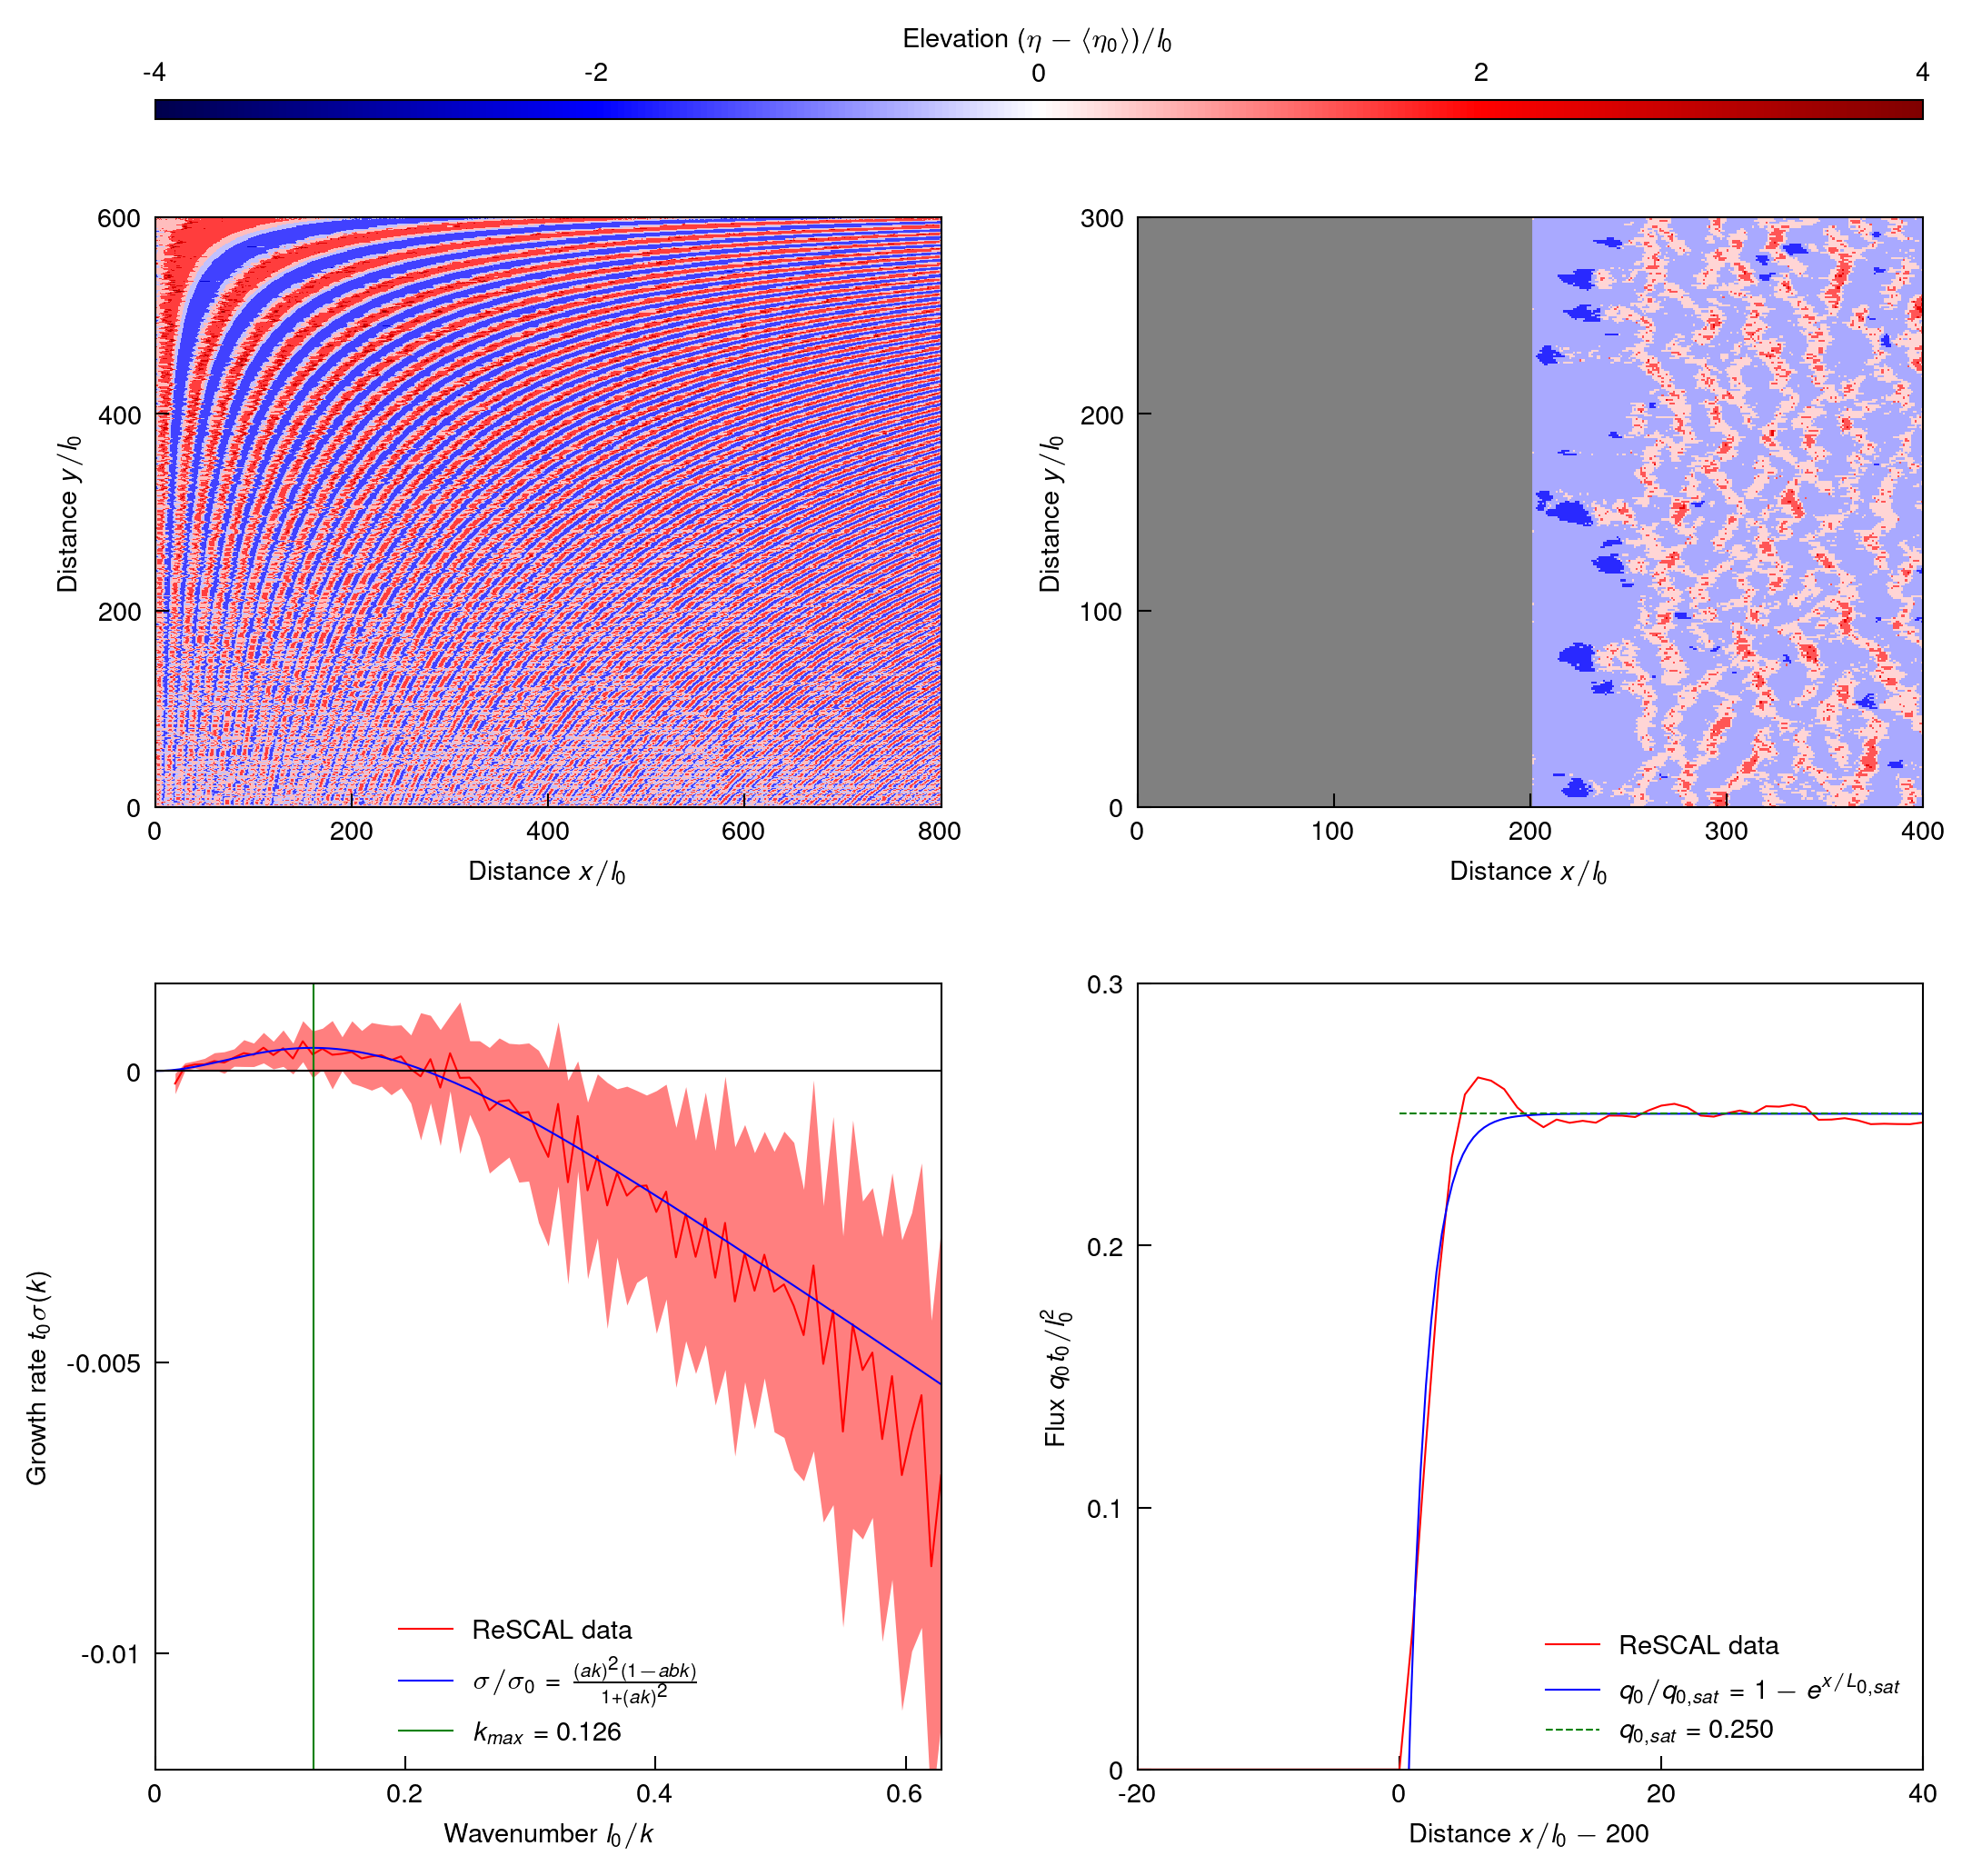

In [30]:
fig = plt.gcf()

lw = 0.5
S  = 2
M  = 4

ax1 = fig.add_axes([0.08,0.5,0.4,0.4])
pc = plt.pcolor(Ainstability,cmap='seismic',vmin=-M,vmax=M,rasterized=True)
plt.xlabel('Distance $x/l_0$',fontsize=fs)
plt.ylabel('Distance $y/l_0$',fontsize=fs)
ax1.set_xticks([0,200,400,600,800])
ax1.set_xticklabels(['0','200','400','600','800'],fontsize=fs)
ax1.set_yticks([0,200,400,600])
ax1.set_yticklabels(['0','200','400','600'],fontsize=fs)
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([0.58,0.5,0.4,0.4])
plt.pcolor(Topo-Topo[:200].mean(),cmap='seismic',vmin=-M,vmax=M,rasterized=True)
plt.fill_betweenx([0,300], 200, 0,color='grey')
plt.xlabel('Distance $x/l_0$',fontsize=fs)
plt.ylabel('Distance $y/l_0$',fontsize=fs)
plt.xlim(0,400)
plt.ylim(0,300)
ax2.set_xticks([0,100,200,300,400])
ax2.set_xticklabels(['0','100','200','300','400'],fontsize=fs)
ax2.set_yticks([0,100,200,300])
ax2.set_yticklabels(['0','100','200','300'],fontsize=fs)
ax2.set_aspect('equal', 'box')

ax3 = fig.add_axes([0.08,0.06,0.4,0.4])
plt.plot(wanumunique,sigmaav,'r',lw=lw,label='ReSCAL data')
plt.fill_between(wanumunique,sigmaav-sigmastd,sigmaav+sigmastd,color='r',lw=0,alpha=0.5)
plt.plot(wanum_fit,sigma_fit,'b',lw=lw,label='$\sigma/\sigma_0=\\frac{(ak)^{2}(1-abk)}{1+(ak)^{2}}$')
plt.plot([wanum_max,wanum_max],[-0.012,0.0015],'g',lw=lw,label='$k_{max}$ = %0.3f'%wanum_max)
plt.plot([0,np.max(wanumunique)],[0,0],'k',lw=lw)
plt.xlabel('Wavenumber $l_0/k$',fontsize=fs)
plt.ylabel('Growth rate $t_0\\sigma(k)$',fontsize=fs)
plt.legend(frameon=False,loc=8,fontsize=fs)
plt.xlim(0,np.max(wanum[1:]))
plt.ylim(-0.012,0.0015)
ax3.set_xticks([0,0.2,0.4,0.6])
ax3.set_xticklabels(['0','0.2','0.4','0.6'],fontsize=fs)
ax3.set_yticks([-0.01,-0.005,0])
ax3.set_yticklabels(['-0.01','-0.005','0'],fontsize=fs)

ax4 = fig.add_axes([0.58,0.06,0.4,0.4])
plt.plot(x, dat,'r',lw=lw,ms=2,label='ReSCAL data')
xdata = np.linspace(0,40,100)
plt.plot(xdata, Exp_relax(xdata, *p),'b',lw=lw,label='$q_0/q_{0,sat}=1-e^{x/L_{0,sat}}$')
plt.plot([0,40],[p[0],p[0]],'--g',lw=lw,label='$q_{0,sat}$ = %0.3f'%p[0])
plt.xlabel('Distance $x/l_0-200$',fontsize=fs)
plt.ylabel('Flux $q_{0}t_0/l_0^2$',fontsize=fs)
plt.legend(frameon=False,fontsize=fs)
plt.xlim(-20,40)
plt.ylim(0,0.3)
ax4.set_xticks([-20,0,20,40])
ax4.set_xticklabels(['-20','0','20','40'],fontsize=fs)
ax4.set_yticks([0,0.1,0.2,0.3])
ax4.set_yticklabels(['0','0.1','0.2','0.3'],fontsize=fs)

cbar1_ax = fig.add_axes([0.08,0.9,0.98-0.08,0.01])
c1 = fig.colorbar(pc, orientation='horizontal',cax=cbar1_ax, ticks=[-4,-2,0,2,4])
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
c1.set_label('Elevation $(\eta-\langle\eta_0\\rangle)/l_0$',fontsize=fs)
c1.ax.set_xticklabels(['-4','-2','0','2','4'],fontsize=fs)

ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw)
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
ax4.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)
    
fig.set_size_inches(183./25.4, 183./25.4, forward=True)
plt.savefig('figures/edfig3-rough.pdf', dpi=300)

# Extended Data Figure 4

In [121]:
tempx = []
for i in range(len(Il_M)):
    if Il_M[i]==Is_M[i]:
        tempx.append(RDP[i]/DP[i])
    else:
        tempx.append(RDP[i]/DP[i])
        tempx.append(RDP[i]/DP[i])
tempx = np.asarray(tempx)
tempy = Z_M

N = 10000
templinfits = np.empty((N,2))
templinfits[0] = np.polyfit(tempx,tempy,deg=1)
for i in range(1,N):
    np.random.shuffle(tempx)
    templinfits[i] = np.polyfit(tempx,tempy,deg=1)
    
tempx = []
for i in range(len(Il_M)):
    if Il_M[i]==Is_M[i]:
        tempx.append(RDP[i]/DP[i])
    else:
        tempx.append(RDP[i]/DP[i])
        tempx.append(RDP[i]/DP[i])
tempx = np.asarray(tempx)
tempy = Z_M

<ipython-input-227-0e2869f3873b>:11: RuntimeWarning: divide by zero encountered in log10
  s1 = plt.pcolormesh(tempbinsx,tempbinsy,np.log10(tempcounts).T,vmin=-3,vmax=0,cmap='Reds')


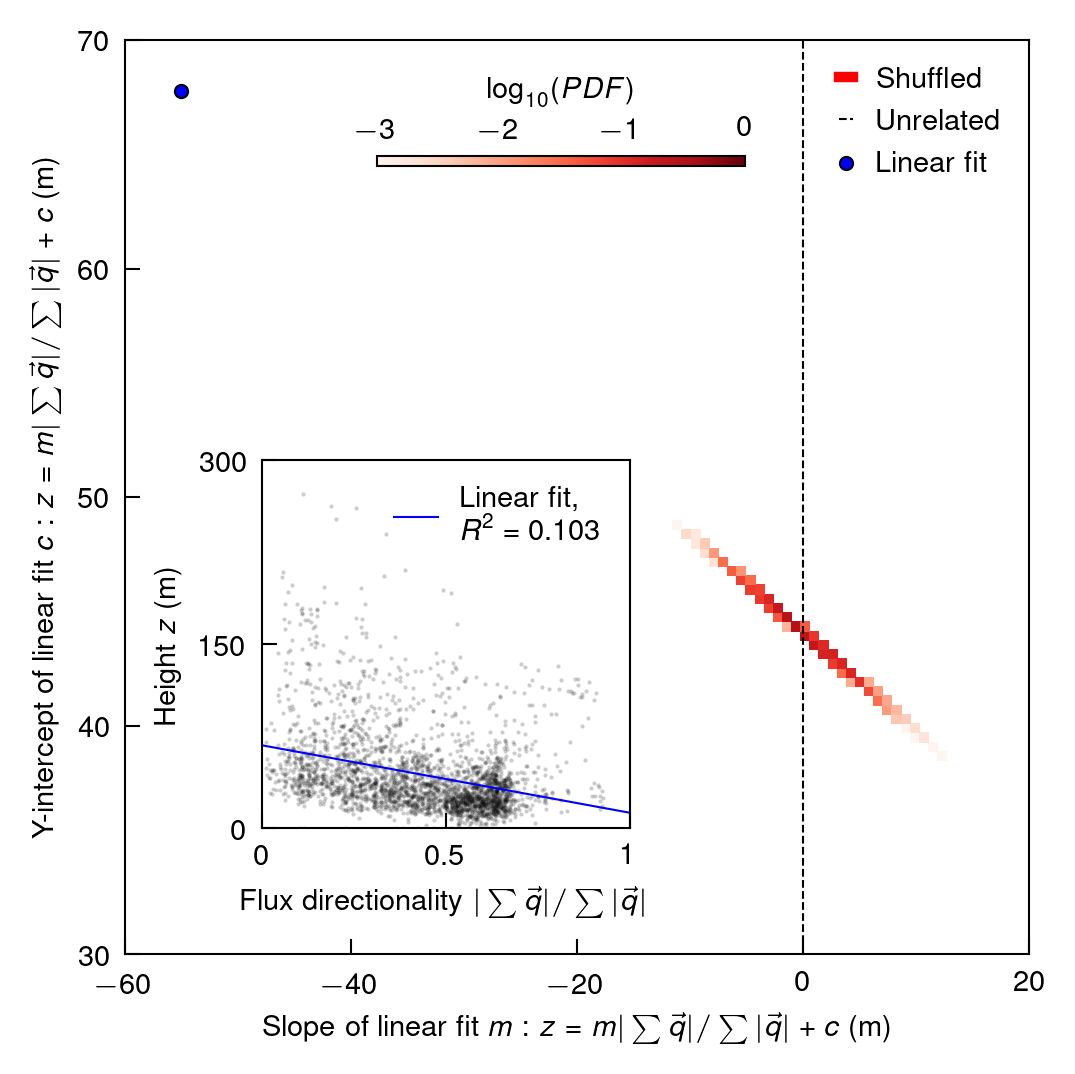

In [227]:
tempbinsx = np.linspace(-60,20,int(N*1e-2))
tempbinsy = np.linspace(30,70,int(N*1e-2))
tempcounts,_,_ = np.histogram2d(templinfits[1:,0],templinfits[1:,1],bins=(tempbinsx,tempbinsy),density=True)

S = 10

fig = plt.gcf()

ax1 = fig.add_axes([0.11,0.10,0.86,0.87])

s1 = plt.pcolormesh(tempbinsx,tempbinsy,np.log10(tempcounts).T,vmin=-3,vmax=0,cmap='Reds')
plt.plot(np.nan,np.nan,'r',lw=2.5,label='Shuffled')
plt.scatter(templinfits[0,0],templinfits[0,1],c='b',edgecolors='k',s=S,lw=lw,label='Linear fit')
plt.plot([0,0],[30,70],'--k',lw=lw,label='Unrelated')
plt.ylabel('Y-intercept of linear fit $c: z=m|\\sum\\vec{q}|/\\sum|\\vec{q}|+c$ (m)',fontsize=fs)
plt.xlabel('Slope of linear fit $m: z=m|\\sum\\vec{q}|/\\sum|\\vec{q}|+c$ (m)',fontsize=fs)
ax1.set_xticks([-60,-40,-20,0,20])
ax1.set_xticklabels(['$-60$','$-40$','$-20$','$0$','$20$'],fontsize=fs)
ax1.set_yticks([30,40,50,60,70])
ax1.set_yticklabels(['$30$','$40$','$50$','$60$','$70$'],fontsize=fs)
ax1.tick_params('both', width=lw, which='major')
plt.legend(frameon=False,fontsize=fs,handlelength=0.5)

r2 = 1-np.sum((tempy-(templinfits[0,0]*tempx+templinfits[0,1]))**2)/np.sum((tempy-np.mean(tempy))**2)

ax2 = fig.add_axes([0.24,0.22,0.35,0.35])

plt.scatter(tempx,tempy,s=1,c='k',alpha=0.2,lw=0)
plt.plot(np.asarray([0,1]),np.asarray([0,1])*templinfits[0,0]+templinfits[0,1],'b',lw=lw,label="Linear fit,\n$R^2$ = %.3f"%r2)
plt.ylabel('Height $z$ (m)',fontsize=fs)
plt.xlabel('Flux directionality $|\\sum\\vec{q}|/\\sum|\\vec{q}|$',fontsize=fs)
plt.xlim(0,1)
plt.ylim(0,300)
ax2.set_xticks([0,0.5,1])
ax2.set_xticklabels(['$0$','$0.5$','$1$'],fontsize=fs)
ax2.set_yticks([0,150,300])
ax2.set_yticklabels(['$0$','$150$','$300$'],fontsize=fs)
plt.legend(frameon=False,fontsize=fs,handlelength=lw*3)

cbar1_ax = fig.add_axes([0.35,0.85,0.35,0.01])
c1 = fig.colorbar(s1, orientation='horizontal',cax=cbar1_ax, ticks=[-3,-2,-1,0])
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
c1.set_label('$\\log_{10}(PDF)$',fontsize=fs)
c1.ax.set_xticklabels(['$-3$','$-2$','$-1$','$0$'],fontsize=fs)

ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)

fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(top=0.96)
fig.subplots_adjust(right=1)
fig.subplots_adjust(left=0.05)

fig.set_size_inches(89/25.4, 89/25.4, forward=True)
plt.savefig('figures/edfig4.png',dpi=300)
plt.savefig('figures/edfig4.pdf',dpi=300)

# Supplementary Table 1

In [1662]:
mlh_time = []
mlh_vals = []

for i in range(len(duneareas)):
    try:
        temp = np.asarray(pd.read_csv('calipso/Df%.2d_timeseries.csv'%i,header=0).iloc[:,1])
        mlh_time.append(np.asarray(pd.read_csv('calipso/Df%.2d_timeseries.csv'%i,header=0).iloc[:,0])[~np.isnan(temp)])
        mlh_vals.append(temp[~np.isnan(temp)])
    except:
        mlh_time.append(np.asarray([]))
        mlh_vals.append(np.asarray([]))
    
radiuss = np.asarray([90,90,90,15,90,90,90,90,65,90,90,90,50,50,40,40,90,90,30,30,65,90,90,90,60,30,90,90,25,50,90,90,90,90,90,90,90,90])

dfnames = ['Namib Sand Sea',
          'Grand Erg Occidental',
          'Grand Erg Oriental',
          'West Erg Issaouane',
          'East Erg Issaouane',
          'Idehan Ubari',
          'Idehan Murzuk',
          'Central Grand Sand Sea',
          'Dakhla Farafra',
          'Sinai Negev Erg',
          'An Nafud \& Ad Dahna',
          'Rub Al Khali',
          'Ramlat Al Sabatayn',
          'Wahiba Sands',
          'West Registan Desert',
          'Kharan Desert',
          'Karakum Desert',
          'Thar Desert',
          'Rig-e Jenn',
          'Rig-e Yalan',
          'East Registan Desert',
          'Southwest Takla Makan',
          'Northwest Takla Makan',
          'Central Takla Makan',
          'East Takla Makan',
          'Kumtag Desert',
          'Badain Jaran Desert',
          'Tengger Desert',
          'Ulan Buh Desert',
          'Hobp Desert',
          'Munga-Thirri',
          'Yamma Yamma',
          'Gran Desierto',
          'Ergs Iguidi \& Chech',
          'Aoukar',
          'El Djouf',
          'Azefal, Akchar \& Agneitir Sand Seas',
          'Trarza Reion Desert']

mlh_dfnames = []
mlh_radiuss = []
mlh_nobserv = []

for i in range(len(mlh_time)):
    if len(mlh_time[i])>0:
        mlh_dfnames.append(np.hstack((dfnames[i],[' ']*(len(mlh_time[i])-1))))
        mlh_nobserv.append(np.hstack((len(mlh_time[i]),[' ']*(len(mlh_time[i])-1))))
        mlh_radiuss.append(np.hstack((radiuss[i],[' ']*(len(mlh_time[i])-1))))

In [1664]:
columns = ['Name','ROI Radius (km)','No. Observations','Time (LST)','MLH (km)']

data = np.vstack((np.hstack(mlh_dfnames),np.hstack(mlh_radiuss),np.hstack(mlh_nobserv),np.hstack(mlh_time),np.hstack(mlh_vals))).T
dataframe = pd.DataFrame(data=data,columns=columns)
dataframe.to_csv('TableS1.csv',index=False)

# Scratch

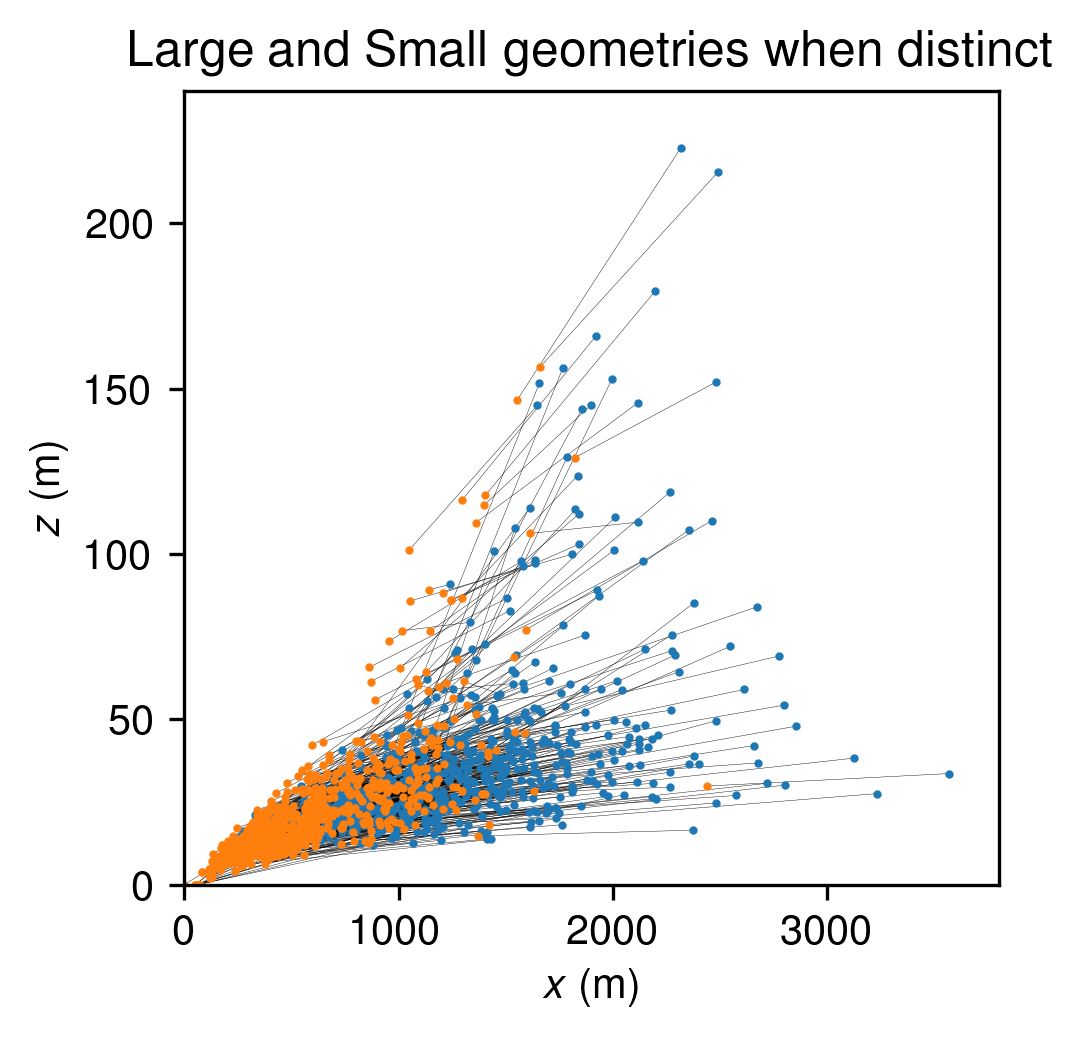

In [1709]:
Isu_M = []
Ilu_M = []
Zsu_M = []
Zlu_M = []


for i in range(len(Il_M)):
    if Is_M[i]!=Il_M[i]:
        Isu_M.append(Is_M[i])
        Ilu_M.append(Il_M[i])
        Zsu_M.append(Zs_M[i])
        Zlu_M.append(Zl_M[i])

fig = plt.gcf()
        
plt.scatter(Ilu_M,Zlu_M,s=1)
plt.scatter(Isu_M,Zsu_M,s=1)
plt.plot([Isu_M,Ilu_M],[Zsu_M,Zlu_M],lw=0.1,zorder=-1,c='k')
plt.xlim(0,3800)
plt.ylim(0,240)
plt.title('Large and Small geometries when distinct')
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)')

fig.set_size_inches(89/25.4, 89/25.4, forward=True)

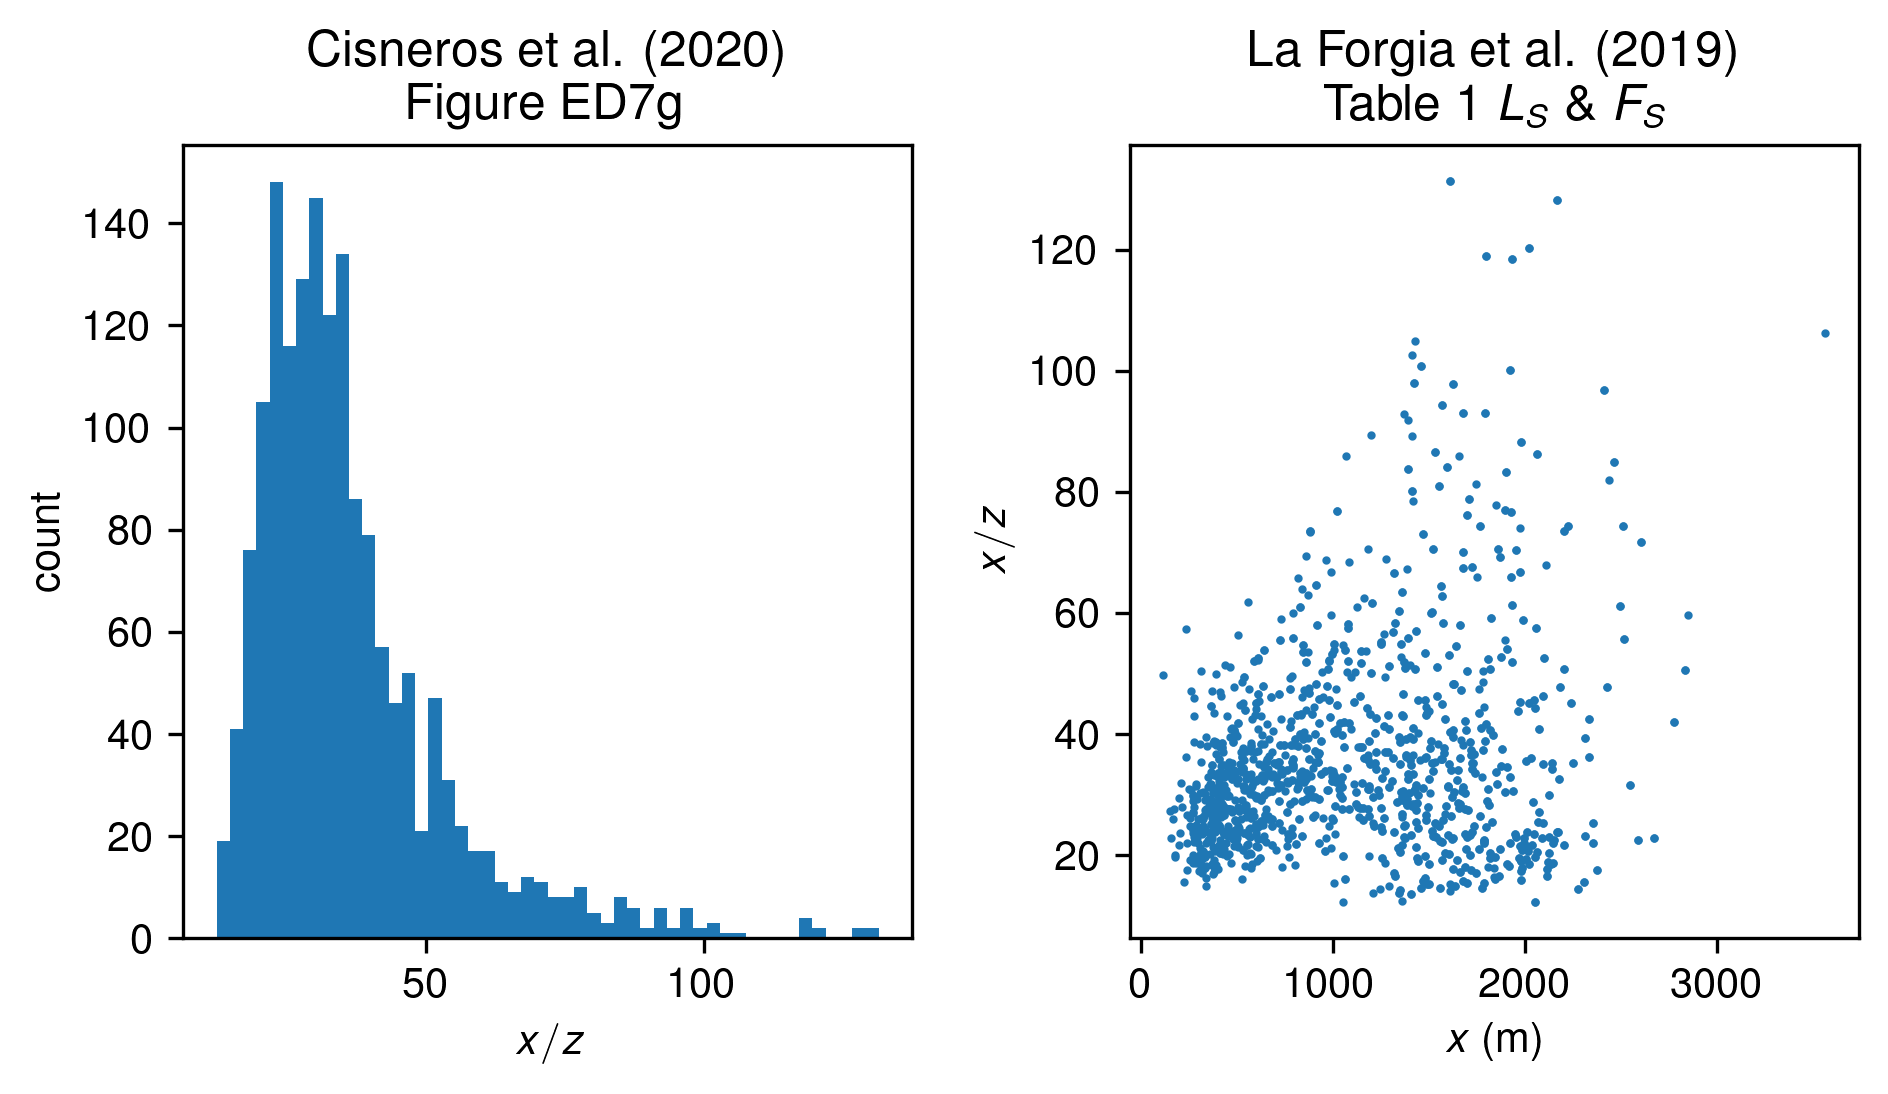

In [818]:
temp = np.hstack((Ilb[Ilb>Ilim]/Zlb[Ilb>Ilim],
                 Isb[Isb>Ilim]/Zsb[Isb>Ilim],
                 Ilt[Ilt>Ilim]/Zlt[Ilt>Ilim],
                 Ist[Ist>Ilim]/Zst[Ist>Ilim]))
temp1 = np.hstack((Ilb[Ilb>Ilim],
                 Isb[Isb>Ilim],
                 Ilt[Ilt>Ilim],
                 Ist[Ist>Ilim]))

fig = plt.gcf()

plt.subplot(121)
plt.hist(temp,bins=50)
plt.title('Cisneros et al. (2020)\n Figure ED7g')
plt.xlabel('$x/z$')
plt.ylabel('count')

plt.subplot(122)
plt.scatter(temp1,temp,s=1)
plt.title('La Forgia et al. (2019)\n Table 1 $L_S$ \& $F_S$')
plt.ylabel('$x/z$')
plt.xlabel('$x$ (m)')

fig.subplots_adjust(wspace=0.3)
fig.set_size_inches(183/25.4, 89/25.4, forward=True)